# Implémentez un modèle de scoring
## Partie 2 : Modélisation

### 1 - Mise en place de l'environnement de travail

#### 1.1 Librairies

In [149]:
# General
# File system management
import os

# Visualisation
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import seaborn as sns

import math
from termcolor import colored
import time

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler 

import pickle
from urllib.parse import urlparse

import mlflow
import mlflow.sklearn
import mlflow.pyfunc

#import shap

%matplotlib inline

time: 0 ns (started: 2023-07-04 23:41:35 +02:00)


#### 1.2 Paramètres

In [150]:
# Format & option
sns.set(rc={"figure.figsize": (16, 9)})
pd.options.display.max_columns = 150

# Style use
sns.set_style("darkgrid")
plt.style.use("ggplot")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
%matplotlib inline

# Suppress warnings
import warnings

warnings.filterwarnings("ignore")

time: 0 ns (started: 2023-07-04 23:41:35 +02:00)


In [151]:
#permet de mesurer le temps d'exécution des cellules lors de l'exécution
# !pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 16 ms (started: 2023-07-04 23:41:35 +02:00)


### 2 - Réflexion + fonctions

Dans ce notebook, je vais tout d'abord mettre en place un modèle de régression comme base puis une comparaison d'algorithmes de classification, déterminer celui qui sera le plus adapté à notre problématique (en prenant en compte le fait qu'il y ait un déséquilibre de TARGET) tout en montrant l'importance des features puis séléctionner les features pertinentes pour les visualisations sur notre dashboard.

L'objectif de ce projet est d'utiliser les données historiques des demandes de prêt pour prédire si un demandeur sera en mesure ou non de rembourser un prêt. "Il s'agit d'une classification supervisée".

apprentissage superviser : Les étiquettes sont incluses dans les données d'apprentissage et l'objectif est de former un modèle pour apprendre à prédire les étiquettes à partir des caractéristiques.
Classification : L'étiquette est une variable binaire, 0 (remboursera le prêt à temps), 1 (aura des difficultés à rembourser le prêt)".




Il y a beaucoup plus de prêts remboursés à temps que de prêts non remboursés. 

Une fois que nous entrons dans des modèles d'apprentissage automatique plus sophistiqués, nous pouvons pondérer les classes par leur représentation dans les données pour refléter ce déséquilibre.


#### 2.1 Reflexion

**Métrique adaptée au problème de la banque:**

La banque cherche les personnes ne pouvant rembourser un prêt et lorsque ce but est atteint l'évènement est positif. Le défaut de remboursement sera donc considéré comme l'évènement positif. positif = 1.

>TP (True Positives) : les cas où la prédiction est positive, et où la valeur réelle est effectivement positive.  <font color='red'>LE PRET N'EST PAS ACCORDE ET LE CLIENT NE PEUT PAS REMBOURSER LE PRET</font>

>TN (True Negatives) : les cas où la prédiction est négative, et où la valeur réelle est effectivement négative. <font color='red'>LE PRET EST ACCORDE ET LE CLIENT PEUT REMBOURSER LE PRET</font> 

>FP (False Positive) : les cas où la prédiction est positive, mais où la valeur réelle est négative.  <font color='red'>LE PRET N'EST PAS ACCORDE MAIS LE CLIENT PEUT REMBOURSE LE PRET</font>

>FN (False Negative) : les cas où la prédiction est négative, mais où la valeur réelle est positive. <font color='red'>LE PRET EST ACCORDE MAIS LE CLIENT NE PEUT PAS REMBOURSER LE PRET</font> 

Une banque cherche à ne pas accorder de prêt à des clients qui ne peuvent pas le rembourser (TP à maximiser). La banque ne veut pas accorder un prêt à un client qui ne peut pas le rembourser (FN à minimiser). La banque fait un déficit si elle n'accorde pas de prêt à des clients qui peuvent rembourser le prêt.


**Les algorithmes sont comparés par les métriques suivantes :** 
* Accuracy_score : le ratio entre le nombre total de prédictions correctes et le nombre total de prédictions (c'est la justesse de la prédiction).
* Precision : Le ratio entre les vrais positifs et tous les positifs
* Recall : La moyenne harmonique de Precision et du Recall. Un bon score F1 indique une bonne Precision et une bonne valeur de Recall
* F1_score : Synthèse de Precision et Recall
* AUC : Aire sous la courbe ROC = mesure de la capacité d'un classifieur à distinguer les classes. Plus l'AUC est élevée, plus la performance du modèle à distinguer les classes positives et négatives est bonne.
* Matrice de confusion
* ROC Curve



maximiser : AUC, TP, F1, recall


minimiser : FN


**Définition d'une métrique "métier"**

Il faut créer une métrique pertinente concernant notre problématique pour comparer nos algorithmes. Une société de crédit cherche à "maximiser" ses gains. 
* Accorder un crédit à quelqu'un ne pouvant pas le rembourser par la suite (FN) est synonyme de perte pour l'entreprise
* Accorder un crédit à un client qui le rembousera par la suite (TN) est un gain.
* Ne pas accorder le prêt et que le client ne peut pas rembourser (TP) n'est ni une perte, ni un gain. 
* Ne pas accorder le prêt mais que le client pouvait rembourser (FP) est une perte de client donc d'argent.

On va donc créer un score en pondérant les différents cas possibles qui sera normalisé entre 0 et 1 par une normalisation min-max feature scalling avec : 

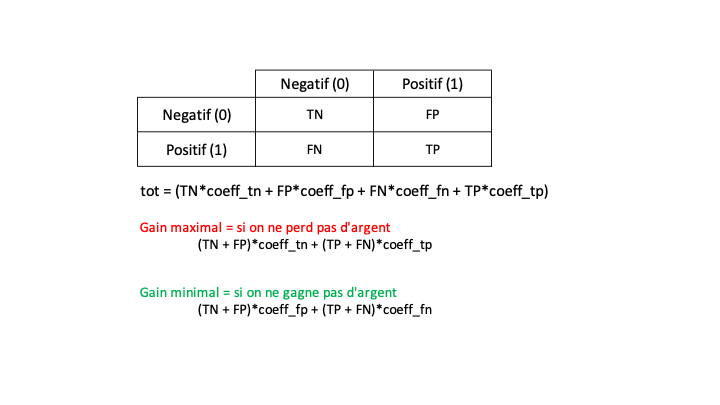

puis gain = (tot-gain_min) / (gain_max-gain_min)


Exemple de coefficients possibles en respectant la métrique métier :
* FN ==> perte d'argent pour la banque ==> -100 
* TP ==> refus de prêt ==> 0
* TN ==> prêt accordé, gain d'argent pour la banque ==> +10
* FP ==> client perdu, perte d'argent pour la banque ==> -1

La courbe ROC (Reciever Operating Characteristic) représente le taux de vrais positifs par rapport au taux de faux positifs.

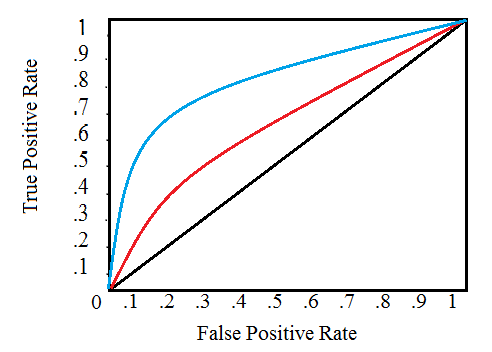

Une seule ligne sur le graphique indique la courbe pour un seul modèle, et le déplacement le long d'une ligne indique le changement du seuil utilisé pour classer une instance positive. Le seuil commence à 0 dans la partie supérieure droite et va jusqu'à 1 dans la partie inférieure gauche. Une courbe qui se trouve à gauche et au-dessus d'une autre courbe indique un meilleur modèle. Par exemple, le modèle bleu est meilleur que le modèle rouge, qui est meilleur que la ligne diagonale noire qui indique un modèle de supposition aléatoire naïve.

AUC :  Il s'agit simplement de l'aire sous la courbe ROC. (C'est l'intégrale de la courbe.) Cette métrique est comprise entre 0 et 1, un meilleur modèle obtenant un score plus élevé. Un modèle qui se contente de deviner au hasard aura une AUC ROC de 0,5. l'AUC est une mesure de la probabilité pour que le modèle classe un exemple positif aléatoire au-dessus d'un exemple négatif aléatoire. 

#### 2.2 Fonctions

In [152]:
# ne pas oublier de lancer le serveure local sur git bash "mlflow server"

# Initialisation de MLflow pour enregistrer les métriques
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment('Classification Models')

<Experiment: artifact_location='mlflow-artifacts:/292123401184494254', creation_time=1688479181280, experiment_id='292123401184494254', last_update_time=1688479181280, lifecycle_stage='active', name='Classification Models', tags={}>

time: 47 ms (started: 2023-07-04 23:41:35 +02:00)


In [153]:
def classification(best_param, X_train, y_train, X_test, y_test, algo_name, file_name=None):
    """
    Fonction pour évaluer la performance d'un modèle de classification donné sur les données de test.

    Arguments :
    best_param : Le modèle d'algorithme de classification avec les meilleurs hyperparamètres.
    X_train : Les données d'entraînement (caractéristiques).
    y_train : Les étiquettes d'entraînement (variable cible).
    X_test : Les données de test (caractéristiques).
    y_test : Les étiquettes de test (variable cible).
    algo_name : Le nom de l'algorithme de classification utilisé (pour l'affichage).
    file_name : Le nom du fichier dans lequel sauvegarder le modèle entraîné (optionnel).

    Retour :
    model : Le modèle entraîné avec les meilleurs hyperparamètres.
    accuracy : L'accuracy score du modèle sur les données de test.
    precision : Le score de précision du modèle sur les données de test.
    recall : Le score recall du modèle sur les données de test.
    f1 : Le score f1 du modèle sur les données de test.
    AUC : L'AUC (Area Under the Curve) du ROC du modèle sur les données de test.
    prediction : Les prédictions du modèle sur les données de test.
    probability : Les probabilités de classification du modèle sur les données de test.
    execution_time : Le temps d'exécution pour entraîner le modèle.
    prediction_time : Le temps d'exécution pour faire les prédictions.
    resume_prediction_class : Un DataFrame contenant les étiquettes réelles et prédites pour les données de test.
    probability_positive_class : Un DataFrame contenant les probabilités de classification positives pour les données de test.
    """
    # Impression en couleur pour indiquer le début de l'exécution
    print(colored("Exécution \n ", 'red'))

    # Initialisation du compteur de temps
    start_time = time.time()

    # Entraînement du modèle avec les meilleurs paramètres
    model = best_param.fit(X_train, y_train)

    # Calcul du temps d'exécution pour l'entraînement du modèle
    execution_time = (time.time() - start_time)

    # Sauvegarde du modèle si un nom de fichier est fourni
    if file_name is None:
        pass
    else:
        filename = file_name
        pickle.dump(model, open(filename, 'wb'))

    # Initialisation du compteur de temps pour les prédictions
    start_time = time.time()

    # Prédiction sur l'ensemble de test
    prediction = best_param.predict(X_test)

    # Calcul du temps d'exécution pour les prédictions
    prediction_time = (time.time() - start_time)

    #prediction de probabilité d'appartenance à 0 et 1
    probability = best_param.predict_proba(X_test)
    probability_positive = probability[:, 1]

    # Création de DataFrames pour les étiquettes réelles et prédites ainsi que les probabilités positives
    resume_prediction_class = pd.DataFrame({'cat_reel': y_test, 'cat_predit': prediction}).reset_index()
    probability_positive_class = pd.DataFrame({'SK_ID_CURR': X_test.index, 'positive_probability': probability_positive})

    # Impression des probabilités positives pour les échantillons de l'ensemble de test
    print(probability_positive_class)
    print(colored("Qualité de la classification \n \n ", 'red'))

    # Calcul et affichage des métriques de qualité de classification
    accuracy = accuracy_score(y_test, prediction)
    print(colored(f'L\'accuracy score est de {accuracy} pour la méthode {algo_name}.\n \n ', 'blue'))

    precision = precision_score(y_test, prediction, average='binary')
    print(colored(f'Le score de précision est de {precision} pour la méthode {algo_name}.\n \n ', 'blue'))

    recall = recall_score(y_test, prediction, average='binary')
    print(colored(f'Le score recall est de {recall} pour la méthode {algo_name}.\n \n ', 'blue'))

    f1 = f1_score(y_test, prediction, average='binary')
    print(colored(f'Le score f1 est de {f1} pour la méthode {algo_name}.\n \n ', 'blue'))

    AUC = roc_auc_score(y_test, probability[:, 1])  # probabilité de ne pas rembourser le prêt donc d'être étiqueté comme 1
    print(colored(f'Le score AUC est de {AUC} pour la méthode {algo_name}.\n \n ', 'blue'))

    with mlflow.start_run(run_name='classification/' + algo_name) as run:
        mlflow.log_metric('accuracy', accuracy)
        mlflow.log_metric('precision', precision)
        mlflow.log_metric('recall', recall)
        mlflow.log_metric('f1', f1)
        mlflow.log_metric('AUC', AUC)
        mlflow.log_metric('execution_time', execution_time)
        mlflow.log_metric('prediction_time', prediction_time)

        # Intégration avec MLflow - enregistrement du modèle
        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
        if tracking_url_type_store != "file":
            mlflow.sklearn.log_model(model, algo_name, registered_model_name="CreditModels")
        else:
            mlflow.sklearn.log_model(model, algo_name)
            
    # Retourne le modèle entraîné, les métriques et les prédictions pour une utilisation ultérieure si nécessaire
    return model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class


time: 0 ns (started: 2023-07-04 23:41:35 +02:00)


In [154]:
def matrix_TN_FN(y_test, y_prediction):

    '''Cette fonction calcule les éléments d'une matrice de confusion
      à partir des valeurs réelles (y_test) et des valeurs prédites (y_prediction).
    '''

    # Création de la matrice de confusion avec des colonnes pour les prédictions négatives et positives,
    # et des lignes pour les vrais négatifs et les vrais positifs.
    df_matrice_confusion = pd.DataFrame(columns=['Predicted Negative (0)', 'Predicted Positive (1)'],
                                        index=['Real Negative (0)', 'Real Positive (1)'])

    # Création d'un DataFrame de comparaison avec les valeurs réelles et les valeurs prédites côte à côte.
    df_pred_compare = pd.concat([pd.Series(y_test.reset_index(drop=True)), pd.Series(y_prediction)], axis=1)
    df_pred_compare.columns = ['Real category', 'Prediction']

    # Masque pour les vrais positifs, les vrais négatifs, les faux positifs et les faux négatifs.
    mask_real_pos = (df_pred_compare['Real category'] == 1)
    mask_pred_pos = (df_pred_compare['Prediction'] == 1)
    mask_real_neg = (df_pred_compare['Real category'] == 0)
    mask_pred_neg = (df_pred_compare['Prediction'] == 0)

    # Calcul du nombre de vrais négatifs (TN) et de faux négatifs (FN).
    true_negative = df_pred_compare[mask_real_neg & mask_pred_neg].shape[0]
    false_negative = df_pred_compare[mask_real_pos & mask_pred_neg].shape[0]

    # Calcul du nombre de faux positifs (FP) et de vrais positifs (TP).
    false_positive = df_pred_compare[mask_real_neg & mask_pred_pos].shape[0]
    true_positive = df_pred_compare[mask_real_pos & mask_pred_pos].shape[0]

    # Remplissage de la matrice de confusion avec les valeurs calculées.
    df_matrice_confusion['Predicted Negative (0)'] = [f"{true_negative} (TN)", f"{false_negative} (FN)"]
    df_matrice_confusion['Predicted Positive (1)'] = [f"{false_positive} (FP)", f"{true_positive} (TP)"]

    return df_matrice_confusion


time: 0 ns (started: 2023-07-04 23:41:35 +02:00)


In [155]:
def cf_matrix_roc_auc(y_true, y_pred, y_pred_proba, size):
    '''Cette fonction affiche la matrice de confusion et la courbe ROC en fonction des vraies valeurs (y_true),
    des valeurs prédites (y_pred), des probabilités prédites (y_pred_proba) et de la taille de la figure (size).
    '''

    # Crée une nouvelle figure avec la taille spécifiée.
    fig = plt.figure(figsize=size)

    # Ajoute un subplot pour la matrice de confusion.
    ax1 = fig.add_subplot(221)
    ax1.title.set_text('Confusion Matrix')

    # Calcule la matrice de confusion.
    cf_matrix = confusion_matrix(y_true, y_pred)

    # Récupère les valeurs TN, FP, FN et TP à partir de la matrice de confusion.
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()

    # Noms des groupes pour les annotations.    
    group_names = ['True Neg (TN)', 'False Pos (FP)', 'False Neg (FN)', 'True Pos (TP)']

    # Formate les valeurs pour les annotations.
    group_counts = [f"{value :0.0f}" for value in cf_matrix.flatten()]
    group_percentages = [f"{value:.2%}" for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    # Prépare les annotations avec les noms, les comptes et les pourcentages.
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    # Crée une heatmap avec les annotations.
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='RdPu')

    # Paramètres d'affichage pour l'axe des x.
    plt.tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, top=False, labeltop=True)

    # Ajoute un subplot pour la courbe ROC.
    ax2 = fig.add_subplot(222)
    ax2.title.set_text('ROC Curve')

    # Calcule les taux de faux positifs et de vrais positifs pour la courbe ROC.
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba[:, 1])  # Pour la courbe ROC, utilisation de la probabilité d'être 1.

    # Trace la courbe ROC avec l'aire sous la courbe (AUC).
    plt.plot(fpr, tpr, color='pink', linewidth=5, label='AUC = %0.4f' % roc_auc)
    
    # Trace la droite en pointillés (ligne de référence).
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    # Affiche la figure avec la matrice de confusion et la courbe ROC.
    plt.show()

    # Affiche les valeurs TN, FP, FN et TP.
    print('True negative = ', tn)
    print('False positive = ', fp)
    print('False negative = ', fn)
    print('True positive = ', tp)

    # Renvoie les valeurs TN, FP, FN et TP.
    return tn, fp, fn, tp


time: 0 ns (started: 2023-07-04 23:41:35 +02:00)


In [156]:
def score_banq(tn, fp, fn, tp, coeff_tn, coeff_fp, coeff_fn, coeff_tp):

    total = (coeff_tn*tn + coeff_fp*fp + coeff_fn*fn + coeff_tp*tp)

    #calcul du gain maximal que peut avoir la banque quand il n'y a pas de perte d'argent. C'est à dire que le modèle ne détecte que TN et les TP.
    max_gain = (tn + fp)*coeff_tn + (tp + fn)*coeff_tp

    #calcul du gain minimal (perte) que peut avoir la banque quand il n'y a pas de gain d'argent. C'est à dire que le modèle ne détecte que FN et les FP.
    min_gain = (tn + fp)*coeff_fp + (tp + fn)*coeff_fn

    #normalisation min-max feature scalling : score= (tot-min)/(max-min) https://en.wikipedia.org/wiki/Normalization_(statistics) 
    score = (total - min_gain)/(max_gain - min_gain)

    return score

time: 0 ns (started: 2023-07-04 23:41:35 +02:00)


### 3 - Importation de données

In [157]:
# import fichier df_train_imputed sans la standardisation
df_train = pd.read_csv('df_train_imputed.csv', index_col='SK_ID_CURR', encoding ='utf-8')

import re
# supprimant tout caractère spécial autre que les lettres, les chiffres et le caractère souligné ('_'). 
df_train = df_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

time: 11.9 s (started: 2023-07-04 23:41:35 +02:00)


In [158]:
df_train

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,EMERGENCYSTATE_MODE,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,...,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business_Entity_Type_1,ORGANIZATION_TYPE_Business_Entity_Type_2,ORGANIZATION_TYPE_Business_Entity_Type_3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry_type_1,ORGANIZATION_TYPE_Industry_type_10,ORGANIZATION_TYPE_Industry_type_11,ORGANIZATION_TYPE_Industry_type_12,ORGANIZATION_TYPE_Industry_type_13,ORGANIZATION_TYPE_Industry_type_2,ORGANIZATION_TYPE_Industry_type_3,ORGANIZATION_TYPE_Industry_type_4,ORGANIZATION_TYPE_Industry_type_5,ORGANIZATION_TYPE_Industry_type_6,ORGANIZATION_TYPE_Industry_type_7,ORGANIZATION_TYPE_Industry_type_9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal_Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security_Ministries,ORGANIZATION_TYPE_Selfemployed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade_type_1,ORGANIZATION_TYPE_Trade_type_2,ORGANIZATION_TYPE_Trade_type_3,ORGANIZATION_TYPE_Trade_type_4,ORGANIZATION_TYPE_Trade_type_5,ORGANIZATION_TYPE_Trade_type_6,ORGANIZATION_TYPE_Trade_type_7,ORGANIZATION_TYPE_Transport_type_1,ORGANIZATION_TYPE_Transport_type_2,ORGANIZATION_TYPE_Transport_type_3,ORGANIZATION_TYPE_Transport_type_4,ORGANIZATION_TYPE_University,HOUSETYPE_MODE_block_of_flats,HOUSETYPE_MODE_specific_housing,HOUSETYPE_MODE_terraced_house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,WALLSMATERIAL_MODE_Stone_brick,WALLSMATERIAL_MODE_Wooden,MOST_CREDIT_TYPE_Another_type_of_loan,MOST_CREDIT_TYPE_Car_loan,MOST_CREDIT_TYPE_Consumer_credit,MOST_CREDIT_TYPE_Credit_card,MOST_CREDIT_TYPE_Loan_for_business_development,MOST_CREDIT_TYPE_Loan_for_working_capital_replenishment,MOST_CREDIT_TYPE_Microloan,MOST_CREDIT_TYPE_Mortgage,TARGET
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,0,1,0,1,0,-0.573222,0.069058,-0.513860,-0.222911,-0.544493,-0.226831,-1.521797,0.784979,0.435145,0.592401,0.002542,0.458151,-0.46321,0.047807,1.490005,-0.267116,-1.234433,0.032789,0.100683,-0.691452,-0.1

time: 657 ms (started: 2023-07-04 23:41:47 +02:00)


### 4 - Séparation Train / Test

In [159]:
X = df_train.copy()
y = X['TARGET']
X = X.drop(['TARGET'], axis=1)
X = X[X.columns]

# Split en training/testing set.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2  # 20% des données dans le jeu de test = 20% de short data
                                                    , random_state=42)

time: 563 ms (started: 2023-07-04 23:41:48 +02:00)


In [160]:
# afficher les dimenssions 
print("données d'entrainement :", X_train.shape)
print("données d'entrainement target :", y_train.shape)
print("données de test :", X_test.shape)
print("données de test target :", y_test.shape)

données d'entrainement : (123845, 209)
données d'entrainement target : (123845,)
données de test : (30962, 209)
données de test target : (30962,)
time: 0 ns (started: 2023-07-04 23:41:48 +02:00)


### 5 - Cross Validation

In [161]:
# Fixer les valeurs des hyperparamètres à tester
param_grid = {"C":[-0.001, -0.01, -0.1, 1, 0.1, 0.01, 0.001, 5, 10, 15, 50, 100]} 
        

# Choisir un score à optimiser
score = 'roc_auc'


# définir le modèle/ estimateur
model = LogisticRegression(random_state=42)

# définir le grid search
lr= GridSearchCV(model, param_grid, scoring=score, cv=4, n_jobs=-1, verbose=2)  #cv : number of cross validation RandomizedSearchCV

# Optimiser ce régresseur sur le jeu d'entraînement
lr.fit(X_train, y_train)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :")
best_params = lr.best_params_
print(best_params)
print(' ')
print("Meilleur(s) score sur le jeu d'entraînement (roc_auc):")
print(lr.best_score_)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :
{'C': 0.1}
 
Meilleur(s) score sur le jeu d'entraînement (roc_auc):
0.7369849603756096
time: 1min 38s (started: 2023-07-04 23:41:48 +02:00)


In [162]:
# Fixer les valeurs des hyperparamètres à tester
'''param_grid = {
        'n_estimators' : np.arange(500, 1500, 100),
        'learning_rate' : [1, 0.1, 0.01, 0.001]
        }

# Choisir un score à optimiser
score = 'roc_auc'


# define the model/ estimator
model = LGBMClassifier(objective='binary', random_state=42)

# define the grid search
lgbm= GridSearchCV(model, param_grid, scoring=score, cv=4, n_jobs=-1, verbose=2)  #cv : number of cross validation RandomizedSearchCV

# Optimiser ce régresseur sur le jeu d'entraînement
lgbm.fit(X_train, y_train, eval_metric='auc')

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :")
best_params = lgbm.best_params_
print(best_params)
print(' ')
print("Meilleur(s) score sur le jeu d'entraînement (roc_auc):")
print(lgbm.best_score_)'''

'param_grid = {\n        \'n_estimators\' : np.arange(500, 1500, 100),\n        \'learning_rate\' : [1, 0.1, 0.01, 0.001]\n        }\n\n# Choisir un score à optimiser\nscore = \'roc_auc\'\n\n\n# define the model/ estimator\nmodel = LGBMClassifier(objective=\'binary\', random_state=42)\n\n# define the grid search\nlgbm= GridSearchCV(model, param_grid, scoring=score, cv=4, n_jobs=-1, verbose=2)  #cv : number of cross validation RandomizedSearchCV\n\n# Optimiser ce régresseur sur le jeu d\'entraînement\nlgbm.fit(X_train, y_train, eval_metric=\'auc\')\n\n# Afficher le(s) hyperparamètre(s) optimaux\nprint("Meilleur(s) hyperparamètre(s) sur le jeu d\'entraînement (best parameters) :")\nbest_params = lgbm.best_params_\nprint(best_params)\nprint(\' \')\nprint("Meilleur(s) score sur le jeu d\'entraînement (roc_auc):")\nprint(lgbm.best_score_)'

time: 0 ns (started: 2023-07-04 23:43:27 +02:00)


Best paramètre sauvegardés car trop lent sur le GridSherchCV

* Fitting 4 folds for each of 40 candidates, totalling 160 fits
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :
{'learning_rate': 0.01, 'n_estimators': 1400}
 
* Meilleur(s) score sur le jeu d'entraînement (roc_auc):    
0.7524705095804762
* time: 1h 1min 36s (started: 2023-07-04 16:43:34 +02:00)

### 6 - Baseline

#### 6.1 Régression logistique

 La seule modification que nous apporterons aux paramètres du modèle par défaut est de diminuer le paramètre de régularisation, C, qui contrôle le niveau d'ajustement excessif (une valeur plus faible devrait réduire l'ajustement excessif). Nous obtiendrons ainsi des résultats légèrement meilleurs que ceux du modèle LogisticRegression par défaut, mais la barre sera toujours basse pour tous les modèles futurs.

In [163]:
# Définition des hyperparamètres optimaux pour le modèle de régression logistique
best_params = LogisticRegression(
    C=0.1,  # Paramètre de régularisation inverse (plus petit est C, plus forte est la régularisation)
    class_weight=None,  # Poids des classes ajustés automatiquement pour l'équilibrage des classes
    dual=False,  # Contrainte de dualité (utilisé pour de petites tailles d'échantillons et lorsque le nombre de fonctionnalités est supérieur au nombre d'échantillons)
    fit_intercept=True,  # Indique si une constante (intercept) doit être ajoutée à la fonction de décision
    intercept_scaling=1,  # Paramètre de mise à l'échelle de l'intercept
    l1_ratio=None,  # Paramètre pour la régularisation L1 (None signifie pas de régularisation L1)
    max_iter=100,  # Nombre maximum d'itérations pour la convergence
    multi_class='auto',  # Contrôle la stratégie de résolution du problème de classification multiclasse
    n_jobs=None,  # Nombre de cœurs de processeur à utiliser lors du calcul (None signifie un seul cœur)
    penalty='l2',  # Type de régularisation à utiliser (l2 indique une régularisation L2)
    random_state=42,  # Graine aléatoire pour la reproductibilité des résultats
    solver='lbfgs',  # Algorithme à utiliser pour l'optimisation (lbfgs est un algorithme de descente de gradient limité)
    tol=0.0001,  # Tolérance pour la convergence
    verbose=0,  # Contrôle la verbosité lors de l'ajustement (0 signifie aucune sortie affichée)
    warm_start=False  # Contrôle la réutilisation de la solution précédente pour l'initialisation
)

time: 16 ms (started: 2023-07-04 23:43:27 +02:00)


In [164]:
# Appliquer la fonction "classification" avec les paramètres appropriés
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class = classification(best_params, X_train, y_train, X_test, y_test, "Baseline - Regression logistique", file_name=None)

Exécution 
 


       SK_ID_CURR  positive_probability
0          316145              0.036001
1          399406              0.035684
2          168652              0.097011
3          317387              0.021626
4          371921              0.156236
...           ...                   ...
30957      268716              0.059123
30958      398091              0.016441
30959      228535              0.031475
30960      107632              0.044540
30961      343857              0.131856

[30962 rows x 2 columns]
Qualité de la classification 
 
 
L'accuracy score est de 0.9313997803759447 pour la méthode Baseline - Regression logistique.
 
 
Le score de précision est de 0.59375 pour la méthode Baseline - Regression logistique.
 
 
Le score recall est de 0.00892018779342723 pour la méthode Baseline - Regression logistique.
 
 
Le score f1 est de 0.01757631822386679 pour la méthode Baseline - Regression logistique.
 
 
Le score AUC est de 0.7432080063622578 pour la méthode Baseline - Regression logis

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/07/04 23:43:42 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: CreditModels, version 12


time: 14.4 s (started: 2023-07-04 23:43:27 +02:00)


Created version '12' of model 'CreditModels'.


Nous sommes ici dans le cas d'une banque ne souhaitant pas se tromper lors de l'accord d'un prêt. Il ne faut donc pas chercher à maximiser les métriques de Data Science (accuracy, precision, recall à maximiser) mais plus les métriques pouvant satisfaire la problématique métier (AUC à maximiser, F1 à minimiser).


In [165]:
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
df_matrice_confusion = matrix_TN_FN(y_test, prediction)

# Affichage de la matrice de confusion
print("Matrice de confusion :")
df_matrice_confusion


Matrice de confusion :


,Predicted Negative (0),Predicted Positive (1)
Real Negative (0),28819 (TN),13 (FP)
Real Positive (1),2111 (FN),19 (TP)


time: 32 ms (started: 2023-07-04 23:43:42 +02:00)


In [166]:
# Calcul de l'aire sous la courbe ROC (ROC AUC) à partir des vraies étiquettes "y_test" et des probabilités de la classe positive "probability[:,1]"
# La fonction "roc_auc_score" prend en entrée les vraies étiquettes binaires (0 ou 1) et les probabilités de la classe positive
roc_auc = roc_auc_score(y_test, probability[:,1])

# Affichage de l'aire sous la courbe ROC (ROC AUC)
print('AUC : %0.4f' % roc_auc)

# Affichage du rapport de classification, qui contient différentes métriques pour évaluer les performances du modèle
# Le rapport de classification affiche la précision, le rappel, le score F1 et le support pour chaque classe du modèle (dans ce cas, classe 0 et classe 1)
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
print('Rapport de classification :')
print(classification_report(y_test, prediction))


AUC : 0.7432
Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     28832
         1.0       0.59      0.01      0.02      2130

    accuracy                           0.93     30962
   macro avg       0.76      0.50      0.49     30962
weighted avg       0.91      0.93      0.90     30962

time: 156 ms (started: 2023-07-04 23:43:42 +02:00)


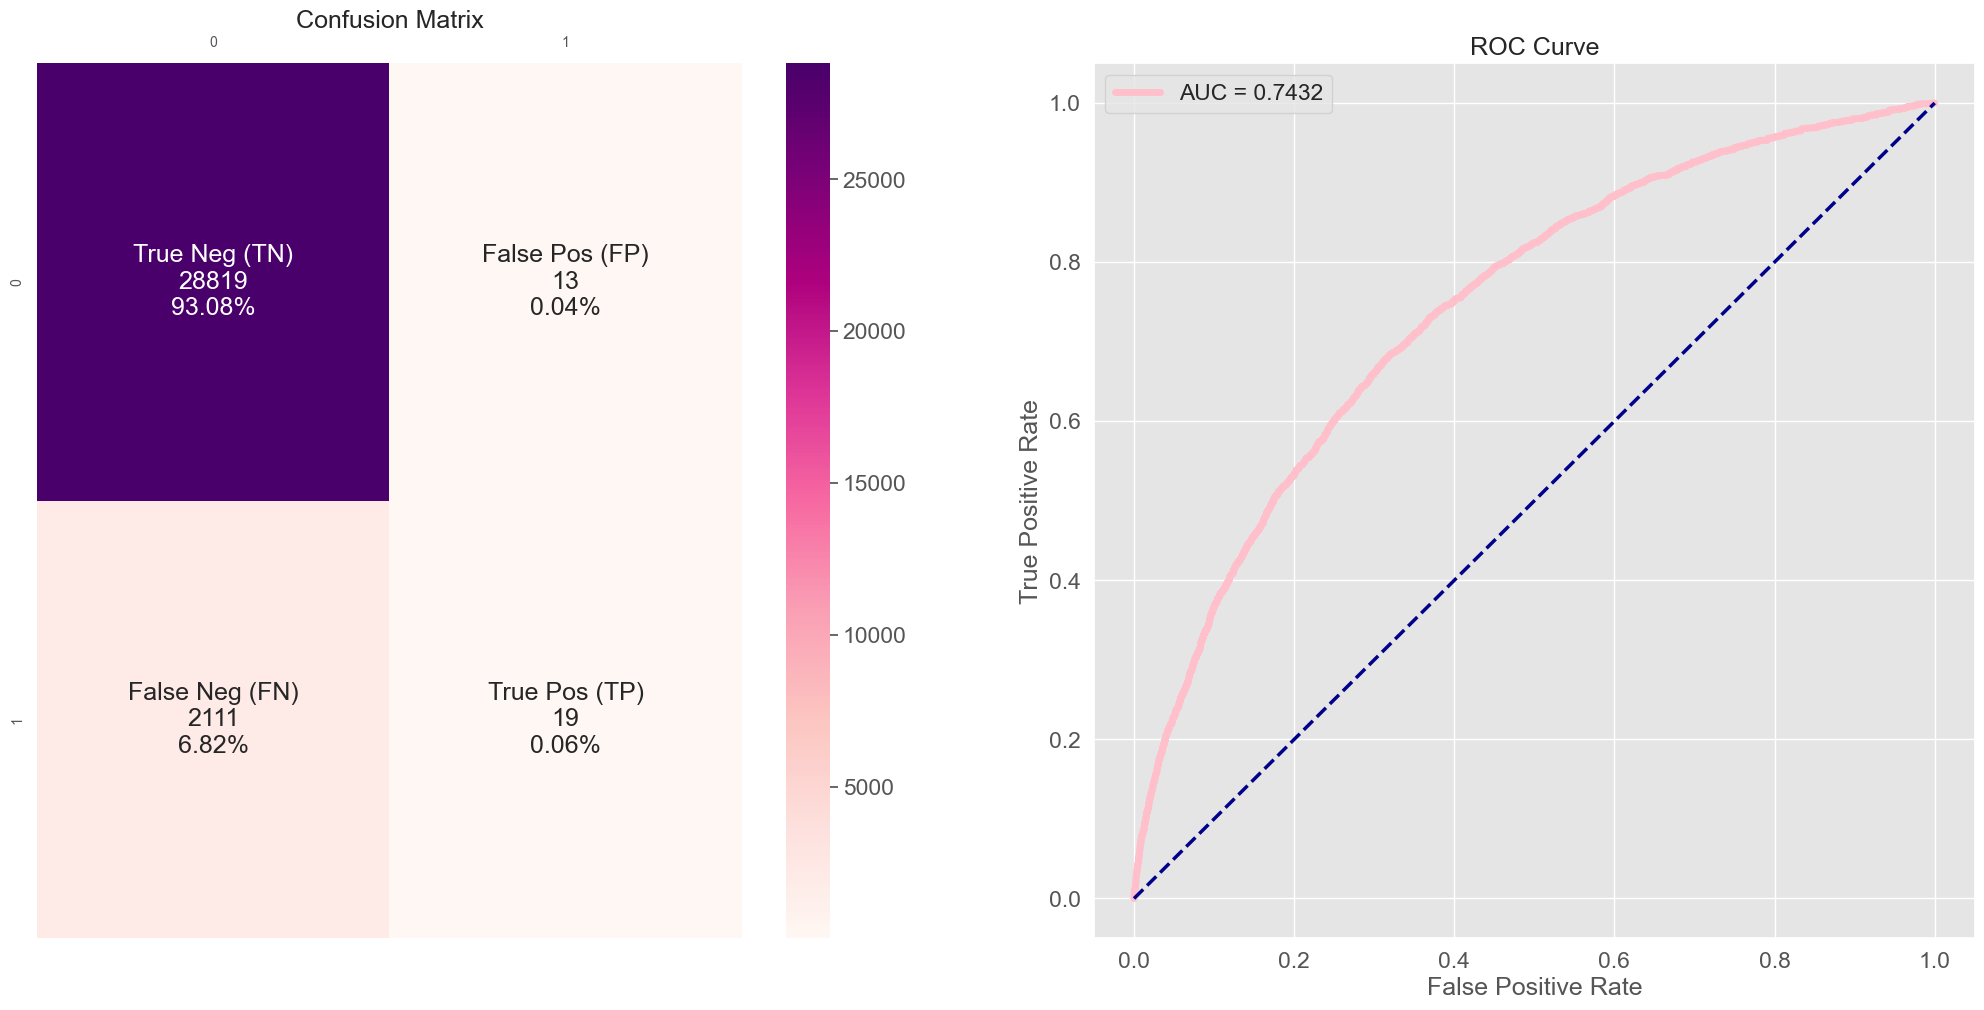

True negative =  28819
False positive =  13
False negative =  2111
True positive =  19
time: 1.3 s (started: 2023-07-04 23:43:42 +02:00)


In [167]:
# Appliquer la fonction "cf_matrix_roc_auc" pour calculer les valeurs des vrais négatifs (TN), faux positifs (FP), faux négatifs (FN) et vrais positifs (TP)
# Les paramètres passés à la fonction sont :
# - "y_test" : les vraies étiquettes de la classe cible
# - "prediction" : les étiquettes prédites par le modèle
# - "probability" : les probabilités de la classe positive prédites par le modèle
# - (25, 25) : la taille de la figure pour afficher la matrice de confusion et la courbe ROC
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (25, 25))


In [168]:
# Appel de la fonction "score_banq" pour calculer le score de gain
# Les paramètres passés à la fonction sont :
# - tn : le nombre de vrais négatifs (True Negatives)
# - fp : le nombre de faux positifs (False Positives)
# - fn : le nombre de faux négatifs (False Negatives)
# - tp : le nombre de vrais positifs (True Positives)
# - 10 : le gain pour un vrai positif (True Positive Gain)
# - -1 : le coût pour un faux positif (False Positive Cost)
# - -100 : le coût pour un faux négatif (False Negative Cost)
# - 0 : le coût pour un vrai négatif (True Negative Cost)
score_gain = score_banq(tn, fp, fn, tp, 10, -1, -100, 0)
score_gain

0.6015425764686354

time: 15 ms (started: 2023-07-04 23:43:43 +02:00)


Le modèle a une performance de plus de 90%. Plus de 90% de nos observations appartiennent à la catégorie 0 (non défaut de paiement), avec une exactitude (accuracy) de plus de 90% (ici 93%). Celà est caractéristique d'un déséquilibre des target. 

Pour pallier à ce déséquilibre, il faut rééquilibrer le jeu de données en faisant class_weight = balanced, de l’undersampling, en enlevant des données de la classe majoritaire, soit en faisant de l’oversampling, en rajoutant des nouvelles données dans la classe minoritaire.

In [169]:
# Ajout des métriques du modèle de régression logistique à la DataFrame
comparison_baseline = pd.DataFrame(
        {
            "Modele": "Baseline - Regression Logistique",
            "Accuracy": accuracy,            # Précision globale du modèle (TP + TN) / (TP + TN + FP + FN)
            "AUC": AUC,                      # Aire sous la courbe ROC du modèle
            "Recall class 1": recall,        # Rappel (recall) de la classe 1 (défaut de paiement) du modèle
            "F1": f1,                        # Score F1, mesure harmonique entre la précision et le rappel
            "TP": tp,                        # Nombre de vrais positifs du modèle (prédictions correctes de la classe 1)
            "Precision": precision,          # Précision du modèle TP / (TP + FP)
            "FN": fn,                        # Nombre de faux négatifs du modèle (prédictions erronées de la classe 1)
            "score Gain": score_gain,        # Score Gain calculé à partir des coûts spécifiés
            "time": prediction_time          # Temps de prédiction pour le modèle
        },
        index=[0],                          # Utilisation de l'index 0 pour ajouter une seule ligne au DataFrame
    )

# Affichage du DataFrame contenant les métriques de performance du modèle de régression logistique
comparison_baseline


,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,score Gain,time
0,Baseline - Regression Logistique,0.9314,0.743208,0.00892,0.017576,19,0.59375,2111,0.601543,0.056971


time: 31 ms (started: 2023-07-04 23:43:43 +02:00)


#### 6.1 LGBMClassifier

In [170]:
# Définition des hyperparamètres optimaux pour le modèle LightGBM
best_params = LGBMClassifier(
    boosting_type='gbdt',  # Type d'algorithme de boosting à utiliser ('gbdt' est l'algorithme de boosting par défaut)
    num_leaves=31,  # Nombre maximal de feuilles dans un arbre (contrôle la complexité de l'arbre)
    max_depth=-1,  # Profondeur maximale des arbres (valeur négative indique aucune limite de profondeur)
    learning_rate=0.01,  # Taux d'apprentissage (contrôle l'ampleur des mises à jour des poids)
    n_estimators=1400,  # Nombre d'arbres (estimateurs) à utiliser dans l'ensemble (boosting)
    subsample_for_bin=200000,  # Nombre d'échantillons à utiliser pour l'histogramme des bins
    objective='binary',  # Fonction objectif à optimiser ('binary' pour la classification binaire)
    class_weight=None,  # Poids des classes ajustés automatiquement pour l'équilibrage des classes
    min_split_gain=0.0,  # Gain minimal requis pour effectuer une séparation lors de la construction d'arbre
    min_child_weight=0.001,  # Poids minimal requis pour les feuilles des arbres
    min_child_samples=20,  # Nombre minimal d'échantillons requis pour une feuille dans un arbre
    subsample=1.0,  # Pourcentage d'échantillons à utiliser pour chaque arbre (1.0 signifie utiliser tous les échantillons)
    subsample_freq=0,  # Fréquence de sous-échantillonnage (0 signifie aucun sous-échantillonnage)
    colsample_bytree=1.0,  # Pourcentage de fonctionnalités à utiliser pour chaque arbre (1.0 signifie utiliser toutes les fonctionnalités)
    reg_alpha=0.0,  # Terme de régularisation L1 pour empêcher le surajustement
    reg_lambda=0.0,  # Terme de régularisation L2 pour empêcher le surajustement
    random_state=None,  # Graine aléatoire pour la reproductibilité des résultats
    n_jobs=-1,  # Nombre de cœurs de processeur à utiliser lors du calcul (-1 signifie utiliser tous les cœurs disponibles)
    silent=True,  # Contrôle la verbosité du modèle (True signifie aucune sortie affichée)
    importance_type='split'  # Méthode pour calculer l'importance des fonctionnalités ('split' utilise le nombre de splits)
)

time: 15 ms (started: 2023-07-04 23:43:43 +02:00)


In [171]:
# Appliquer la fonction "classification" avec les paramètres appropriés
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class= classification(best_params, X_train, y_train, X_test, y_test, "Baseline - LGBMClassifier", file_name=None)

Exécution 
 
       SK_ID_CURR  positive_probability
0          316145              0.053584
1          399406              0.039944
2          168652              0.106685
3          317387              0.055242
4          371921              0.214611
...           ...                   ...
30957      268716              0.056397
30958      398091              0.029055
30959      228535              0.034021
30960      107632              0.044195
30961      343857              0.110094

[30962 rows x 2 columns]
Qualité de la classification 
 
 
L'accuracy score est de 0.9310768038240423 pour la méthode Baseline - LGBMClassifier.
 
 
Le score de précision est de 0.45 pour la méthode Baseline - LGBMClassifier.
 
 
Le score recall est de 0.008450704225352112 pour la méthode Baseline - LGBMClassifier.
 
 
Le score f1 est de 0.016589861751152072 pour la méthode Baseline - LGBMClassifier.
 
 
Le score AUC est de 0.7620790898740575 pour la méthode Baseline - LGBMClassifier.
 
 


Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/07/04 23:44:54 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: CreditModels, version 13


time: 1min 10s (started: 2023-07-04 23:43:44 +02:00)


Created version '13' of model 'CreditModels'.


In [172]:
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
df_matrice_confusion = matrix_TN_FN(y_test, prediction)

# Affichage de la matrice de confusion
print("Matrice de confusion :")
df_matrice_confusion


Matrice de confusion :


,Predicted Negative (0),Predicted Positive (1)
Real Negative (0),28810 (TN),22 (FP)
Real Positive (1),2112 (FN),18 (TP)


time: 31 ms (started: 2023-07-04 23:44:54 +02:00)


In [173]:
# Calcul de l'aire sous la courbe ROC (ROC AUC) à partir des vraies étiquettes "y_test" et des probabilités de la classe positive "probability[:,1]"
# La fonction "roc_auc_score" prend en entrée les vraies étiquettes binaires (0 ou 1) et les probabilités de la classe positive
roc_auc = roc_auc_score(y_test, probability[:,1])

# Affichage de l'aire sous la courbe ROC (ROC AUC)
print('AUC : %0.4f' % roc_auc)

# Affichage du rapport de classification, qui contient différentes métriques pour évaluer les performances du modèle
# Le rapport de classification affiche la précision, le rappel, le score F1 et le support pour chaque classe du modèle (dans ce cas, classe 0 et classe 1)
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
print('Rapport de classification :')
print(classification_report(y_test, prediction))


AUC : 0.7621
Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     28832
         1.0       0.45      0.01      0.02      2130

    accuracy                           0.93     30962
   macro avg       0.69      0.50      0.49     30962
weighted avg       0.90      0.93      0.90     30962

time: 157 ms (started: 2023-07-04 23:44:54 +02:00)


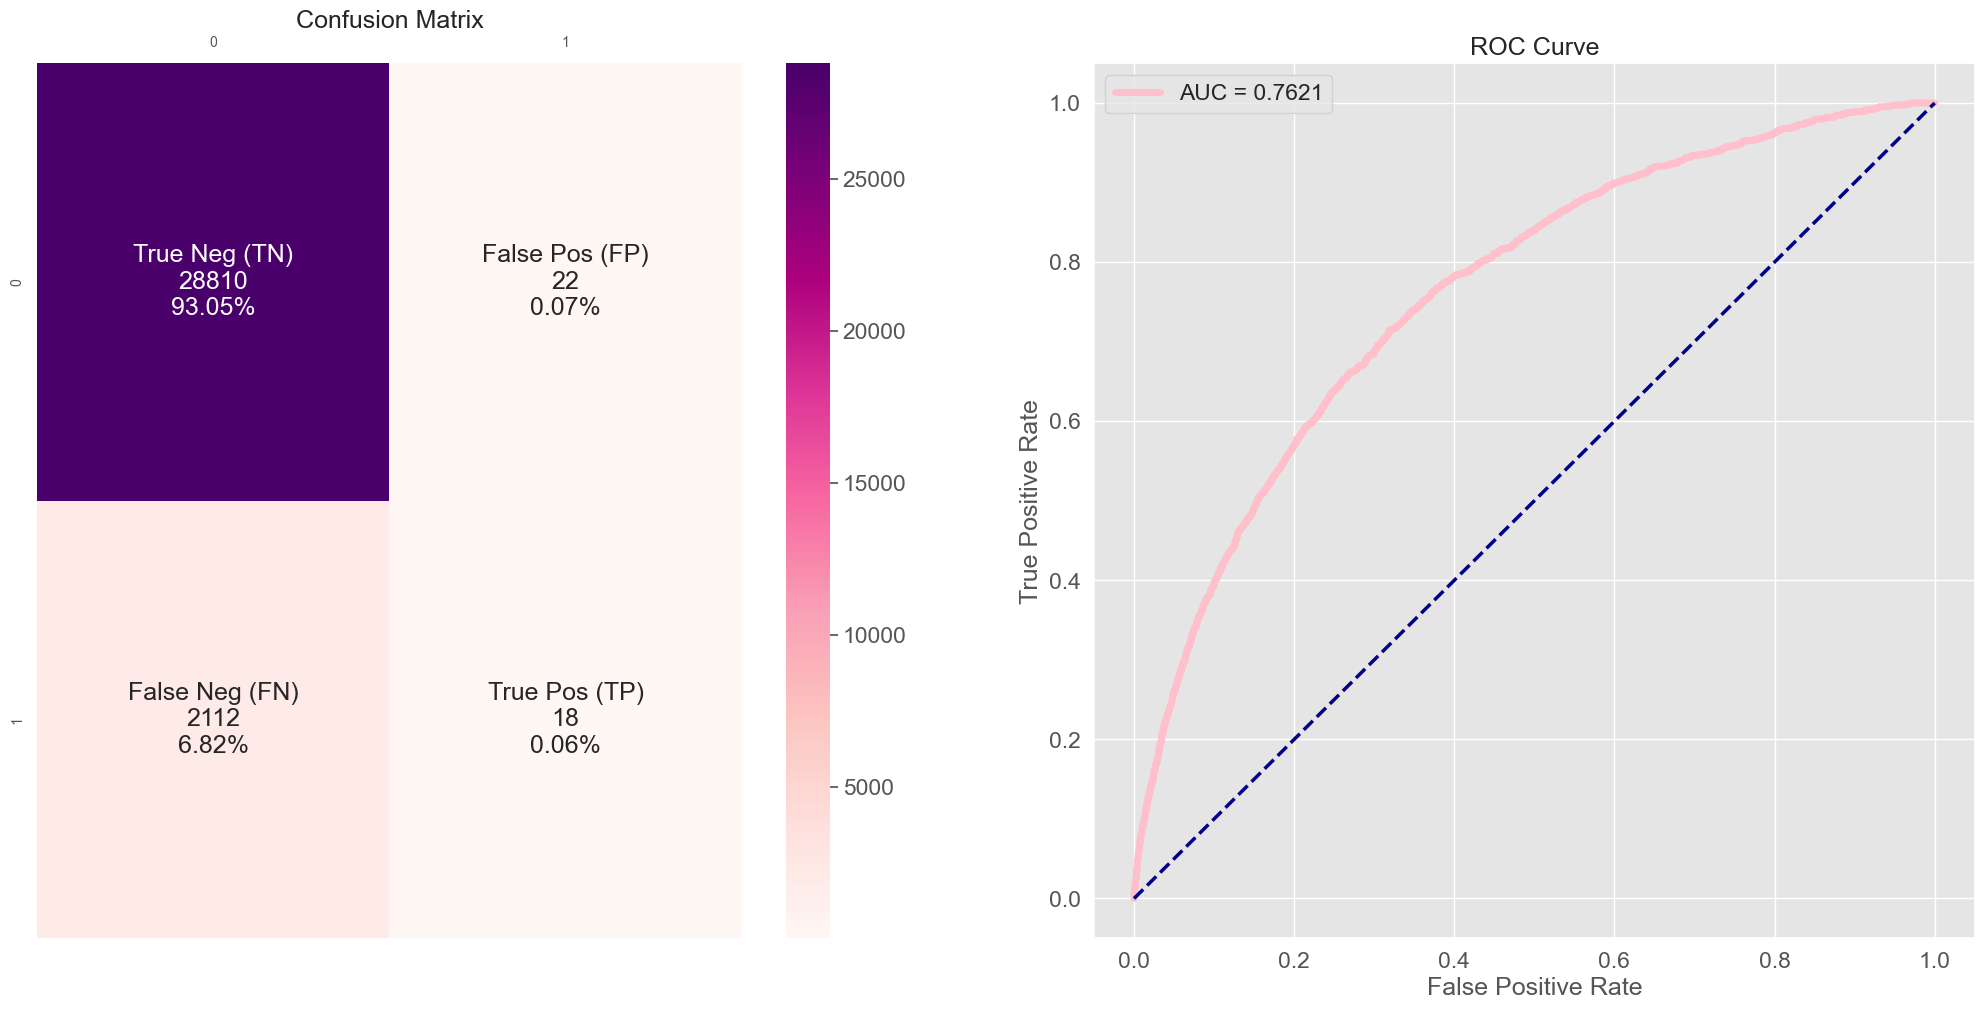

True negative =  28810
False positive =  22
False negative =  2112
True positive =  18
time: 1.08 s (started: 2023-07-04 23:44:54 +02:00)


In [174]:
# Appliquer la fonction "cf_matrix_roc_auc" pour calculer les valeurs des vrais négatifs (TN), faux positifs (FP), faux négatifs (FN) et vrais positifs (TP)
# Les paramètres passés à la fonction sont :
# - "y_test" : les vraies étiquettes de la classe cible
# - "prediction" : les étiquettes prédites par le modèle
# - "probability" : les probabilités de la classe positive prédites par le modèle
# - (25, 25) : la taille de la figure pour afficher la matrice de confusion et la courbe ROC
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (25, 25))


In [175]:
# Appel de la fonction "score_banq" pour calculer le score de gain
# Les paramètres passés à la fonction sont :
# - tn : le nombre de vrais négatifs (True Negatives)
# - fp : le nombre de faux positifs (False Positives)
# - fn : le nombre de faux négatifs (False Negatives)
# - tp : le nombre de vrais positifs (True Positives)
# - 10 : le gain pour un vrai positif (True Positive Gain)
# - -1 : le coût pour un faux positif (False Positive Cost)
# - -100 : le coût pour un faux négatif (False Negative Cost)
# - 0 : le coût pour un vrai négatif (True Negative Cost)
score_gain = score_banq(tn, fp, fn, tp, 10, -1, -100, 0)
score_gain

0.6011672124220978

time: 15 ms (started: 2023-07-04 23:44:55 +02:00)


In [176]:
# Ajout des métriques du modèle LGBMClassifier à la DataFrame comparison_baseline
comparison_baseline_lgbm = pd.DataFrame(
        {
            "Modele": "Baseline - LGBMClassifier",
            "Accuracy": accuracy,            # Précision globale du modèle (TP + TN) / (TP + TN + FP + FN)
            "AUC": AUC,                      # Aire sous la courbe ROC du modèle
            "Recall class 1": recall,        # Rappel (recall) de la classe 1 (défaut de paiement) du modèle
            "F1": f1,                        # Score F1, mesure harmonique entre la précision et le rappel
            "TP": tp,                        # Nombre de vrais positifs du modèle (prédictions correctes de la classe 1)
            "Precision": precision,          # Précision du modèle TP / (TP + FP)
            "FN": fn,                        # Nombre de faux négatifs du modèle (prédictions erronées de la classe 1)
            "score Gain": score_gain,        # Score Gain calculé à partir des coûts spécifiés
            "time": prediction_time          # Temps de prédiction pour le modèle
        },
        index=[1],                          # Utilisation de l'index 1 pour ajouter une deuxième ligne au DataFrame
    )

# Affichage du DataFrame contenant les métriques de performance pour les deux modèles (Régression logistique et LGBMClassifier)
comparison_baseline = pd.concat([comparison_baseline, comparison_baseline_lgbm])
comparison_baseline

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,score Gain,time
0,Baseline - Regression Logistique,0.931400,0.743208,0.008920,0.017576,19,0.59375,2111,0.601543,0.056971
1,Baseline - LGBMClassifier,0.931077,0.762079,0.008451,0.016590,18,0.45000,2112,0.601167,3.216664


time: 31 ms (started: 2023-07-04 23:44:55 +02:00)


### 7 - Traitement de la classification déséquilibrée

#### 7.1 Class_weight
 avec le paramètre : class_weight=’balanced’

##### 7.1.1 Régression logistique 

In [177]:
# Définition des hyperparamètres optimaux pour le modèle de régression logistique
best_params = LogisticRegression(
    C=0.1,  # Paramètre de régularisation inverse (plus petit est C, plus forte est la régularisation)
    class_weight='balanced',  # Poids des classes ajustés automatiquement pour l'équilibrage des classes
    dual=False,  # Contrainte de dualité (utilisé pour de petites tailles d'échantillons et lorsque le nombre de fonctionnalités est supérieur au nombre d'échantillons)
    fit_intercept=True,  # Indique si une constante (intercept) doit être ajoutée à la fonction de décision
    intercept_scaling=1,  # Paramètre de mise à l'échelle de l'intercept
    l1_ratio=None,  # Paramètre pour la régularisation L1 (None signifie pas de régularisation L1)
    max_iter=100,  # Nombre maximum d'itérations pour la convergence
    multi_class='auto',  # Contrôle la stratégie de résolution du problème de classification multiclasse
    n_jobs=None,  # Nombre de cœurs de processeur à utiliser lors du calcul (None signifie un seul cœur)
    penalty='l2',  # Type de régularisation à utiliser (l2 indique une régularisation L2)
    random_state=42,  # Graine aléatoire pour la reproductibilité des résultats
    solver='lbfgs',  # Algorithme à utiliser pour l'optimisation (lbfgs est un algorithme de descente de gradient limité)
    tol=0.0001,  # Tolérance pour la convergence
    verbose=0,  # Contrôle la verbosité lors de l'ajustement (0 signifie aucune sortie affichée)
    warm_start=False  # Contrôle la réutilisation de la solution précédente pour l'initialisation
)


time: 0 ns (started: 2023-07-04 23:44:55 +02:00)


In [178]:
# Appliquer la fonction "classification" avec les paramètres appropriés
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class = classification(best_params, X_train, y_train, X_test, y_test, "Class Weight - Regression logistique", file_name=None)

Exécution 
 


       SK_ID_CURR  positive_probability
0          316145              0.330238
1          399406              0.317257
2          168652              0.582046
3          317387              0.219964
4          371921              0.709488
...           ...                   ...
30957      268716              0.443906
30958      398091              0.171563
30959      228535              0.299460
30960      107632              0.368298
30961      343857              0.663082

[30962 rows x 2 columns]
Qualité de la classification 
 
 
L'accuracy score est de 0.6882630321038693 pour la méthode Class Weight - Regression logistique.
 
 
Le score de précision est de 0.1374590321958743 pour la méthode Class Weight - Regression logistique.
 
 
Le score recall est de 0.6694835680751173 pour la méthode Class Weight - Regression logistique.
 
 
Le score f1 est de 0.22808701215611002 pour la méthode Class Weight - Regression logistique.
 
 
Le score AUC est de 0.7431273220157051 pour la méthode C

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/07/04 23:45:10 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: CreditModels, version 14


time: 15 s (started: 2023-07-04 23:44:55 +02:00)


Created version '14' of model 'CreditModels'.


In [179]:
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
df_matrice_confusion = matrix_TN_FN(y_test, prediction)

# Affichage de la matrice de confusion
print("Matrice de confusion :")
df_matrice_confusion

Matrice de confusion :


,Predicted Negative (0),Predicted Positive (1)
Real Negative (0),19884 (TN),8948 (FP)
Real Positive (1),704 (FN),1426 (TP)


time: 15 ms (started: 2023-07-04 23:45:10 +02:00)


In [180]:
# Calcul de l'aire sous la courbe ROC (ROC AUC) à partir des vraies étiquettes "y_test" et des probabilités de la classe positive "probability[:,1]"
# La fonction "roc_auc_score" prend en entrée les vraies étiquettes binaires (0 ou 1) et les probabilités de la classe positive
roc_auc = roc_auc_score(y_test, probability[:,1])

# Affichage de l'aire sous la courbe ROC (ROC AUC)
print('AUC : %0.4f' % roc_auc)

# Affichage du rapport de classification, qui contient différentes métriques pour évaluer les performances du modèle
# Le rapport de classification affiche la précision, le rappel, le score F1 et le support pour chaque classe du modèle (dans ce cas, classe 0 et classe 1)
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
print('Rapport de classification :')
print(classification_report(y_test, prediction))

AUC : 0.7431
Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.97      0.69      0.80     28832
         1.0       0.14      0.67      0.23      2130

    accuracy                           0.69     30962
   macro avg       0.55      0.68      0.52     30962
weighted avg       0.91      0.69      0.77     30962

time: 125 ms (started: 2023-07-04 23:45:10 +02:00)


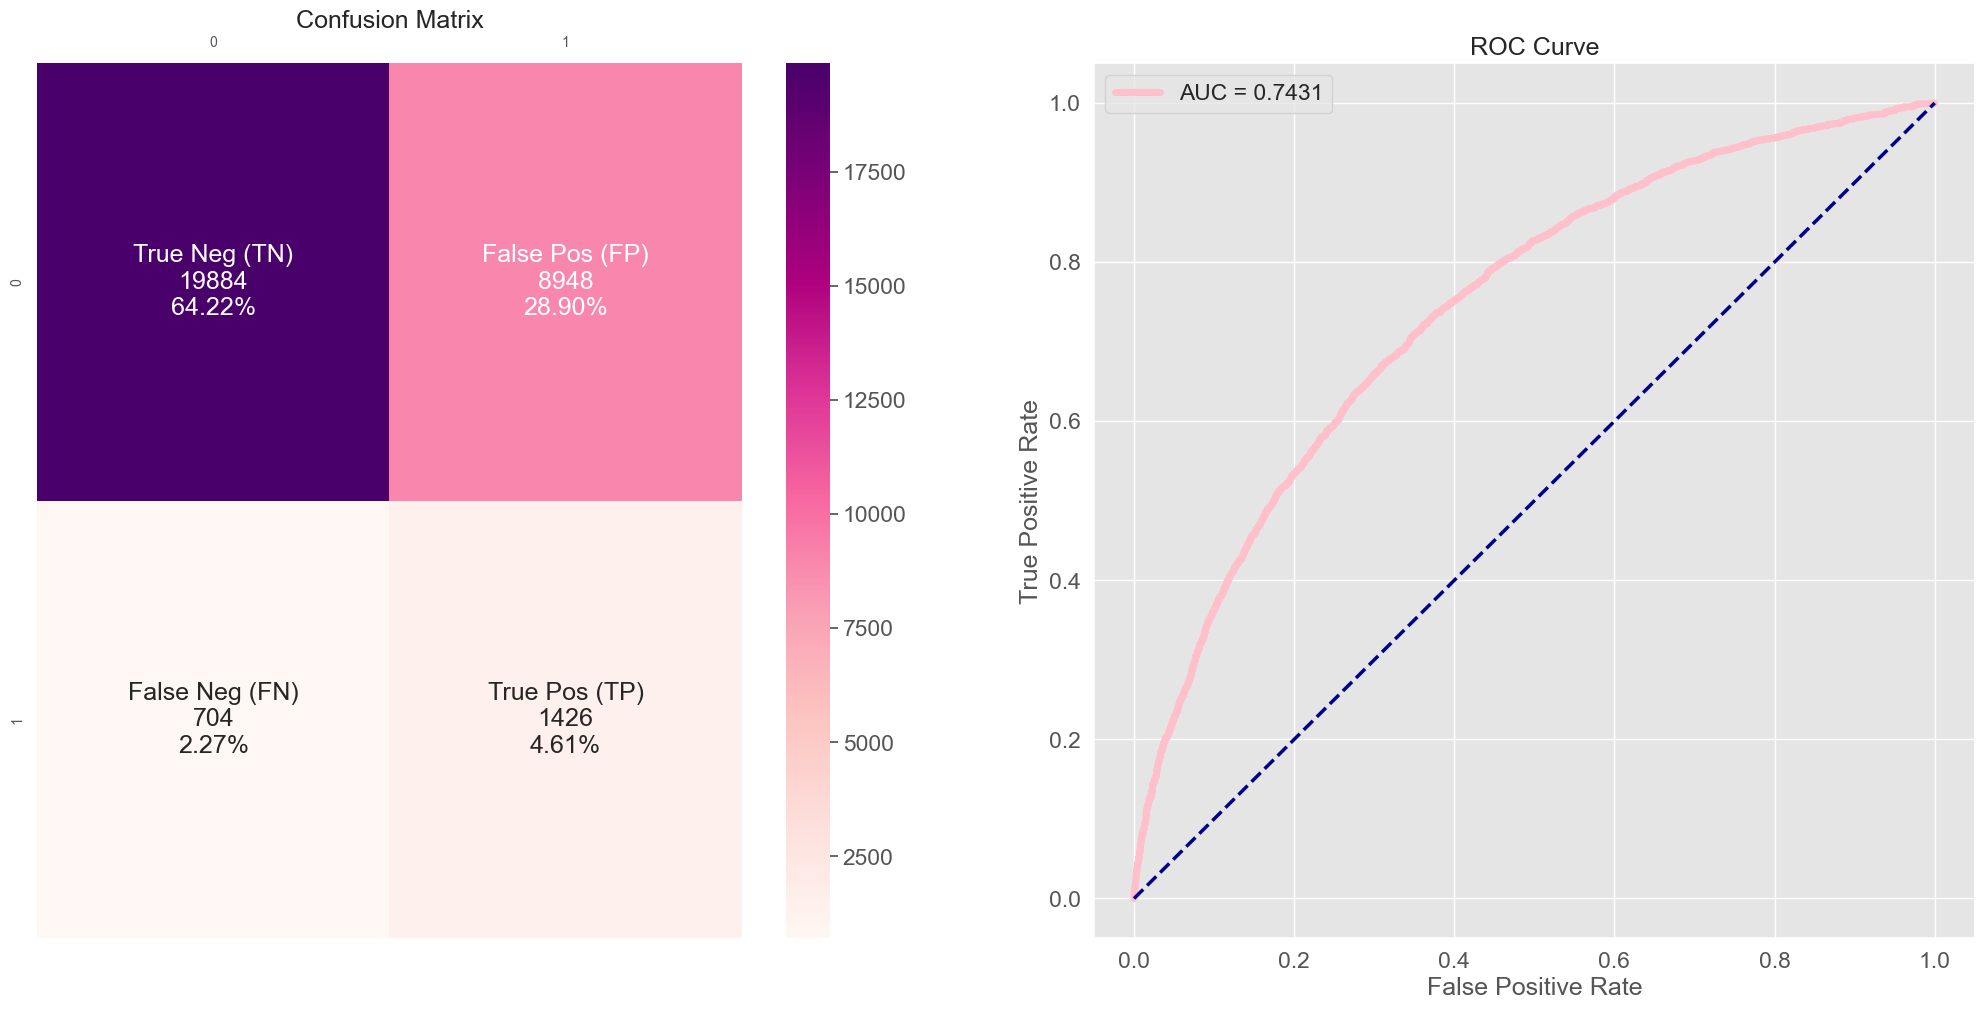

True negative =  19884
False positive =  8948
False negative =  704
True positive =  1426
time: 1.22 s (started: 2023-07-04 23:45:10 +02:00)


In [181]:
# Appliquer la fonction "cf_matrix_roc_auc" pour calculer les valeurs des vrais négatifs (TN), faux positifs (FP), faux négatifs (FN) et vrais positifs (TP)
# Les paramètres passés à la fonction sont :
# - "y_test" : les vraies étiquettes de la classe cible
# - "prediction" : les étiquettes prédites par le modèle
# - "probability" : les probabilités de la classe positive prédites par le modèle
# - (25, 25) : la taille de la figure pour afficher la matrice de confusion et la courbe ROC
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (25, 25))


In [182]:
# Appel de la fonction "score_banq" pour calculer le score de gain
# Les paramètres passés à la fonction sont :
# - tn : le nombre de vrais négatifs (True Negatives)
# - fp : le nombre de faux positifs (False Positives)
# - fn : le nombre de faux négatifs (False Negatives)
# - tp : le nombre de vrais positifs (True Positives)
# - 10 : le gain pour un vrai positif (True Positive Gain)
# - -1 : le coût pour un faux positif (False Positive Cost)
# - -100 : le coût pour un faux négatif (False Negative Cost)
# - 0 : le coût pour un vrai négatif (True Negative Cost)
score_gain = score_banq(tn, fp, fn, tp, 10, -1, -100, 0)
score_gain

0.6815479334228675

time: 0 ns (started: 2023-07-04 23:45:12 +02:00)


In [183]:
# Ajout des métriques du modèle de régression logistique à la DataFrame
comparison_class_weight_rl = pd.DataFrame(
        {
            "Modele": "Class Weight - Regression Logistique",
            "Accuracy": accuracy,            # Précision globale du modèle (TP + TN) / (TP + TN + FP + FN)
            "AUC": AUC,                      # Aire sous la courbe ROC du modèle
            "Recall class 1": recall,        # Rappel (recall) de la classe 1 (défaut de paiement) du modèle
            "F1": f1,                        # Score F1, mesure harmonique entre la précision et le rappel
            "TP": tp,                        # Nombre de vrais positifs du modèle (prédictions correctes de la classe 1)
            "Precision": precision,          # Précision du modèle TP / (TP + FP)
            "FN": fn,                        # Nombre de faux négatifs du modèle (prédictions erronées de la classe 1)
            "score Gain": score_gain,        # Score Gain calculé à partir des coûts spécifiés
            "time": prediction_time          # Temps de prédiction pour le modèle
        },
        index=[2],                          # Utilisation de l'index 0 pour ajouter une seule ligne au DataFrame
    )

# Affichage du DataFrame contenant les métriques de performance du modèle de régression logistique
comparison_model = pd.concat([comparison_baseline, comparison_class_weight_rl])
comparison_model

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,score Gain,time
0,Baseline - Regression Logistique,0.931400,0.743208,0.008920,0.017576,19,0.593750,2111,0.601543,0.056971
1,Baseline - LGBMClassifier,0.931077,0.762079,0.008451,0.016590,18,0.450000,2112,0.601167,3.216664
2,Class Weight - Regression Logistique,0.688263,0.743127,0.669484,0.228087,1426,0.137459,704,0.681548,0.073802


time: 31 ms (started: 2023-07-04 23:45:12 +02:00)


##### 7.1.2 LGBMClassifier

In [184]:
# Définition des hyperparamètres optimaux pour le modèle LightGBM
best_params = LGBMClassifier(
    boosting_type='gbdt',  # Type d'algorithme de boosting à utiliser ('gbdt' est l'algorithme de boosting par défaut)
    num_leaves=31,  # Nombre maximal de feuilles dans un arbre (contrôle la complexité de l'arbre)
    max_depth=-1,  # Profondeur maximale des arbres (valeur négative indique aucune limite de profondeur)
    learning_rate=0.01,  # Taux d'apprentissage (contrôle l'ampleur des mises à jour des poids)
    n_estimators=1400,  # Nombre d'arbres (estimateurs) à utiliser dans l'ensemble (boosting)
    subsample_for_bin=200000,  # Nombre d'échantillons à utiliser pour l'histogramme des bins
    objective='binary',  # Fonction objectif à optimiser ('binary' pour la classification binaire)
    class_weight='balanced',  # Poids des classes ajustés automatiquement pour l'équilibrage des classes
    min_split_gain=0.0,  # Gain minimal requis pour effectuer une séparation lors de la construction d'arbre
    min_child_weight=0.001,  # Poids minimal requis pour les feuilles des arbres
    min_child_samples=20,  # Nombre minimal d'échantillons requis pour une feuille dans un arbre
    subsample=1.0,  # Pourcentage d'échantillons à utiliser pour chaque arbre (1.0 signifie utiliser tous les échantillons)
    subsample_freq=0,  # Fréquence de sous-échantillonnage (0 signifie aucun sous-échantillonnage)
    colsample_bytree=1.0,  # Pourcentage de fonctionnalités à utiliser pour chaque arbre (1.0 signifie utiliser toutes les fonctionnalités)
    reg_alpha=0.0,  # Terme de régularisation L1 pour empêcher le surajustement
    reg_lambda=0.0,  # Terme de régularisation L2 pour empêcher le surajustement
    random_state=None,  # Graine aléatoire pour la reproductibilité des résultats
    n_jobs=-1,  # Nombre de cœurs de processeur à utiliser lors du calcul (-1 signifie utiliser tous les cœurs disponibles)
    silent=True,  # Contrôle la verbosité du modèle (True signifie aucune sortie affichée)
    importance_type='split'  # Méthode pour calculer l'importance des fonctionnalités ('split' utilise le nombre de splits)
)


time: 0 ns (started: 2023-07-04 23:45:12 +02:00)


In [185]:
# Appliquer la fonction "classification" avec les paramètres appropriés
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class= classification(best_params, X_train, y_train, X_test, y_test, "Class Weight - LGBMClassifier", file_name=None)

Exécution 
 


       SK_ID_CURR  positive_probability
0          316145              0.274886
1          399406              0.344664
2          168652              0.498756
3          317387              0.268571
4          371921              0.757793
...           ...                   ...
30957      268716              0.344425
30958      398091              0.352218
30959      228535              0.248037
30960      107632              0.358246
30961      343857              0.545916

[30962 rows x 2 columns]
Qualité de la classification 
 
 
L'accuracy score est de 0.7424261998578903 pour la méthode Class Weight - LGBMClassifier.
 
 
Le score de précision est de 0.15862632869991825 pour la méthode Class Weight - LGBMClassifier.
 
 
Le score recall est de 0.6375586854460094 pour la méthode Class Weight - LGBMClassifier.
 
 
Le score f1 est de 0.2540454587971191 pour la méthode Class Weight - LGBMClassifier.
 
 
Le score AUC est de 0.7608281812592164 pour la méthode Class Weight - LGBMClassifier

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/07/04 23:46:15 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: CreditModels, version 15
Created version '15' of model 'CreditModels'.


time: 1min 3s (started: 2023-07-04 23:45:12 +02:00)


In [186]:
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
df_matrice_confusion = matrix_TN_FN(y_test, prediction)

# Affichage de la matrice de confusion
print("Matrice de confusion :")
df_matrice_confusion

Matrice de confusion :


,Predicted Negative (0),Predicted Positive (1)
Real Negative (0),21629 (TN),7203 (FP)
Real Positive (1),772 (FN),1358 (TP)


time: 16 ms (started: 2023-07-04 23:46:15 +02:00)


In [187]:
# Calcul de l'aire sous la courbe ROC (ROC AUC) à partir des vraies étiquettes "y_test" et des probabilités de la classe positive "probability[:,1]"
# La fonction "roc_auc_score" prend en entrée les vraies étiquettes binaires (0 ou 1) et les probabilités de la classe positive
roc_auc = roc_auc_score(y_test, probability[:,1])

# Affichage de l'aire sous la courbe ROC (ROC AUC)
print('AUC : %0.4f' % roc_auc)

# Affichage du rapport de classification, qui contient différentes métriques pour évaluer les performances du modèle
# Le rapport de classification affiche la précision, le rappel, le score F1 et le support pour chaque classe du modèle (dans ce cas, classe 0 et classe 1)
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
print('Rapport de classification :')
print(classification_report(y_test, prediction))

AUC : 0.7608
Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.97      0.75      0.84     28832
         1.0       0.16      0.64      0.25      2130

    accuracy                           0.74     30962
   macro avg       0.56      0.69      0.55     30962
weighted avg       0.91      0.74      0.80     30962

time: 109 ms (started: 2023-07-04 23:46:15 +02:00)


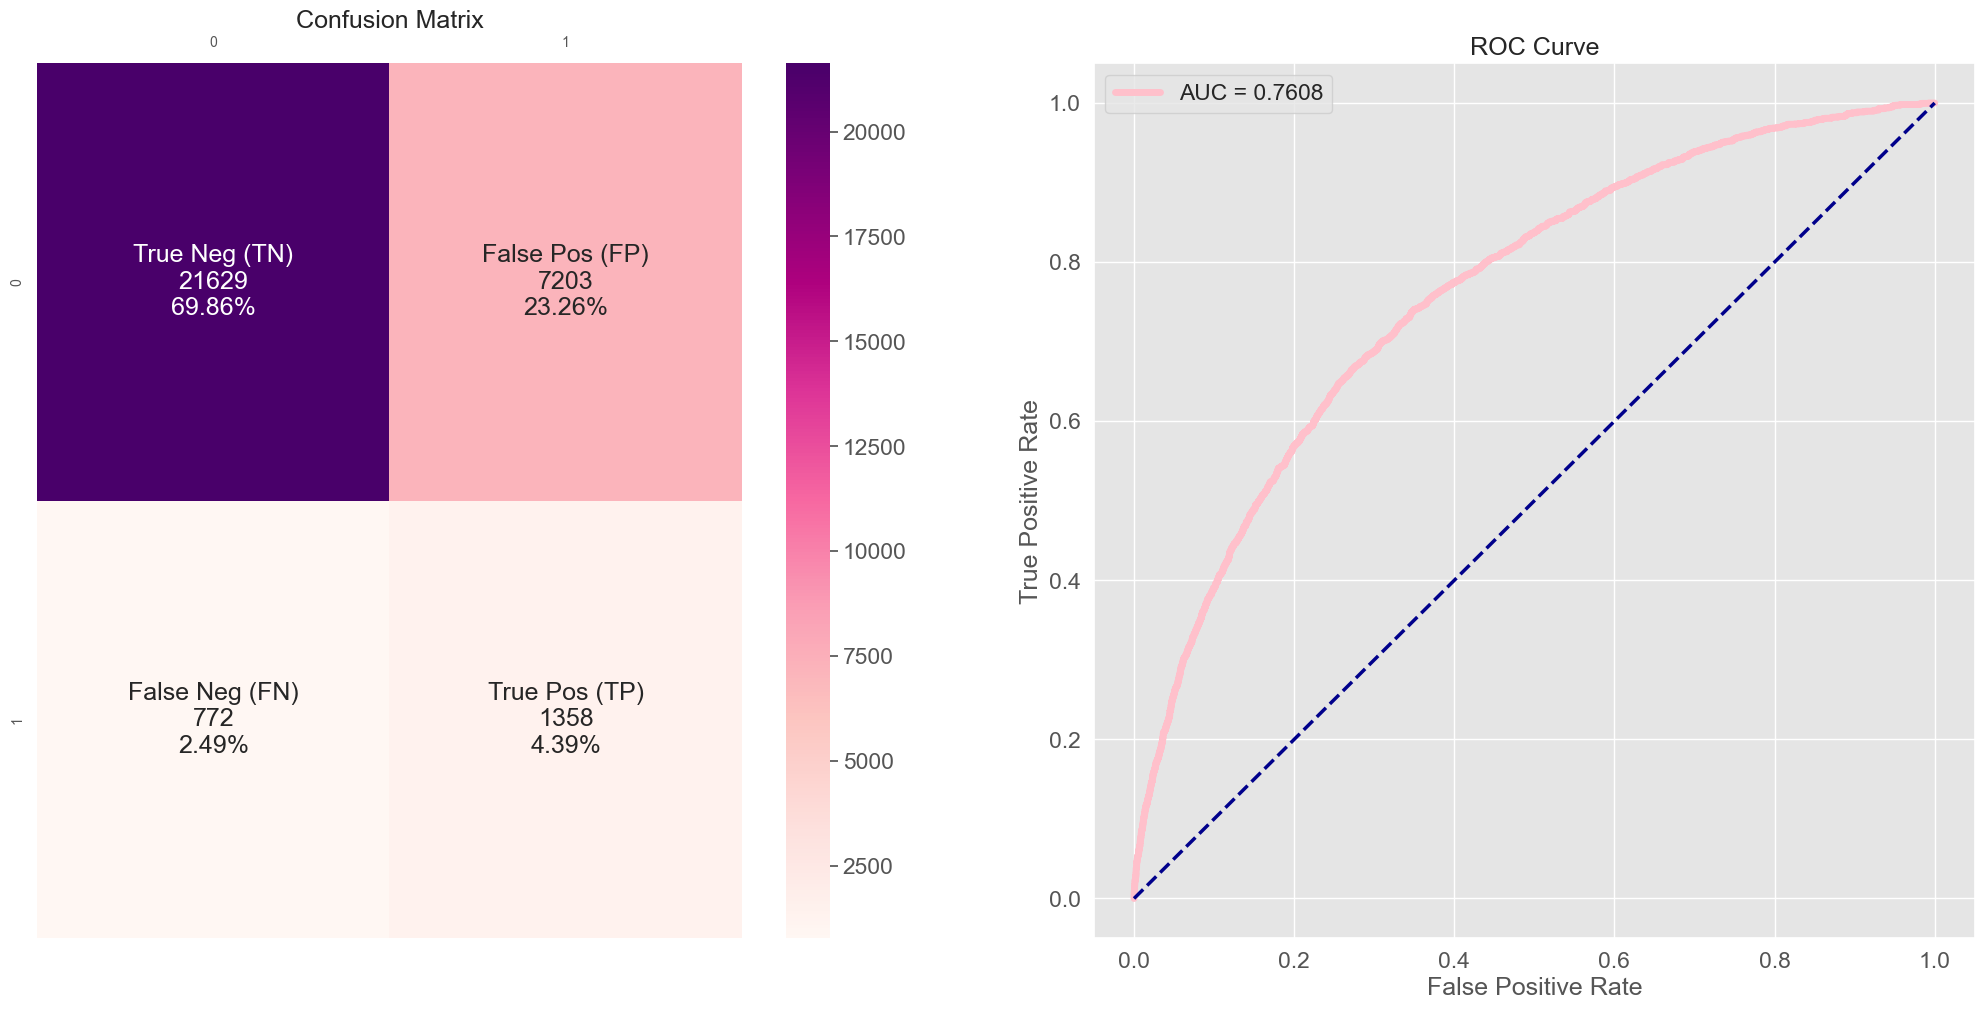

True negative =  21629
False positive =  7203
False negative =  772
True positive =  1358
time: 890 ms (started: 2023-07-04 23:46:15 +02:00)


In [188]:
# Appliquer la fonction "cf_matrix_roc_auc" pour calculer les valeurs des vrais négatifs (TN), faux positifs (FP), faux négatifs (FN) et vrais positifs (TP)
# Les paramètres passés à la fonction sont :
# - "y_test" : les vraies étiquettes de la classe cible
# - "prediction" : les étiquettes prédites par le modèle
# - "probability" : les probabilités de la classe positive prédites par le modèle
# - (25, 25) : la taille de la figure pour afficher la matrice de confusion et la courbe ROC
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (25, 25))


In [189]:
# Appel de la fonction "score_banq" pour calculer le score de gain
# Les paramètres passés à la fonction sont :
# - tn : le nombre de vrais négatifs (True Negatives)
# - fp : le nombre de faux positifs (False Positives)
# - fn : le nombre de faux négatifs (False Negatives)
# - tp : le nombre de vrais positifs (True Positives)
# - 10 : le gain pour un vrai positif (True Positive Gain)
# - -1 : le coût pour un faux positif (False Positive Cost)
# - -100 : le coût pour un faux négatif (False Negative Cost)
# - 0 : le coût pour un vrai négatif (True Negative Cost)
score_gain = score_banq(tn, fp, fn, tp, 10, -1, -100, 0)
score_gain

0.7049280206431363

time: 0 ns (started: 2023-07-04 23:46:16 +02:00)


In [190]:
comparison_class_weight_lgbm = pd.DataFrame(
        {
         "Modele": "Class Weight - LGBMClassifier",
         "Accuracy": accuracy,
         "AUC": AUC,
         "Recall class 1":recall,
         "F1":f1,   
         "TP":tp,
         "Precision":precision,
         "FN":fn,
         "score Gain":score_gain,
         "time": prediction_time
        },
        index=[3],
    )

# Affichage du DataFrame contenant les métriques de performance du modèle de régression logistique
comparison_model = pd.concat([comparison_model, comparison_class_weight_lgbm])
comparison_model

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,score Gain,time
0,Baseline - Regression Logistique,0.931400,0.743208,0.008920,0.017576,19,0.593750,2111,0.601543,0.056971
1,Baseline - LGBMClassifier,0.931077,0.762079,0.008451,0.016590,18,0.450000,2112,0.601167,3.216664
2,Class Weight - Regression Logistique,0.688263,0.743127,0.669484,0.228087,1426,0.137459,704,0.681548,0.073802
3,Class Weight - LGBMClassifier,0.742426,0.760828,0.637559,0.254045,1358,0.158626,772,0.704928,2.328351


time: 15 ms (started: 2023-07-04 23:46:16 +02:00)


#### 7.2 Undersampling / sous-échantillonnage aléatoires

La sous-échantillonnage aléatoire consiste à retirer aléatoirement des échantillons de la classe majoritaire afin qu'elle ait autant
d'exemples que la classe minoritaire

##### 7.2.1 Mise en place

Supprimez aléatoirement les exemples de la classe majoritaire. Le sous-échantillonnage aléatoire consiste à sélectionner au hasard des exemples de la classe majoritaire et à les supprimer de l'ensemble de données d'apprentissage.

In [191]:
# importer "RandomUnderSampler" pour effectuer une sous-échantillonnage 
# aléatoire des échantillons de la classe majoritaire dans un jeu de données déséquilibré
from imblearn.under_sampling import RandomUnderSampler

time: 0 ns (started: 2023-07-04 23:46:16 +02:00)


In [192]:
print(f"Label 1, Avant d'utiliser RandomUnderSampler: {sum(y_train==1)} ")
print(f"Label 0, Avant d'utiliser RandomUnderSampler: {sum(y_train==0)} ")

Label 1, Avant d'utiliser RandomUnderSampler: 8654 
Label 0, Avant d'utiliser RandomUnderSampler: 115191 
time: 47 ms (started: 2023-07-04 23:51:08 +02:00)


In [193]:
# Création d'une instance de RandomUnderSampler avec un random_state fixé à 0 pour la reproductibilité
rus = RandomUnderSampler(random_state=0)

# Application du sous-échantillonnage aléatoire aux données d'entraînement X_train et y_train
# Les données sous-échantillonnées équilibrées sont stockées dans X_train_undersampled et y_train_undersampled
X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train, y_train)

# Conversion des données sous-échantillonnées en DataFrame pandas
# Cela permet de garder les noms de colonnes de X_train pour faciliter l'utilisation ultérieure
X_train_undersampled = pd.DataFrame(X_train_undersampled, columns=X_train.columns)


time: 500 ms (started: 2023-07-04 23:56:20 +02:00)


In [194]:
print(f"Label 1, Après avoir utilisé RandomUnderSampler: {sum(y_train_undersampled==1)}")
print(f"Label 0, Après avoir utilisé RandomUnderSampler: {sum(y_train_undersampled==0)}")

Label 1, Après avoir utilisé RandomUnderSampler: 8654
Label 0, Après avoir utilisé RandomUnderSampler: 8654
time: 16 ms (started: 2023-07-04 23:56:27 +02:00)


In [195]:
X_train_undersampled

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,EMERGENCYSTATE_MODE,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,...,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business_Entity_Type_1,ORGANIZATION_TYPE_Business_Entity_Type_2,ORGANIZATION_TYPE_Business_Entity_Type_3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry_type_1,ORGANIZATION_TYPE_Industry_type_10,ORGANIZATION_TYPE_Industry_type_11,ORGANIZATION_TYPE_Industry_type_12,ORGANIZATION_TYPE_Industry_type_13,ORGANIZATION_TYPE_Industry_type_2,ORGANIZATION_TYPE_Industry_type_3,ORGANIZATION_TYPE_Industry_type_4,ORGANIZATION_TYPE_Industry_type_5,ORGANIZATION_TYPE_Industry_type_6,ORGANIZATION_TYPE_Industry_type_7,ORGANIZATION_TYPE_Industry_type_9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal_Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security_Ministries,ORGANIZATION_TYPE_Selfemployed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade_type_1,ORGANIZATION_TYPE_Trade_type_2,ORGANIZATION_TYPE_Trade_type_3,ORGANIZATION_TYPE_Trade_type_4,ORGANIZATION_TYPE_Trade_type_5,ORGANIZATION_TYPE_Trade_type_6,ORGANIZATION_TYPE_Trade_type_7,ORGANIZATION_TYPE_Transport_type_1,ORGANIZATION_TYPE_Transport_type_2,ORGANIZATION_TYPE_Transport_type_3,ORGANIZATION_TYPE_Transport_type_4,ORGANIZATION_TYPE_University,HOUSETYPE_MODE_block_of_flats,HOUSETYPE_MODE_specific_housing,HOUSETYPE_MODE_terraced_house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,WALLSMATERIAL_MODE_Stone_brick,WALLSMATERIAL_MODE_Wooden,MOST_CREDIT_TYPE_Another_type_of_loan,MOST_CREDIT_TYPE_Car_loan,MOST_CREDIT_TYPE_Consumer_credit,MOST_CREDIT_TYPE_Credit_card,MOST_CREDIT_TYPE_Loan_for_business_development,MOST_CREDIT_TYPE_Loan_for_working_capital_replenishment,MOST_CREDIT_TYPE_Microloan,MOST_CREDIT_TYPE_Mortgage
0,0,1,1,0,0,-0.573222,-0.144815,-0.565139,-1.142550,-0.800416,0.018732,-1.090908,-0.853139,1.039624,-0.273951,0.002542,0.458151,-0.46321,0.047807,-0.671139,-0.267116,-0.108965,0.032789,0.100683,0.510382,-0.110786,-0.220085,-0.202500,-0.193282,-0.370518,-0.338066,-0.347398,0.148958,-0.635273,-0.187222,0.124243,-0.597191,-0.119930,-0.705778,0

time: 734 ms (started: 2023-07-04 23:57:21 +02:00)


##### 7.2.2 Régression logistique

In [197]:
# Fixer les valeurs des hyperparamètres à tester
param_grid = {"C":[-0.001, -0.01, -0.1, 1, 0.1, 0.01, 0.001, 5, 10, 15, 50, 100]} 
        

# Choisir un score à optimiser
score = 'roc_auc'


# définir le modèle/ estimateur
model = LogisticRegression(random_state=42)

# définir le grid search
lr= GridSearchCV(model, param_grid, scoring=score, cv=4, n_jobs=-1, verbose=2)  #cv : number of cross validation RandomizedSearchCV

# Optimiser ce régresseur sur le jeu d'entraînement
lr.fit(X_train_undersampled, y_train_undersampled)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :")
best_params = lr.best_params_
print(best_params)
print(' ')
print("Meilleur(s) score sur le jeu d'entraînement (roc_auc):")
print(lr.best_score_)

Fitting 4 folds for each of 12 candidates, totalling 48 fits
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :
{'C': 0.1}
 
Meilleur(s) score sur le jeu d'entraînement (roc_auc):
0.736198365982073
time: 23.8 s (started: 2023-07-05 00:05:43 +02:00)


In [198]:
# Définition des hyperparamètres optimaux pour le modèle de régression logistique
best_params = LogisticRegression(
    C=0.1,  # Paramètre de régularisation inverse (plus petit est C, plus forte est la régularisation)
    class_weight=None,  # Poids des classes ajustés automatiquement pour l'équilibrage des classes
    dual=False,  # Contrainte de dualité (utilisé pour de petites tailles d'échantillons et lorsque le nombre de fonctionnalités est supérieur au nombre d'échantillons)
    fit_intercept=True,  # Indique si une constante (intercept) doit être ajoutée à la fonction de décision
    intercept_scaling=1,  # Paramètre de mise à l'échelle de l'intercept
    l1_ratio=None,  # Paramètre pour la régularisation L1 (None signifie pas de régularisation L1)
    max_iter=100,  # Nombre maximum d'itérations pour la convergence
    multi_class='auto',  # Contrôle la stratégie de résolution du problème de classification multiclasse
    n_jobs=None,  # Nombre de cœurs de processeur à utiliser lors du calcul (None signifie un seul cœur)
    penalty='l2',  # Type de régularisation à utiliser (l2 indique une régularisation L2)
    random_state=42,  # Graine aléatoire pour la reproductibilité des résultats
    solver='lbfgs',  # Algorithme à utiliser pour l'optimisation (lbfgs est un algorithme de descente de gradient limité)
    tol=0.0001,  # Tolérance pour la convergence
    verbose=0,  # Contrôle la verbosité lors de l'ajustement (0 signifie aucune sortie affichée)
    warm_start=False  # Contrôle la réutilisation de la solution précédente pour l'initialisation
)


time: 0 ns (started: 2023-07-05 00:09:30 +02:00)


In [199]:
# Appliquer la fonction "classification" avec les paramètres appropriés
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class= classification(best_params, X_train_undersampled, y_train_undersampled, X_test, y_test, "RandomUnderSampler Regression logistique", file_name=None)

Exécution 
 
       SK_ID_CURR  positive_probability
0          316145              0.325709
1          399406              0.288013
2          168652              0.608467
3          317387              0.257283
4          371921              0.605876
...           ...                   ...
30957      268716              0.484866
30958      398091              0.187941
30959      228535              0.316981
30960      107632              0.391851
30961      343857              0.659433

[30962 rows x 2 columns]
Qualité de la classification 
 
 
L'accuracy score est de 0.6784768425812286 pour la méthode RandomUnderSampler Regression logistique.
 
 
Le score de précision est de 0.1330769952171059 pour la méthode RandomUnderSampler Regression logistique.
 
 
Le score recall est de 0.6661971830985915 pour la méthode RandomUnderSampler Regression logistique.
 
 
Le score f1 est de 0.22184006878761825 pour la méthode RandomUnderSampler Regression logistique.
 
 
Le score AUC est de 0.73997

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/07/05 00:10:04 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: CreditModels, version 16


time: 9.42 s (started: 2023-07-05 00:09:55 +02:00)


Created version '16' of model 'CreditModels'.


In [200]:
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
df_matrice_confusion = matrix_TN_FN(y_test, prediction)

# Affichage de la matrice de confusion
print("Matrice de confusion :")
df_matrice_confusion

Matrice de confusion :


,Predicted Negative (0),Predicted Positive (1)
Real Negative (0),19588 (TN),9244 (FP)
Real Positive (1),711 (FN),1419 (TP)


time: 16 ms (started: 2023-07-05 00:10:16 +02:00)


In [201]:
# Calcul de l'aire sous la courbe ROC (ROC AUC) à partir des vraies étiquettes "y_test" et des probabilités de la classe positive "probability[:,1]"
# La fonction "roc_auc_score" prend en entrée les vraies étiquettes binaires (0 ou 1) et les probabilités de la classe positive
roc_auc = roc_auc_score(y_test, probability[:,1])

# Affichage de l'aire sous la courbe ROC (ROC AUC)
print('AUC : %0.4f' % roc_auc)

# Affichage du rapport de classification, qui contient différentes métriques pour évaluer les performances du modèle
# Le rapport de classification affiche la précision, le rappel, le score F1 et le support pour chaque classe du modèle (dans ce cas, classe 0 et classe 1)
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
print('Rapport de classification :')
print(classification_report(y_test, prediction))

AUC : 0.7400
Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.96      0.68      0.80     28832
         1.0       0.13      0.67      0.22      2130

    accuracy                           0.68     30962
   macro avg       0.55      0.67      0.51     30962
weighted avg       0.91      0.68      0.76     30962

time: 125 ms (started: 2023-07-05 00:10:43 +02:00)


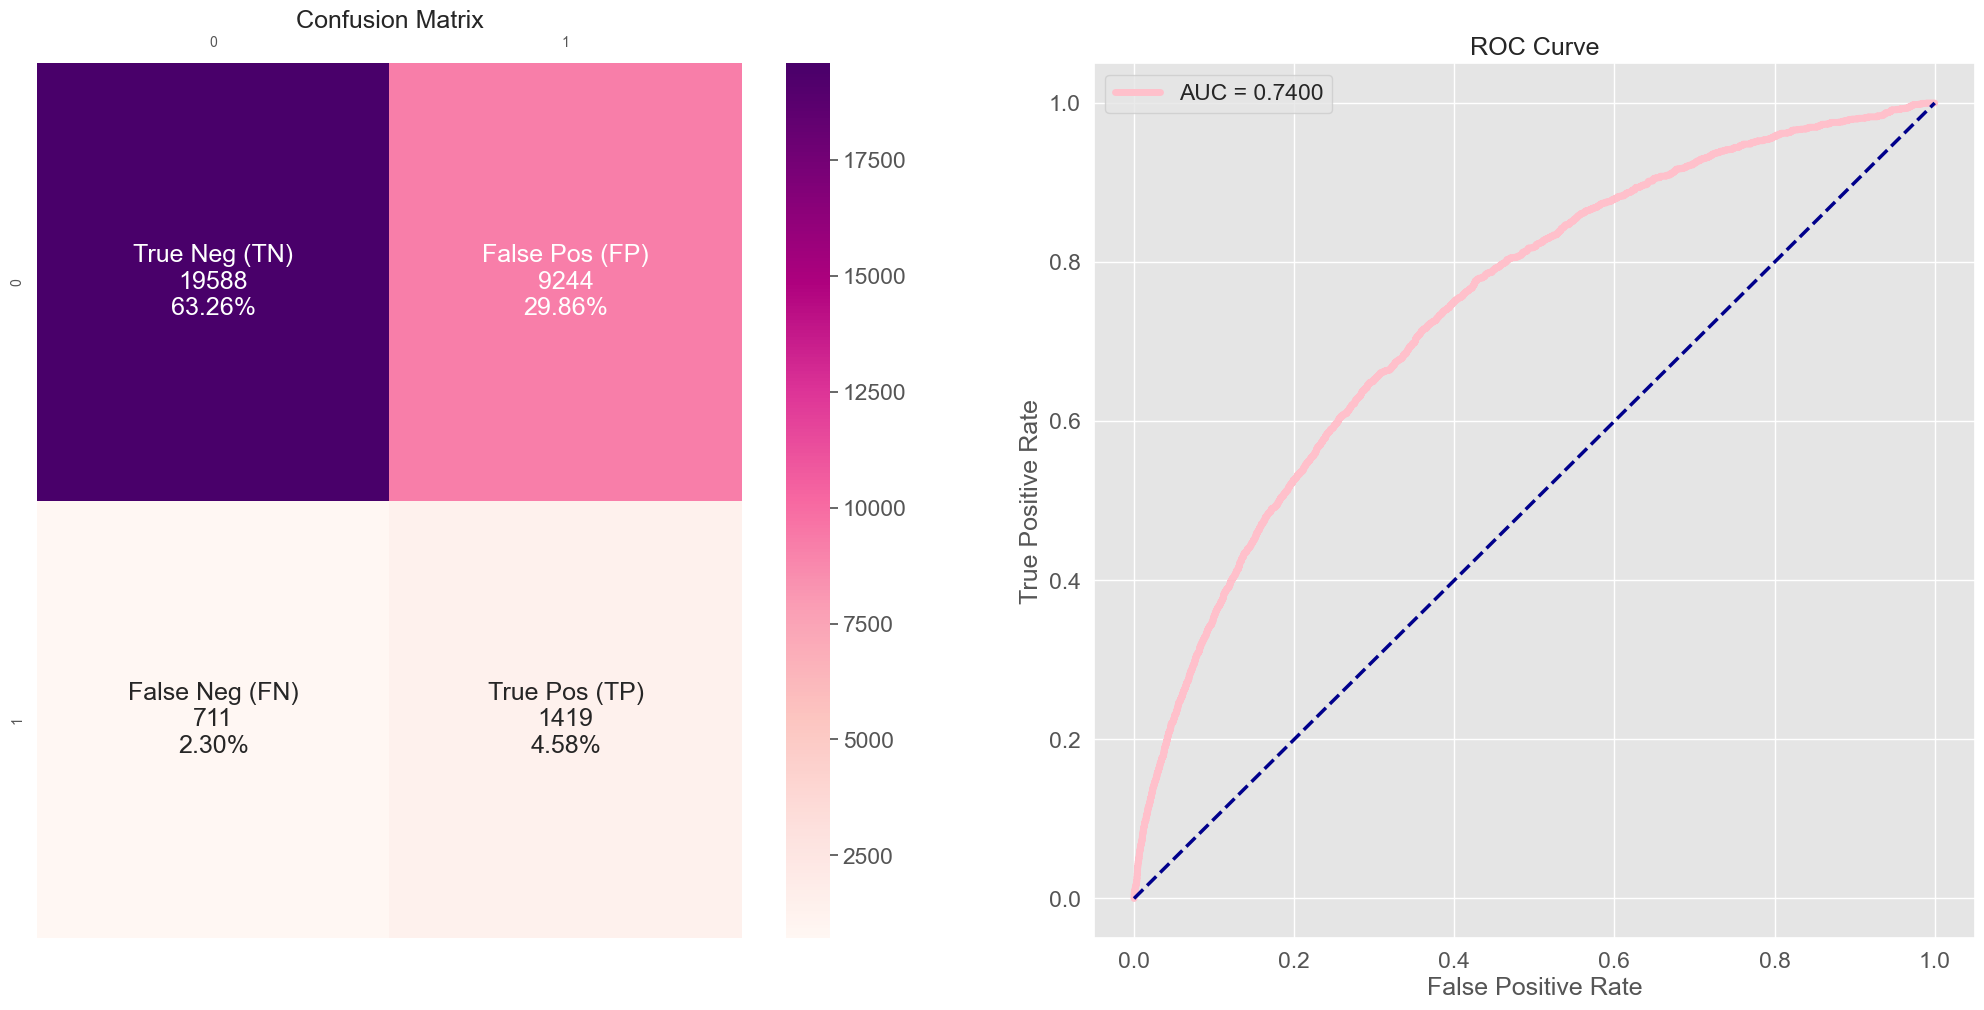

True negative =  19588
False positive =  9244
False negative =  711
True positive =  1419
time: 985 ms (started: 2023-07-05 00:11:00 +02:00)


In [202]:
# Appliquer la fonction "cf_matrix_roc_auc" pour calculer les valeurs des vrais négatifs (TN), faux positifs (FP), faux négatifs (FN) et vrais positifs (TP)
# Les paramètres passés à la fonction sont :
# - "y_test" : les vraies étiquettes de la classe cible
# - "prediction" : les étiquettes prédites par le modèle
# - "probability" : les probabilités de la classe positive prédites par le modèle
# - (25, 25) : la taille de la figure pour afficher la matrice de confusion et la courbe ROC
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (25, 25))


In [203]:
# Appel de la fonction "score_banq" pour calculer le score de gain
# Les paramètres passés à la fonction sont :
# - tn : le nombre de vrais négatifs (True Negatives)
# - fp : le nombre de faux positifs (False Positives)
# - fn : le nombre de faux négatifs (False Negatives)
# - tp : le nombre de vrais positifs (True Positives)
# - 10 : le gain pour un vrai positif (True Positive Gain)
# - -1 : le coût pour un faux positif (False Positive Cost)
# - -100 : le coût pour un faux négatif (False Negative Cost)
# - 0 : le coût pour un vrai négatif (True Negative Cost)
score_gain = score_banq(tn, fp, fn, tp, 10, -1, -100, 0)
score_gain

0.6740859225278788

time: 16 ms (started: 2023-07-05 00:11:36 +02:00)


In [204]:
# Ajout des métriques du modèle de régression logistique à la DataFrame
comparison_RandomUnderSampler_rl = pd.DataFrame(
        {
            "Modele": "RandomUnderSampler - Regression Logistique",
            "Accuracy": accuracy,            # Précision globale du modèle (TP + TN) / (TP + TN + FP + FN)
            "AUC": AUC,                      # Aire sous la courbe ROC du modèle
            "Recall class 1": recall,        # Rappel (recall) de la classe 1 (défaut de paiement) du modèle
            "F1": f1,                        # Score F1, mesure harmonique entre la précision et le rappel
            "TP": tp,                        # Nombre de vrais positifs du modèle (prédictions correctes de la classe 1)
            "Precision": precision,          # Précision du modèle TP / (TP + FP)
            "FN": fn,                        # Nombre de faux négatifs du modèle (prédictions erronées de la classe 1)
            "score Gain": score_gain,        # Score Gain calculé à partir des coûts spécifiés
            "time": prediction_time          # Temps de prédiction pour le modèle
        },
        index=[4],                          # Utilisation de l'index 0 pour ajouter une seule ligne au DataFrame
    )

# Affichage du DataFrame contenant les métriques de performance du modèle de régression logistique
comparison_model = pd.concat([comparison_model, comparison_RandomUnderSampler_rl])
comparison_model

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,score Gain,time
0,Baseline - Regression Logistique,0.931400,0.743208,0.008920,0.017576,19,0.593750,2111,0.601543,0.056971
1,Baseline - LGBMClassifier,0.931077,0.762079,0.008451,0.016590,18,0.450000,2112,0.601167,3.216664
2,Class Weight - Regression Logistique,0.688263,0.743127,0.669484,0.228087,1426,0.137459,704,0.681548,0.073802
3,Class Weight - LGBMClassifier,0.742426,0.760828,0.637559,0.254045,1358,0.158626,772,0.704928,2.328351
4,RandomUnderSampler - Regression Logistique,0.678477,0.739971,0.666197,0.221840,1419,0.133077,711,0.674086,0.086767


time: 32 ms (started: 2023-07-05 00:13:02 +02:00)


##### 7.2.3 LGBMClassifier

In [205]:
# Fixer les valeurs des hyperparamètres à tester
'''param_grid = {
        'n_estimators' : np.arange(500, 1500, 100),
        'learning_rate' : [1, 0.1, 0.01, 0.001]
        }

# Choisir un score à optimiser
score = 'roc_auc'


# define the model/ estimator
model = LGBMClassifier(objective='binary', random_state=42)

# define the grid search
lgbm= GridSearchCV(model, param_grid, scoring=score, cv=4, n_jobs=-1, verbose=2)  #cv : number of cross validation RandomizedSearchCV

# Optimiser ce régresseur sur le jeu d'entraînement
lgbm.fit(X_train_undersampled, y_train_undersampled, eval_metric='auc')

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :")
best_params = lgbm.best_params_
print(best_params)
print(' ')
print("Meilleur(s) score sur le jeu d'entraînement (roc_auc):")
print(lgbm.best_score_)'''

Fitting 4 folds for each of 40 candidates, totalling 160 fits
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :
{'learning_rate': 0.01, 'n_estimators': 700}
 
Meilleur(s) score sur le jeu d'entraînement (roc_auc):
0.7503188069729264
time: 15min 7s (started: 2023-07-05 00:17:21 +02:00)


Best paramètre sauvegardés car trop lent sur le GridSherchCV

* Fitting 4 folds for each of 40 candidates, totalling 160 fits 
* Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :
{'learning_rate': 0.01, 'n_estimators': 700}
 
* Meilleur(s) score sur le jeu d'entraînement (roc_auc):   
0.7503188069729264
* time: 15min 7s (started: 2023-07-05 00:17:21 +02:00)

In [206]:
# Définition des hyperparamètres optimaux pour le modèle LightGBM
best_params = LGBMClassifier(
    boosting_type='gbdt',  # Type d'algorithme de boosting à utiliser ('gbdt' est l'algorithme de boosting par défaut)
    num_leaves=31,  # Nombre maximal de feuilles dans un arbre (contrôle la complexité de l'arbre)
    max_depth=-1,  # Profondeur maximale des arbres (valeur négative indique aucune limite de profondeur)
    learning_rate=0.01,  # Taux d'apprentissage (contrôle l'ampleur des mises à jour des poids)
    n_estimators=700,  # Nombre d'arbres (estimateurs) à utiliser dans l'ensemble (boosting)
    subsample_for_bin=200000,  # Nombre d'échantillons à utiliser pour l'histogramme des bins
    objective='binary',  # Fonction objectif à optimiser ('binary' pour la classification binaire)
    class_weight=None,  # Poids des classes ajustés automatiquement pour l'équilibrage des classes
    min_split_gain=0.0,  # Gain minimal requis pour effectuer une séparation lors de la construction d'arbre
    min_child_weight=0.001,  # Poids minimal requis pour les feuilles des arbres
    min_child_samples=20,  # Nombre minimal d'échantillons requis pour une feuille dans un arbre
    subsample=1.0,  # Pourcentage d'échantillons à utiliser pour chaque arbre (1.0 signifie utiliser tous les échantillons)
    subsample_freq=0,  # Fréquence de sous-échantillonnage (0 signifie aucun sous-échantillonnage)
    colsample_bytree=1.0,  # Pourcentage de fonctionnalités à utiliser pour chaque arbre (1.0 signifie utiliser toutes les fonctionnalités)
    reg_alpha=0.0,  # Terme de régularisation L1 pour empêcher le surajustement
    reg_lambda=0.0,  # Terme de régularisation L2 pour empêcher le surajustement
    random_state=None,  # Graine aléatoire pour la reproductibilité des résultats
    n_jobs=-1,  # Nombre de cœurs de processeur à utiliser lors du calcul (-1 signifie utiliser tous les cœurs disponibles)
    silent=True,  # Contrôle la verbosité du modèle (True signifie aucune sortie affichée)
    importance_type='split'  # Méthode pour calculer l'importance des fonctionnalités ('split' utilise le nombre de splits)
)


time: 0 ns (started: 2023-07-05 00:35:34 +02:00)


In [207]:
# Appliquer la fonction "classification" avec les paramètres appropriés
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class= classification(best_params, X_train_undersampled, y_train_undersampled, X_test, y_test, "RandomUnderSampler - LGBMClassifier", file_name=None)

Exécution 
 
       SK_ID_CURR  positive_probability
0          316145              0.322320
1          399406              0.327292
2          168652              0.493895
3          317387              0.455866
4          371921              0.760550
...           ...                   ...
30957      268716              0.424314
30958      398091              0.319449
30959      228535              0.308624
30960      107632              0.377844
30961      343857              0.564610

[30962 rows x 2 columns]
Qualité de la classification 
 
 
L'accuracy score est de 0.6907499515535173 pour la méthode RandomUnderSampler - LGBMClassifier.
 
 
Le score de précision est de 0.14044238385009175 pour la méthode RandomUnderSampler - LGBMClassifier.
 
 
Le score recall est de 0.6826291079812207 pour la méthode RandomUnderSampler - LGBMClassifier.
 
 
Le score f1 est de 0.2329568212769366 pour la méthode RandomUnderSampler - LGBMClassifier.
 
 
Le score AUC est de 0.7548178406361216 pour la 

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/07/05 00:36:01 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: CreditModels, version 17


time: 21.2 s (started: 2023-07-05 00:35:40 +02:00)


Created version '17' of model 'CreditModels'.


In [208]:
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
df_matrice_confusion = matrix_TN_FN(y_test, prediction)

# Affichage de la matrice de confusion
print("Matrice de confusion :")
df_matrice_confusion

Matrice de confusion :


,Predicted Negative (0),Predicted Positive (1)
Real Negative (0),19933 (TN),8899 (FP)
Real Positive (1),676 (FN),1454 (TP)


time: 31 ms (started: 2023-07-05 00:36:01 +02:00)


In [209]:
# Calcul de l'aire sous la courbe ROC (ROC AUC) à partir des vraies étiquettes "y_test" et des probabilités de la classe positive "probability[:,1]"
# La fonction "roc_auc_score" prend en entrée les vraies étiquettes binaires (0 ou 1) et les probabilités de la classe positive
roc_auc = roc_auc_score(y_test, probability[:,1])

# Affichage de l'aire sous la courbe ROC (ROC AUC)
print('AUC : %0.4f' % roc_auc)

# Affichage du rapport de classification, qui contient différentes métriques pour évaluer les performances du modèle
# Le rapport de classification affiche la précision, le rappel, le score F1 et le support pour chaque classe du modèle (dans ce cas, classe 0 et classe 1)
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
print('Rapport de classification :')
print(classification_report(y_test, prediction))

AUC : 0.7548
Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.97      0.69      0.81     28832
         1.0       0.14      0.68      0.23      2130

    accuracy                           0.69     30962
   macro avg       0.55      0.69      0.52     30962
weighted avg       0.91      0.69      0.77     30962

time: 156 ms (started: 2023-07-05 00:36:01 +02:00)


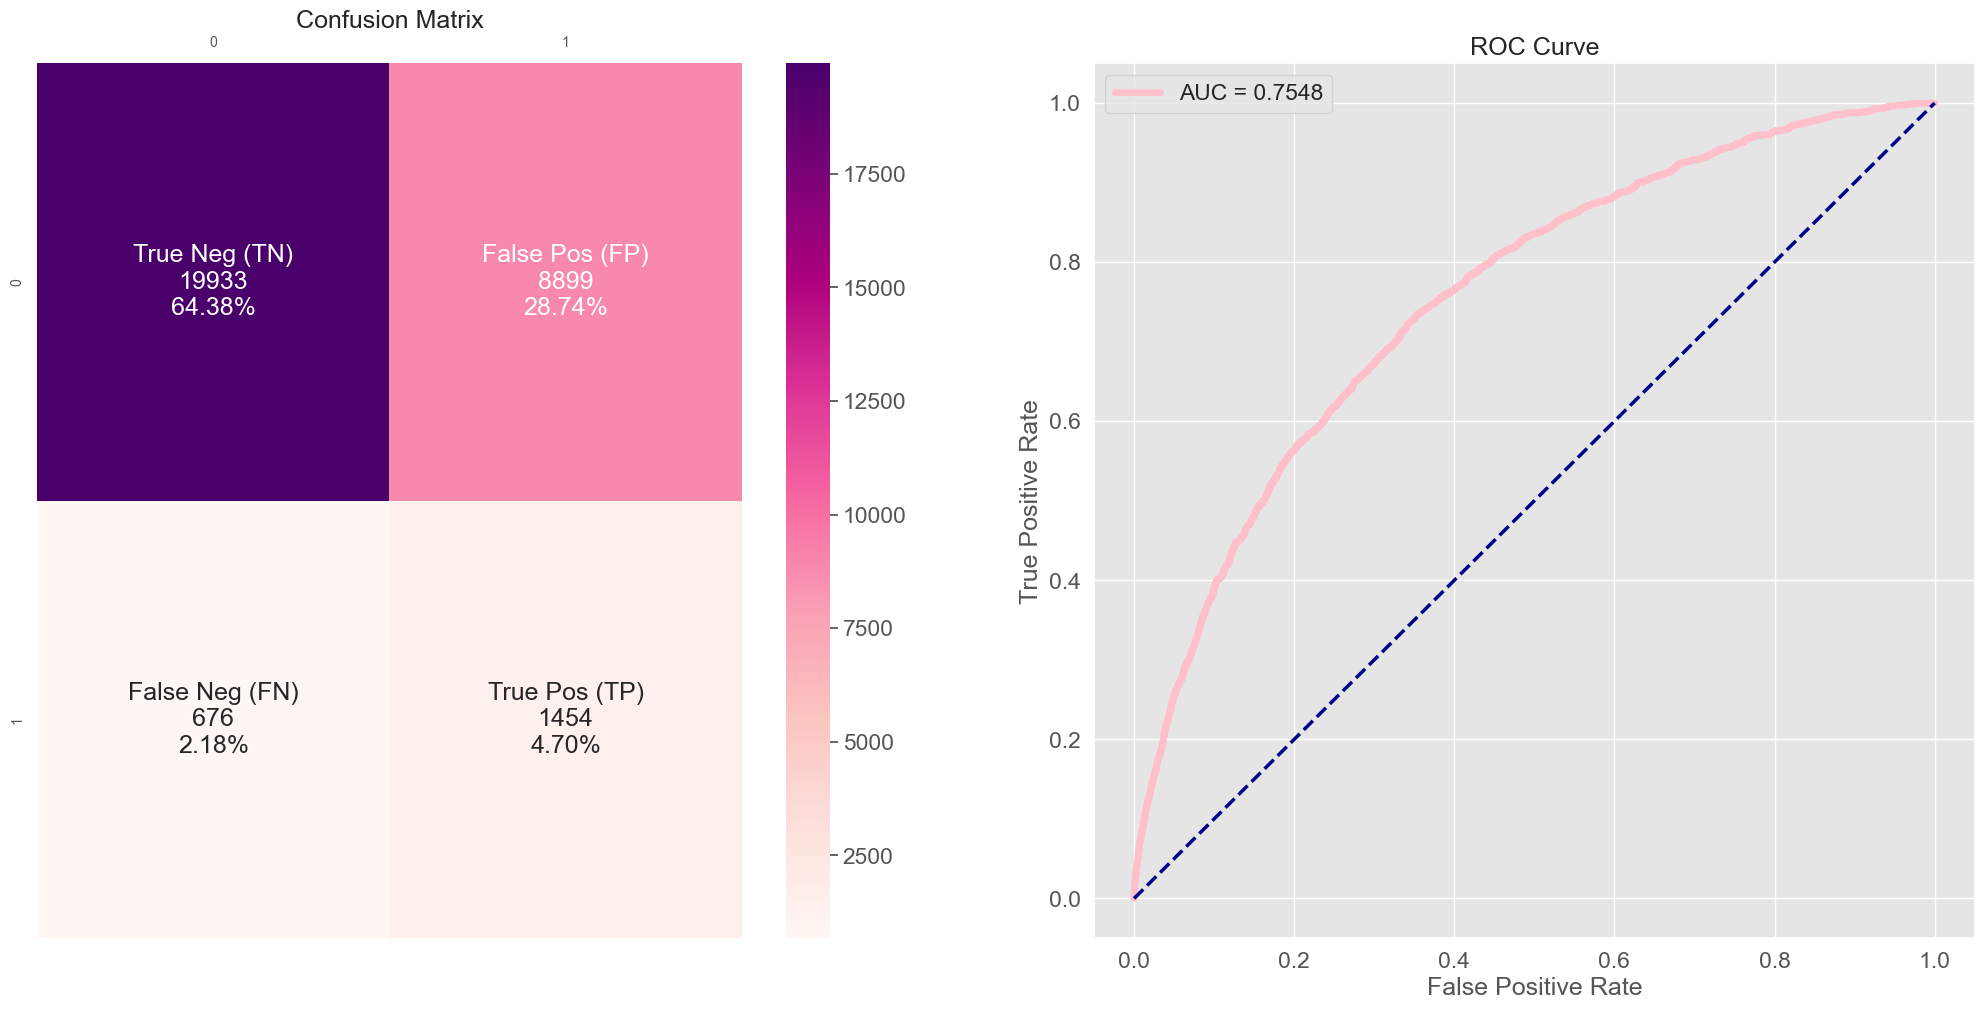

True negative =  19933
False positive =  8899
False negative =  676
True positive =  1454
time: 1.27 s (started: 2023-07-05 00:36:01 +02:00)


In [210]:
# Appliquer la fonction "cf_matrix_roc_auc" pour calculer les valeurs des vrais négatifs (TN), faux positifs (FP), faux négatifs (FN) et vrais positifs (TP)
# Les paramètres passés à la fonction sont :
# - "y_test" : les vraies étiquettes de la classe cible
# - "prediction" : les étiquettes prédites par le modèle
# - "probability" : les probabilités de la classe positive prédites par le modèle
# - (25, 25) : la taille de la figure pour afficher la matrice de confusion et la courbe ROC
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (25, 25))


In [211]:
# Appel de la fonction "score_banq" pour calculer le score de gain
# Les paramètres passés à la fonction sont :
# - tn : le nombre de vrais négatifs (True Negatives)
# - fp : le nombre de faux positifs (False Positives)
# - fn : le nombre de faux négatifs (False Negatives)
# - tp : le nombre de vrais positifs (True Positives)
# - 10 : le gain pour un vrai positif (True Positive Gain)
# - -1 : le coût pour un faux positif (False Positive Cost)
# - -100 : le coût pour un faux négatif (False Negative Cost)
# - 0 : le coût pour un vrai négatif (True Negative Cost)
score_gain = score_banq(tn, fp, fn, tp, 10, -1, -100, 0)
score_gain

0.6878461271484404

time: 16 ms (started: 2023-07-05 00:36:03 +02:00)


In [212]:
# Ajout des métriques du modèle de régression logistique à la DataFrame
comparison_RandomUnderSampler_lgbm = pd.DataFrame(
        {
            "Modele": "RandomUnderSampler - LGBMClassifier",
            "Accuracy": accuracy,            # Précision globale du modèle (TP + TN) / (TP + TN + FP + FN)
            "AUC": AUC,                      # Aire sous la courbe ROC du modèle
            "Recall class 1": recall,        # Rappel (recall) de la classe 1 (défaut de paiement) du modèle
            "F1": f1,                        # Score F1, mesure harmonique entre la précision et le rappel
            "TP": tp,                        # Nombre de vrais positifs du modèle (prédictions correctes de la classe 1)
            "Precision": precision,          # Précision du modèle TP / (TP + FP)
            "FN": fn,                        # Nombre de faux négatifs du modèle (prédictions erronées de la classe 1)
            "score Gain": score_gain,        # Score Gain calculé à partir des coûts spécifiés
            "time": prediction_time          # Temps de prédiction pour le modèle
        },
        index=[5],                          # Utilisation de l'index 0 pour ajouter une seule ligne au DataFrame
    )

# Affichage du DataFrame contenant les métriques de performance du modèle de régression logistique
comparison_model = pd.concat([comparison_model, comparison_RandomUnderSampler_lgbm])
comparison_model

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,score Gain,time
0,Baseline - Regression Logistique,0.931400,0.743208,0.008920,0.017576,19,0.593750,2111,0.601543,0.056971
1,Baseline - LGBMClassifier,0.931077,0.762079,0.008451,0.016590,18,0.450000,2112,0.601167,3.216664
2,Class Weight - Regression Logistique,0.688263,0.743127,0.669484,0.228087,1426,0.137459,704,0.681548,0.073802
3,Class Weight - LGBMClassifier,0.742426,0.760828,0.637559,0.254045,1358,0.158626,772,0.704928,2.328351
4,RandomUnderSampler - Regression Logistique,0.678477,0.739971,0.666197,0.221840,1419,0.133077,711,0.674086,0.086767
5,RandomUnderSampler - LGBMClassifier,0.690750,0.754818,0.682629,0.232957,1454,0.140442,676,0.687846,1.700519


time: 31 ms (started: 2023-07-05 00:36:11 +02:00)


#### 7.3 Oversampling / suréchantillonnage aléatoires

Le suréchantillonnage aléatoire duplique des exemples de la classe minoritaire dans l'ensemble de données d'apprentissage

C'est une méthode qui va dupliquer aléatoirement des données existantes de la classe minoritaire pour que chaque classe ait le même nombre de données que la classe sur-représentée à l'origine.

##### 7.3.1 Mise en place 

In [213]:
# importer "RandomOverSampler" pour effectuer un suréchantillonnage
from imblearn.over_sampling import RandomOverSampler

time: 0 ns (started: 2023-07-05 00:41:23 +02:00)


In [214]:
print(f"Label 1, Avant d'utiliser RandomOverSampler: {sum(y_train==1)} ")
print(f"Label 0, Avant d'utiliser RandomOverSampler: {sum(y_train==0)} ")

Label 1, Avant d'utiliser RandomOverSampler: 8654 
Label 0, Avant d'utiliser RandomOverSampler: 115191 
time: 47 ms (started: 2023-07-05 00:41:25 +02:00)


In [217]:
# Création d'une instance de RandomOverSampler avec un random_state fixé à 0 pour la reproductibilité
ros = RandomOverSampler(random_state=0)

# Application du suréchantillonnage aléatoire aux données d'entraînement X_train et y_train
# Les données suréchantillonnage équilibrées sont stockées dans X_train_undersampled et y_train_undersampled
X_train_oversampled, y_train_oversampled = ros.fit_resample(X_train, y_train)

# Conversion des données suréchantillonnage en DataFrame pandas
# Cela permet de garder les noms de colonnes de X_train pour faciliter l'utilisation ultérieure
X_train_oversampled = pd.DataFrame(X_train_oversampled, columns=X_train.columns)


time: 2.33 s (started: 2023-07-05 00:42:11 +02:00)


In [218]:
print(f"Label 1, Après avoir utilisé RandomOverSampler: {sum(y_train_oversampled==1)}")
print(f"Label 0, Après avoir utilisé RandomOverSampler: {sum(y_train_oversampled==0)}")

Label 1, Après avoir utilisé RandomOverSampler: 115191
Label 0, Après avoir utilisé RandomOverSampler: 115191
time: 78 ms (started: 2023-07-05 00:42:16 +02:00)


##### 7.3.2 Régression logistique 

In [219]:
# Fixer les valeurs des hyperparamètres à tester
param_grid = {"C":[-0.001, -0.01, -0.1, 1, 0.1, 0.01, 0.001, 5, 10, 15, 50, 100]} 
        

# Choisir un score à optimiser
score = 'roc_auc'


# définir le modèle/ estimateur
model = LogisticRegression(random_state=42)

# définir le grid search
lr= GridSearchCV(model, param_grid, scoring=score, cv=4, n_jobs=-1, verbose=2)  #cv : number of cross validation RandomizedSearchCV

# Optimiser ce régresseur sur le jeu d'entraînement
lr.fit(X_train_oversampled, y_train_oversampled)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :")
best_params = lr.best_params_
print(best_params)
print(' ')
print("Meilleur(s) score sur le jeu d'entraînement (roc_auc):")
print(lr.best_score_)

Fitting 4 folds for each of 12 candidates, totalling 48 fits
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :
{'C': 0.1}
 
Meilleur(s) score sur le jeu d'entraînement (roc_auc):
0.7446893136159052
time: 3min 42s (started: 2023-07-05 00:44:41 +02:00)


In [220]:
# Définition des hyperparamètres optimaux pour le modèle de régression logistique
best_params = LogisticRegression(
    C=0.1,  # Paramètre de régularisation inverse (plus petit est C, plus forte est la régularisation)
    class_weight=None,  # Poids des classes ajustés automatiquement pour l'équilibrage des classes
    dual=False,  # Contrainte de dualité (utilisé pour de petites tailles d'échantillons et lorsque le nombre de fonctionnalités est supérieur au nombre d'échantillons)
    fit_intercept=True,  # Indique si une constante (intercept) doit être ajoutée à la fonction de décision
    intercept_scaling=1,  # Paramètre de mise à l'échelle de l'intercept
    l1_ratio=None,  # Paramètre pour la régularisation L1 (None signifie pas de régularisation L1)
    max_iter=100,  # Nombre maximum d'itérations pour la convergence
    multi_class='auto',  # Contrôle la stratégie de résolution du problème de classification multiclasse
    n_jobs=None,  # Nombre de cœurs de processeur à utiliser lors du calcul (None signifie un seul cœur)
    penalty='l2',  # Type de régularisation à utiliser (l2 indique une régularisation L2)
    random_state=42,  # Graine aléatoire pour la reproductibilité des résultats
    solver='lbfgs',  # Algorithme à utiliser pour l'optimisation (lbfgs est un algorithme de descente de gradient limité)
    tol=0.0001,  # Tolérance pour la convergence
    verbose=0,  # Contrôle la verbosité lors de l'ajustement (0 signifie aucune sortie affichée)
    warm_start=False  # Contrôle la réutilisation de la solution précédente pour l'initialisation
)


time: 0 ns (started: 2023-07-05 00:49:47 +02:00)


In [221]:
# Appliquer la fonction "classification" avec les paramètres appropriés
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class= classification(best_params, X_train_oversampled, y_train_oversampled, X_test, y_test, "RandomOverSampler Regression logistique", file_name=None)

Exécution 
 
       SK_ID_CURR  positive_probability
0          316145              0.329493
1          399406              0.326810
2          168652              0.586470
3          317387              0.215325
4          371921              0.681868
...           ...                   ...
30957      268716              0.451197
30958      398091              0.182449
30959      228535              0.290281
30960      107632              0.363721
30961      343857              0.660306

[30962 rows x 2 columns]
Qualité de la classification 
 
 
L'accuracy score est de 0.6885860086557716 pour la méthode RandomOverSampler Regression logistique.
 
 
Le score de précision est de 0.13724164574077652 pour la méthode RandomOverSampler Regression logistique.
 
 
Le score recall est de 0.6671361502347418 pour la méthode RandomOverSampler Regression logistique.
 
 
Le score f1 est de 0.22765139378404362 pour la méthode RandomOverSampler Regression logistique.
 
 
Le score AUC est de 0.74281251

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/07/05 00:50:16 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: CreditModels, version 18


time: 17.6 s (started: 2023-07-05 00:49:59 +02:00)


Created version '18' of model 'CreditModels'.


In [222]:
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
df_matrice_confusion = matrix_TN_FN(y_test, prediction)

# Affichage de la matrice de confusion
print("Matrice de confusion :")
df_matrice_confusion

Matrice de confusion :


,Predicted Negative (0),Predicted Positive (1)
Real Negative (0),19899 (TN),8933 (FP)
Real Positive (1),709 (FN),1421 (TP)


time: 31 ms (started: 2023-07-05 00:50:17 +02:00)


In [223]:
# Calcul de l'aire sous la courbe ROC (ROC AUC) à partir des vraies étiquettes "y_test" et des probabilités de la classe positive "probability[:,1]"
# La fonction "roc_auc_score" prend en entrée les vraies étiquettes binaires (0 ou 1) et les probabilités de la classe positive
roc_auc = roc_auc_score(y_test, probability[:,1])

# Affichage de l'aire sous la courbe ROC (ROC AUC)
print('AUC : %0.4f' % roc_auc)

# Affichage du rapport de classification, qui contient différentes métriques pour évaluer les performances du modèle
# Le rapport de classification affiche la précision, le rappel, le score F1 et le support pour chaque classe du modèle (dans ce cas, classe 0 et classe 1)
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
print('Rapport de classification :')
print(classification_report(y_test, prediction))

AUC : 0.7428
Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.97      0.69      0.80     28832
         1.0       0.14      0.67      0.23      2130

    accuracy                           0.69     30962
   macro avg       0.55      0.68      0.52     30962
weighted avg       0.91      0.69      0.77     30962

time: 140 ms (started: 2023-07-05 00:52:14 +02:00)


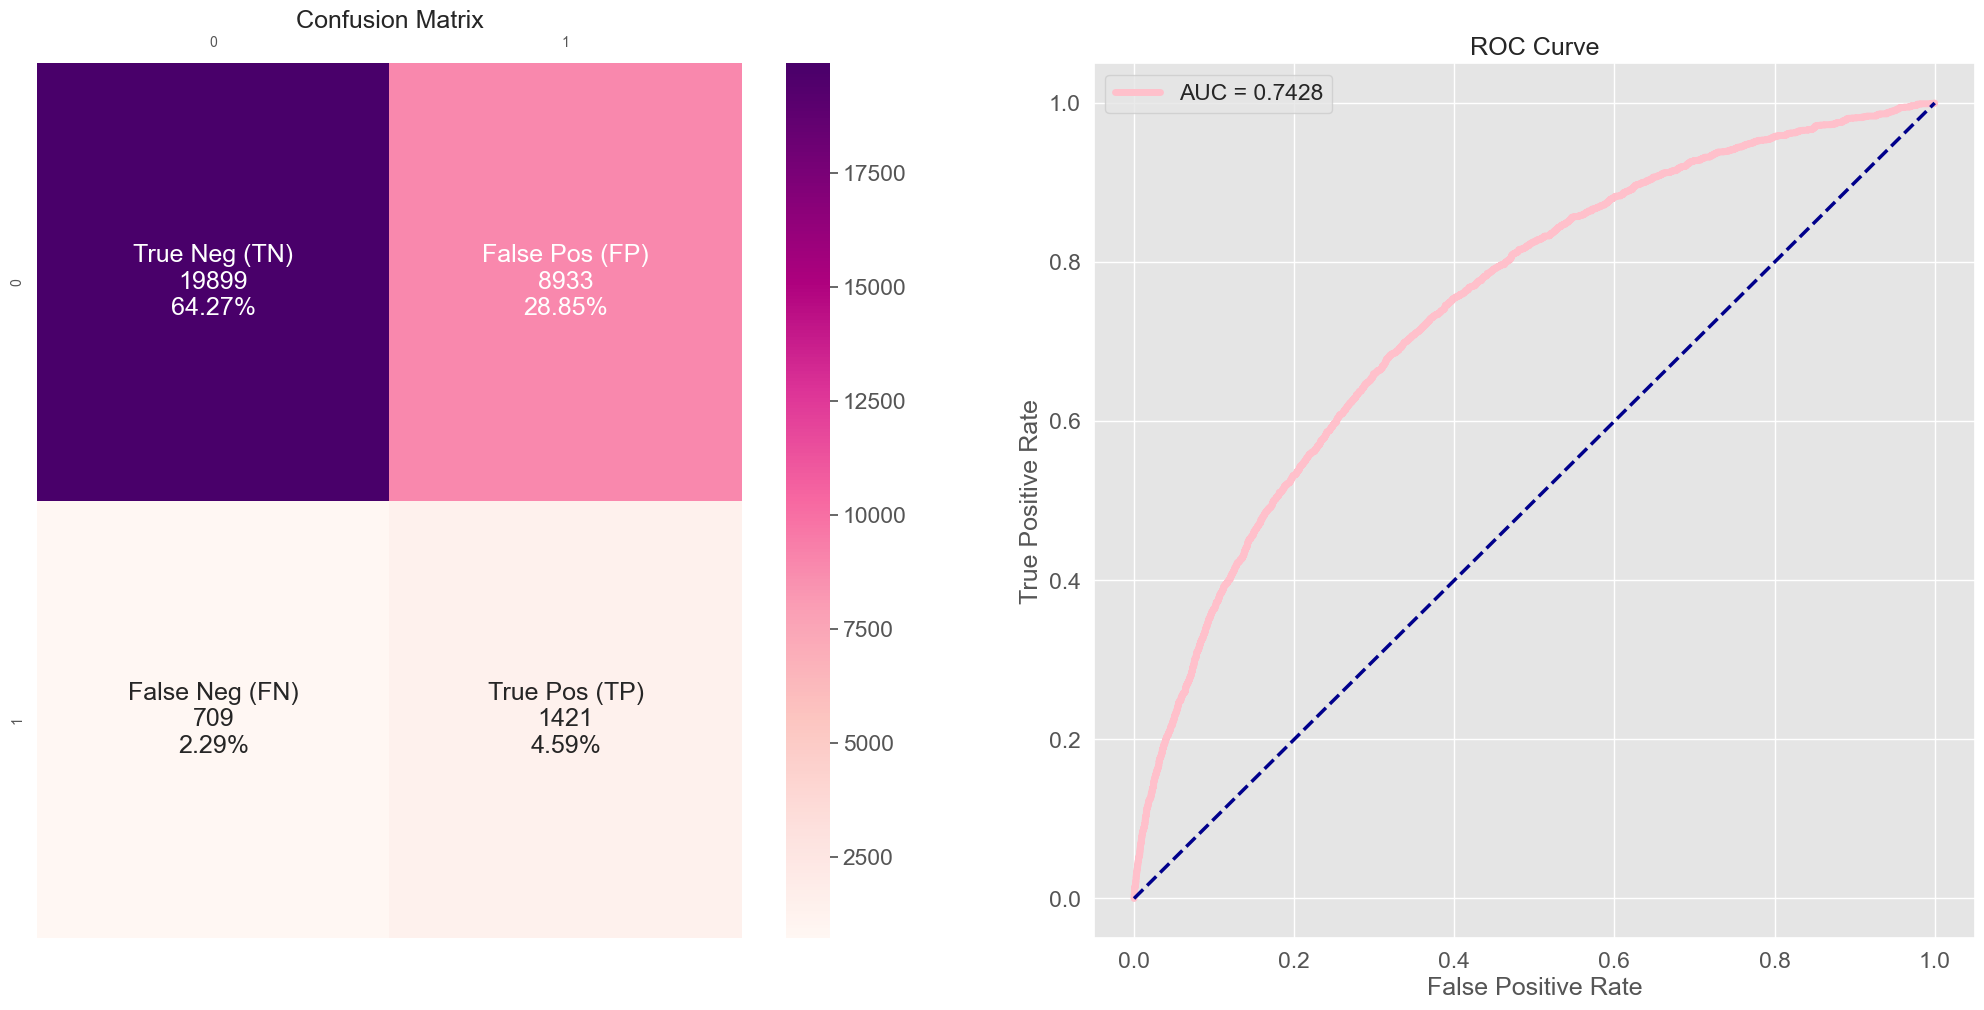

True negative =  19899
False positive =  8933
False negative =  709
True positive =  1421
time: 1.17 s (started: 2023-07-05 00:52:17 +02:00)


In [224]:
# Appliquer la fonction "cf_matrix_roc_auc" pour calculer les valeurs des vrais négatifs (TN), faux positifs (FP), faux négatifs (FN) et vrais positifs (TP)
# Les paramètres passés à la fonction sont :
# - "y_test" : les vraies étiquettes de la classe cible
# - "prediction" : les étiquettes prédites par le modèle
# - "probability" : les probabilités de la classe positive prédites par le modèle
# - (25, 25) : la taille de la figure pour afficher la matrice de confusion et la courbe ROC
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (25, 25))


In [225]:
# Appel de la fonction "score_banq" pour calculer le score de gain
# Les paramètres passés à la fonction sont :
# - tn : le nombre de vrais négatifs (True Negatives)
# - fp : le nombre de faux positifs (False Positives)
# - fn : le nombre de faux négatifs (False Negatives)
# - tp : le nombre de vrais positifs (True Positives)
# - 10 : le gain pour un vrai positif (True Positive Gain)
# - -1 : le coût pour un faux positif (False Positive Cost)
# - -100 : le coût pour un faux négatif (False Negative Cost)
# - 0 : le coût pour un vrai négatif (True Negative Cost)
score_gain = score_banq(tn, fp, fn, tp, 10, -1, -100, 0)
score_gain

0.6809160391736709

time: 0 ns (started: 2023-07-05 00:52:22 +02:00)


In [226]:
# Ajout des métriques du modèle de régression logistique à la DataFrame
comparison_RandomOverSampler_lr = pd.DataFrame(
        {
            "Modele": "RandomOverSampler - Regression Logistique",
            "Accuracy": accuracy,            # Précision globale du modèle (TP + TN) / (TP + TN + FP + FN)
            "AUC": AUC,                      # Aire sous la courbe ROC du modèle
            "Recall class 1": recall,        # Rappel (recall) de la classe 1 (défaut de paiement) du modèle
            "F1": f1,                        # Score F1, mesure harmonique entre la précision et le rappel
            "TP": tp,                        # Nombre de vrais positifs du modèle (prédictions correctes de la classe 1)
            "Precision": precision,          # Précision du modèle TP / (TP + FP)
            "FN": fn,                        # Nombre de faux négatifs du modèle (prédictions erronées de la classe 1)
            "score Gain": score_gain,        # Score Gain calculé à partir des coûts spécifiés
            "time": prediction_time          # Temps de prédiction pour le modèle
        },
        index=[6],                          # Utilisation de l'index 0 pour ajouter une seule ligne au DataFrame
    )

# Affichage du DataFrame contenant les métriques de performance du modèle de régression logistique
comparison_model = pd.concat([comparison_model, comparison_RandomOverSampler_lr])
comparison_model

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,score Gain,time
0,Baseline - Regression Logistique,0.931400,0.743208,0.008920,0.017576,19,0.593750,2111,0.601543,0.056971
1,Baseline - LGBMClassifier,0.931077,0.762079,0.008451,0.016590,18,0.450000,2112,0.601167,3.216664
2,Class Weight - Regression Logistique,0.688263,0.743127,0.669484,0.228087,1426,0.137459,704,0.681548,0.073802
3,Class Weight - LGBMClassifier,0.742426,0.760828,0.637559,0.254045,1358,0.158626,772,0.704928,2.328351
4,RandomUnderSampler - Regression Logistique,0.678477,0.739971,0.666197,0.221840,1419,0.133077,711,0.674086,0.086767
5,RandomUnderSampler - LGBMClassifier,0.690750,0.754818,0.682629,0.232957,1454,0.140442,676,0.687846,1.700519
6,RandomOverSampler - Regression Logistique,0.688586,0.742813,0.667136,0.227651,1421,0.137242,709,0.680916,0.065823


time: 31 ms (started: 2023-07-05 00:53:16 +02:00)


##### 7.3.3 LGBMClassifier

In [227]:
# Fixer les valeurs des hyperparamètres à tester
'''param_grid = {
        'n_estimators' : np.arange(500, 1500, 100),
        'learning_rate' : [1, 0.1, 0.01, 0.001]
        }

# Choisir un score à optimiser
score = 'roc_auc'


# define the model/ estimator
model = LGBMClassifier(objective='binary', random_state=42)

# define the grid search
lgbm= GridSearchCV(model, param_grid, scoring=score, cv=4, n_jobs=-1, verbose=2)  #cv : number of cross validation RandomizedSearchCV

# Optimiser ce régresseur sur le jeu d'entraînement
lgbm.fit(X_train_oversampled, y_train_oversampled, eval_metric='auc')

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :")
best_params = lgbm.best_params_
print(best_params)
print(' ')
print("Meilleur(s) score sur le jeu d'entraînement (roc_auc):")
print(lgbm.best_score_)'''

Fitting 4 folds for each of 40 candidates, totalling 160 fits
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :
{'learning_rate': 0.1, 'n_estimators': 1400}
 
Meilleur(s) score sur le jeu d'entraînement (roc_auc):
0.9924004576872585
time: 1h 35min 15s (started: 2023-07-05 00:53:38 +02:00)


Best paramètre sauvegardés car trop lent sur le GridSherchCV

* Fitting 4 folds for each of 40 candidates, totalling 160 fits 
* Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :
{'learning_rate': 0.01, 'n_estimators': 1400}
 
* Meilleur(s) score sur le jeu d'entraînement (roc_auc):   
0.9924004576872585
* time: 1h 35min 15s (started: 2023-07-05 00:53:38 +02:00)

In [228]:
# Définition des hyperparamètres optimaux pour le modèle LightGBM
best_params = LGBMClassifier(
    boosting_type='gbdt',  # Type d'algorithme de boosting à utiliser ('gbdt' est l'algorithme de boosting par défaut)
    num_leaves=31,  # Nombre maximal de feuilles dans un arbre (contrôle la complexité de l'arbre)
    max_depth=-1,  # Profondeur maximale des arbres (valeur négative indique aucune limite de profondeur)
    learning_rate=0.01,  # Taux d'apprentissage (contrôle l'ampleur des mises à jour des poids)
    n_estimators=1400,  # Nombre d'arbres (estimateurs) à utiliser dans l'ensemble (boosting)
    subsample_for_bin=200000,  # Nombre d'échantillons à utiliser pour l'histogramme des bins
    objective='binary',  # Fonction objectif à optimiser ('binary' pour la classification binaire)
    class_weight=None,  # Poids des classes ajustés automatiquement pour l'équilibrage des classes
    min_split_gain=0.0,  # Gain minimal requis pour effectuer une séparation lors de la construction d'arbre
    min_child_weight=0.001,  # Poids minimal requis pour les feuilles des arbres
    min_child_samples=20,  # Nombre minimal d'échantillons requis pour une feuille dans un arbre
    subsample=1.0,  # Pourcentage d'échantillons à utiliser pour chaque arbre (1.0 signifie utiliser tous les échantillons)
    subsample_freq=0,  # Fréquence de sous-échantillonnage (0 signifie aucun sous-échantillonnage)
    colsample_bytree=1.0,  # Pourcentage de fonctionnalités à utiliser pour chaque arbre (1.0 signifie utiliser toutes les fonctionnalités)
    reg_alpha=0.0,  # Terme de régularisation L1 pour empêcher le surajustement
    reg_lambda=0.0,  # Terme de régularisation L2 pour empêcher le surajustement
    random_state=None,  # Graine aléatoire pour la reproductibilité des résultats
    n_jobs=-1,  # Nombre de cœurs de processeur à utiliser lors du calcul (-1 signifie utiliser tous les cœurs disponibles)
    silent=True,  # Contrôle la verbosité du modèle (True signifie aucune sortie affichée)
    importance_type='split'  # Méthode pour calculer l'importance des fonctionnalités ('split' utilise le nombre de splits)
)


time: 16 ms (started: 2023-07-05 09:20:10 +02:00)


In [229]:
# Appliquer la fonction "classification" avec les paramètres appropriés
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class= classification(best_params, X_train_oversampled, y_train_oversampled, X_test, y_test, "RandomOverSampler - LGBMClassifier", file_name=None)

Exécution 
 
       SK_ID_CURR  positive_probability
0          316145              0.283177
1          399406              0.302426
2          168652              0.476126
3          317387              0.191737
4          371921              0.725588
...           ...                   ...
30957      268716              0.355127
30958      398091              0.282356
30959      228535              0.212192
30960      107632              0.297810
30961      343857              0.527394

[30962 rows x 2 columns]
Qualité de la classification 
 
 
L'accuracy score est de 0.7442994638589239 pour la méthode RandomOverSampler - LGBMClassifier.
 
 
Le score de précision est de 0.15809996455157746 pour la méthode RandomOverSampler - LGBMClassifier.
 
 
Le score recall est de 0.6281690140845071 pour la méthode RandomOverSampler - LGBMClassifier.
 
 
Le score f1 est de 0.2526196544888134 pour la méthode RandomOverSampler - LGBMClassifier.
 
 
Le score AUC est de 0.7589902879169206 pour la méth

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/07/05 09:22:28 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: CreditModels, version 19


time: 1min 46s (started: 2023-07-05 09:20:42 +02:00)


Created version '19' of model 'CreditModels'.


In [230]:
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
df_matrice_confusion = matrix_TN_FN(y_test, prediction)

# Affichage de la matrice de confusion
print("Matrice de confusion :")
df_matrice_confusion

Matrice de confusion :


,Predicted Negative (0),Predicted Positive (1)
Real Negative (0),21707 (TN),7125 (FP)
Real Positive (1),792 (FN),1338 (TP)


time: 15 ms (started: 2023-07-05 09:22:42 +02:00)


In [231]:
# Calcul de l'aire sous la courbe ROC (ROC AUC) à partir des vraies étiquettes "y_test" et des probabilités de la classe positive "probability[:,1]"
# La fonction "roc_auc_score" prend en entrée les vraies étiquettes binaires (0 ou 1) et les probabilités de la classe positive
roc_auc = roc_auc_score(y_test, probability[:,1])

# Affichage de l'aire sous la courbe ROC (ROC AUC)
print('AUC : %0.4f' % roc_auc)

# Affichage du rapport de classification, qui contient différentes métriques pour évaluer les performances du modèle
# Le rapport de classification affiche la précision, le rappel, le score F1 et le support pour chaque classe du modèle (dans ce cas, classe 0 et classe 1)
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
print('Rapport de classification :')
print(classification_report(y_test, prediction))

AUC : 0.7590
Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.96      0.75      0.85     28832
         1.0       0.16      0.63      0.25      2130

    accuracy                           0.74     30962
   macro avg       0.56      0.69      0.55     30962
weighted avg       0.91      0.74      0.80     30962

time: 125 ms (started: 2023-07-05 09:22:45 +02:00)


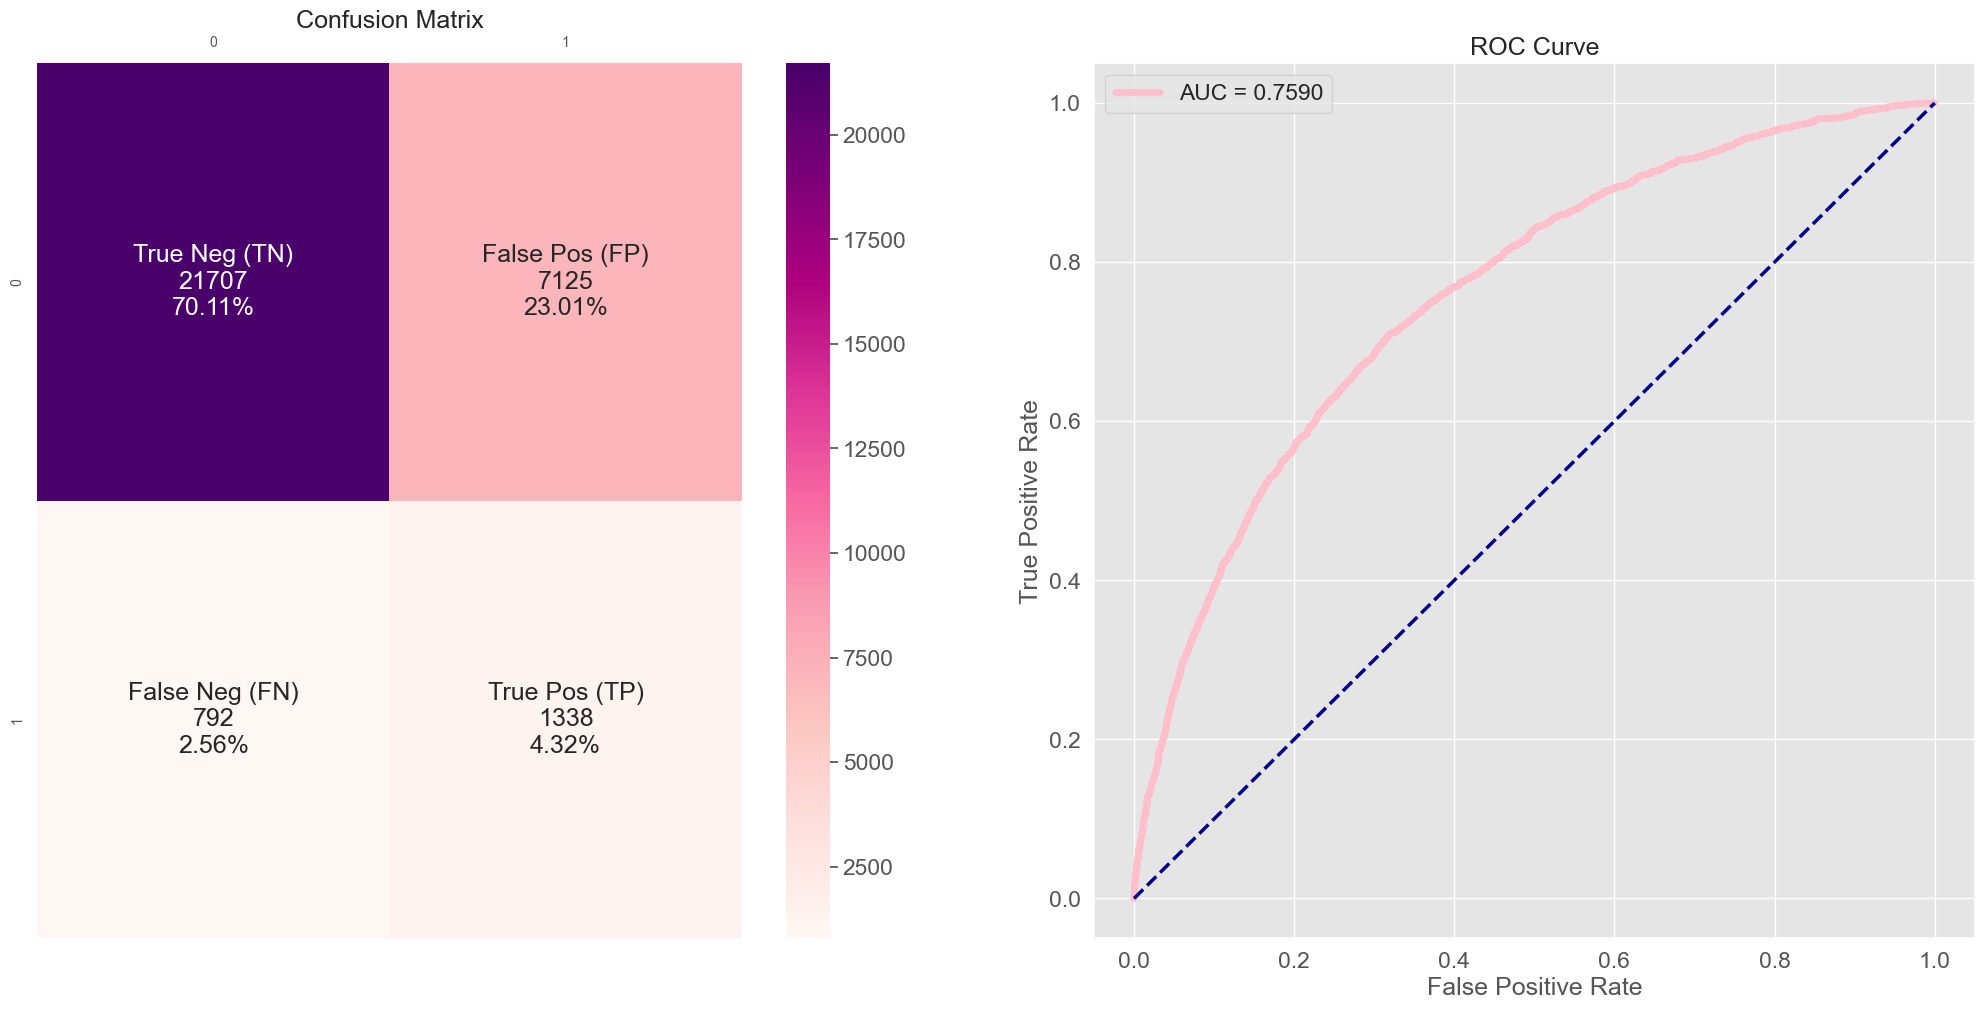

True negative =  21707
False positive =  7125
False negative =  792
True positive =  1338
time: 1.17 s (started: 2023-07-05 09:22:50 +02:00)


In [232]:
# Appliquer la fonction "cf_matrix_roc_auc" pour calculer les valeurs des vrais négatifs (TN), faux positifs (FP), faux négatifs (FN) et vrais positifs (TP)
# Les paramètres passés à la fonction sont :
# - "y_test" : les vraies étiquettes de la classe cible
# - "prediction" : les étiquettes prédites par le modèle
# - "probability" : les probabilités de la classe positive prédites par le modèle
# - (25, 25) : la taille de la figure pour afficher la matrice de confusion et la courbe ROC
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (25, 25))


In [233]:
# Appel de la fonction "score_banq" pour calculer le score de gain
# Les paramètres passés à la fonction sont :
# - tn : le nombre de vrais négatifs (True Negatives)
# - fp : le nombre de faux positifs (False Positives)
# - fn : le nombre de faux négatifs (False Negatives)
# - tp : le nombre de vrais positifs (True Positives)
# - 10 : le gain pour un vrai positif (True Positive Gain)
# - -1 : le coût pour un faux positif (False Positive Cost)
# - -100 : le coût pour un faux négatif (False Negative Cost)
# - 0 : le coût pour un vrai négatif (True Negative Cost)
score_gain = score_banq(tn, fp, fn, tp, 10, -1, -100, 0)
score_gain

0.7027739214413979

time: 0 ns (started: 2023-07-05 09:22:54 +02:00)


In [234]:
# Ajout des métriques du modèle de régression logistique à la DataFrame
comparison_RandomOverSampler_lgbm = pd.DataFrame(
        {
            "Modele": "RandomOverSampler - LGBMClassifier",
            "Accuracy": accuracy,            # Précision globale du modèle (TP + TN) / (TP + TN + FP + FN)
            "AUC": AUC,                      # Aire sous la courbe ROC du modèle
            "Recall class 1": recall,        # Rappel (recall) de la classe 1 (défaut de paiement) du modèle
            "F1": f1,                        # Score F1, mesure harmonique entre la précision et le rappel
            "TP": tp,                        # Nombre de vrais positifs du modèle (prédictions correctes de la classe 1)
            "Precision": precision,          # Précision du modèle TP / (TP + FP)
            "FN": fn,                        # Nombre de faux négatifs du modèle (prédictions erronées de la classe 1)
            "score Gain": score_gain,        # Score Gain calculé à partir des coûts spécifiés
            "time": prediction_time          # Temps de prédiction pour le modèle
        },
        index=[7],                          # Utilisation de l'index 0 pour ajouter une seule ligne au DataFrame
    )

# Affichage du DataFrame contenant les métriques de performance du modèle de régression logistique
comparison_model = pd.concat([comparison_model, comparison_RandomOverSampler_lgbm])
comparison_model

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,score Gain,time
0,Baseline - Regression Logistique,0.931400,0.743208,0.008920,0.017576,19,0.593750,2111,0.601543,0.056971
1,Baseline - LGBMClassifier,0.931077,0.762079,0.008451,0.016590,18,0.450000,2112,0.601167,3.216664
2,Class Weight - Regression Logistique,0.688263,0.743127,0.669484,0.228087,1426,0.137459,704,0.681548,0.073802
3,Class Weight - LGBMClassifier,0.742426,0.760828,0.637559,0.254045,1358,0.158626,772,0.704928,2.328351
4,RandomUnderSampler - Regression Logistique,0.678477,0.739971,0.666197,0.221840,1419,0.133077,711,0.674086,0.086767
5,RandomUnderSampler - LGBMClassifier,0.690750,0.754818,0.682629,0.232957,1454,0.140442,676,0.687846,1.700519
6,RandomOverSampler - Regression Logistique,0.688586,0.742813,0.667136,0.227651,1421,0.137242,709,0.680916,0.065823
7,RandomOverSampler - LGBMClassifier,0.744299,0.758990,0.628169,0.252620,1338,0.158100,792,0.702774,2.714450


time: 16 ms (started: 2023-07-05 09:23:00 +02:00)


#### 7.4 Oversampling (SMOTE) / suréchantillonnage aléatoires

C'est une méthode qui va créer de nouvelles données de la classe sous-représentée à partir des données existantes (et donc de la variété) pour que chaque classe ait le même nombre de données que la classe sur-représentée à l'origine.

##### 7.4.1 Mise en place SMOTE

In [235]:
# importer "SMOTE" pour effectuer un suréchantillonnage
from imblearn.over_sampling import SMOTE

time: 16 ms (started: 2023-07-05 09:28:06 +02:00)


In [236]:
print(f"Label 1, Avant d'utiliser SMOTE: {sum(y_train==1)} ")
print(f"Label 0, Avant d'utiliser SMOTE: {sum(y_train==0)} ")

Label 1, Avant d'utiliser SMOTE: 8654 
Label 0, Avant d'utiliser SMOTE: 115191 
time: 47 ms (started: 2023-07-05 09:28:08 +02:00)


In [237]:
# Création d'une instance de SMOTE avec un random_state fixé à 0 pour la reproductibilité
sm = SMOTE(random_state=0)

# Application du suréchantillonnage aléatoire aux données d'entraînement X_train et y_train
# Les données suréchantillonnage équilibrées sont stockées dans X_train_undersampled et y_train_undersampled
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

# Conversion des données suréchantillonnage en DataFrame pandas
# Cela permet de garder les noms de colonnes de X_train pour faciliter l'utilisation ultérieure
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)


time: 4.39 s (started: 2023-07-05 09:28:12 +02:00)


In [238]:
print(f"Label 1, Après avoir utilisé SMOTE: {sum(y_train_resampled==1)}")
print(f"Label 0, Après avoir utilisé SMOTE: {sum(y_train_resampled==0)}")

Label 1, Après avoir utilisé SMOTE: 115191
Label 0, Après avoir utilisé SMOTE: 115191
time: 62 ms (started: 2023-07-05 09:28:19 +02:00)


##### 7.4.2 Régression lgistique 

In [239]:
# Fixer les valeurs des hyperparamètres à tester
param_grid = {"C":[-0.001, -0.01, -0.1, 1, 0.1, 0.01, 0.001, 5, 10, 15, 50, 100]} 
        

# Choisir un score à optimiser
score = 'roc_auc'


# définir le modèle/ estimateur
model = LogisticRegression(random_state=42)

# définir le grid search
lr= GridSearchCV(model, param_grid, scoring=score, cv=4, n_jobs=-1, verbose=2)  #cv : number of cross validation RandomizedSearchCV

# Optimiser ce régresseur sur le jeu d'entraînement
lr.fit(X_train_resampled, y_train_resampled)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :")
best_params = lr.best_params_
print(best_params)
print(' ')
print("Meilleur(s) score sur le jeu d'entraînement (roc_auc):")
print(lr.best_score_)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :
{'C': 0.01}
 
Meilleur(s) score sur le jeu d'entraînement (roc_auc):
0.9711551017850504
time: 3min 50s (started: 2023-07-05 09:30:40 +02:00)


In [240]:
# Définition des hyperparamètres optimaux pour le modèle de régression logistique
best_params = LogisticRegression(
    C=0.1,  # Paramètre de régularisation inverse (plus petit est C, plus forte est la régularisation)
    class_weight=None,  # Poids des classes ajustés automatiquement pour l'équilibrage des classes
    dual=False,  # Contrainte de dualité (utilisé pour de petites tailles d'échantillons et lorsque le nombre de fonctionnalités est supérieur au nombre d'échantillons)
    fit_intercept=True,  # Indique si une constante (intercept) doit être ajoutée à la fonction de décision
    intercept_scaling=1,  # Paramètre de mise à l'échelle de l'intercept
    l1_ratio=None,  # Paramètre pour la régularisation L1 (None signifie pas de régularisation L1)
    max_iter=100,  # Nombre maximum d'itérations pour la convergence
    multi_class='auto',  # Contrôle la stratégie de résolution du problème de classification multiclasse
    n_jobs=None,  # Nombre de cœurs de processeur à utiliser lors du calcul (None signifie un seul cœur)
    penalty='l2',  # Type de régularisation à utiliser (l2 indique une régularisation L2)
    random_state=42,  # Graine aléatoire pour la reproductibilité des résultats
    solver='lbfgs',  # Algorithme à utiliser pour l'optimisation (lbfgs est un algorithme de descente de gradient limité)
    tol=0.0001,  # Tolérance pour la convergence
    verbose=0,  # Contrôle la verbosité lors de l'ajustement (0 signifie aucune sortie affichée)
    warm_start=False  # Contrôle la réutilisation de la solution précédente pour l'initialisation
)


time: 0 ns (started: 2023-07-05 09:35:56 +02:00)


In [241]:
# Appliquer la fonction "classification" avec les paramètres appropriés
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class= classification(best_params, X_train_resampled, y_train_resampled, X_test, y_test, "SMOTE - Regression logistique", file_name=None)

Exécution 
 
       SK_ID_CURR  positive_probability
0          316145              0.044213
1          399406              0.056752
2          168652              0.136518
3          317387              0.017366
4          371921              0.198154
...           ...                   ...
30957      268716              0.023221
30958      398091              0.032158
30959      228535              0.074339
30960      107632              0.076055
30961      343857              0.152478

[30962 rows x 2 columns]
Qualité de la classification 
 
 
L'accuracy score est de 0.9312705897551837 pour la méthode SMOTE - Regression logistique.
 
 
Le score de précision est de 0.5185185185185185 pour la méthode SMOTE - Regression logistique.
 
 
Le score recall est de 0.013145539906103286 pour la méthode SMOTE - Regression logistique.
 
 
Le score f1 est de 0.025641025641025644 pour la méthode SMOTE - Regression logistique.
 
 
Le score AUC est de 0.7283593672653754 pour la méthode SMOTE - Regre

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/07/05 09:36:23 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: CreditModels, version 20


time: 19.7 s (started: 2023-07-05 09:36:03 +02:00)


Created version '20' of model 'CreditModels'.


In [242]:
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
df_matrice_confusion = matrix_TN_FN(y_test, prediction)

# Affichage de la matrice de confusion
print("Matrice de confusion :")
df_matrice_confusion

Matrice de confusion :


,Predicted Negative (0),Predicted Positive (1)
Real Negative (0),28806 (TN),26 (FP)
Real Positive (1),2102 (FN),28 (TP)


time: 16 ms (started: 2023-07-05 09:36:29 +02:00)


In [243]:
# Calcul de l'aire sous la courbe ROC (ROC AUC) à partir des vraies étiquettes "y_test" et des probabilités de la classe positive "probability[:,1]"
# La fonction "roc_auc_score" prend en entrée les vraies étiquettes binaires (0 ou 1) et les probabilités de la classe positive
roc_auc = roc_auc_score(y_test, probability[:,1])

# Affichage de l'aire sous la courbe ROC (ROC AUC)
print('AUC : %0.4f' % roc_auc)

# Affichage du rapport de classification, qui contient différentes métriques pour évaluer les performances du modèle
# Le rapport de classification affiche la précision, le rappel, le score F1 et le support pour chaque classe du modèle (dans ce cas, classe 0 et classe 1)
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
print('Rapport de classification :')
print(classification_report(y_test, prediction))

AUC : 0.7284
Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     28832
         1.0       0.52      0.01      0.03      2130

    accuracy                           0.93     30962
   macro avg       0.73      0.51      0.50     30962
weighted avg       0.90      0.93      0.90     30962

time: 109 ms (started: 2023-07-05 09:36:32 +02:00)


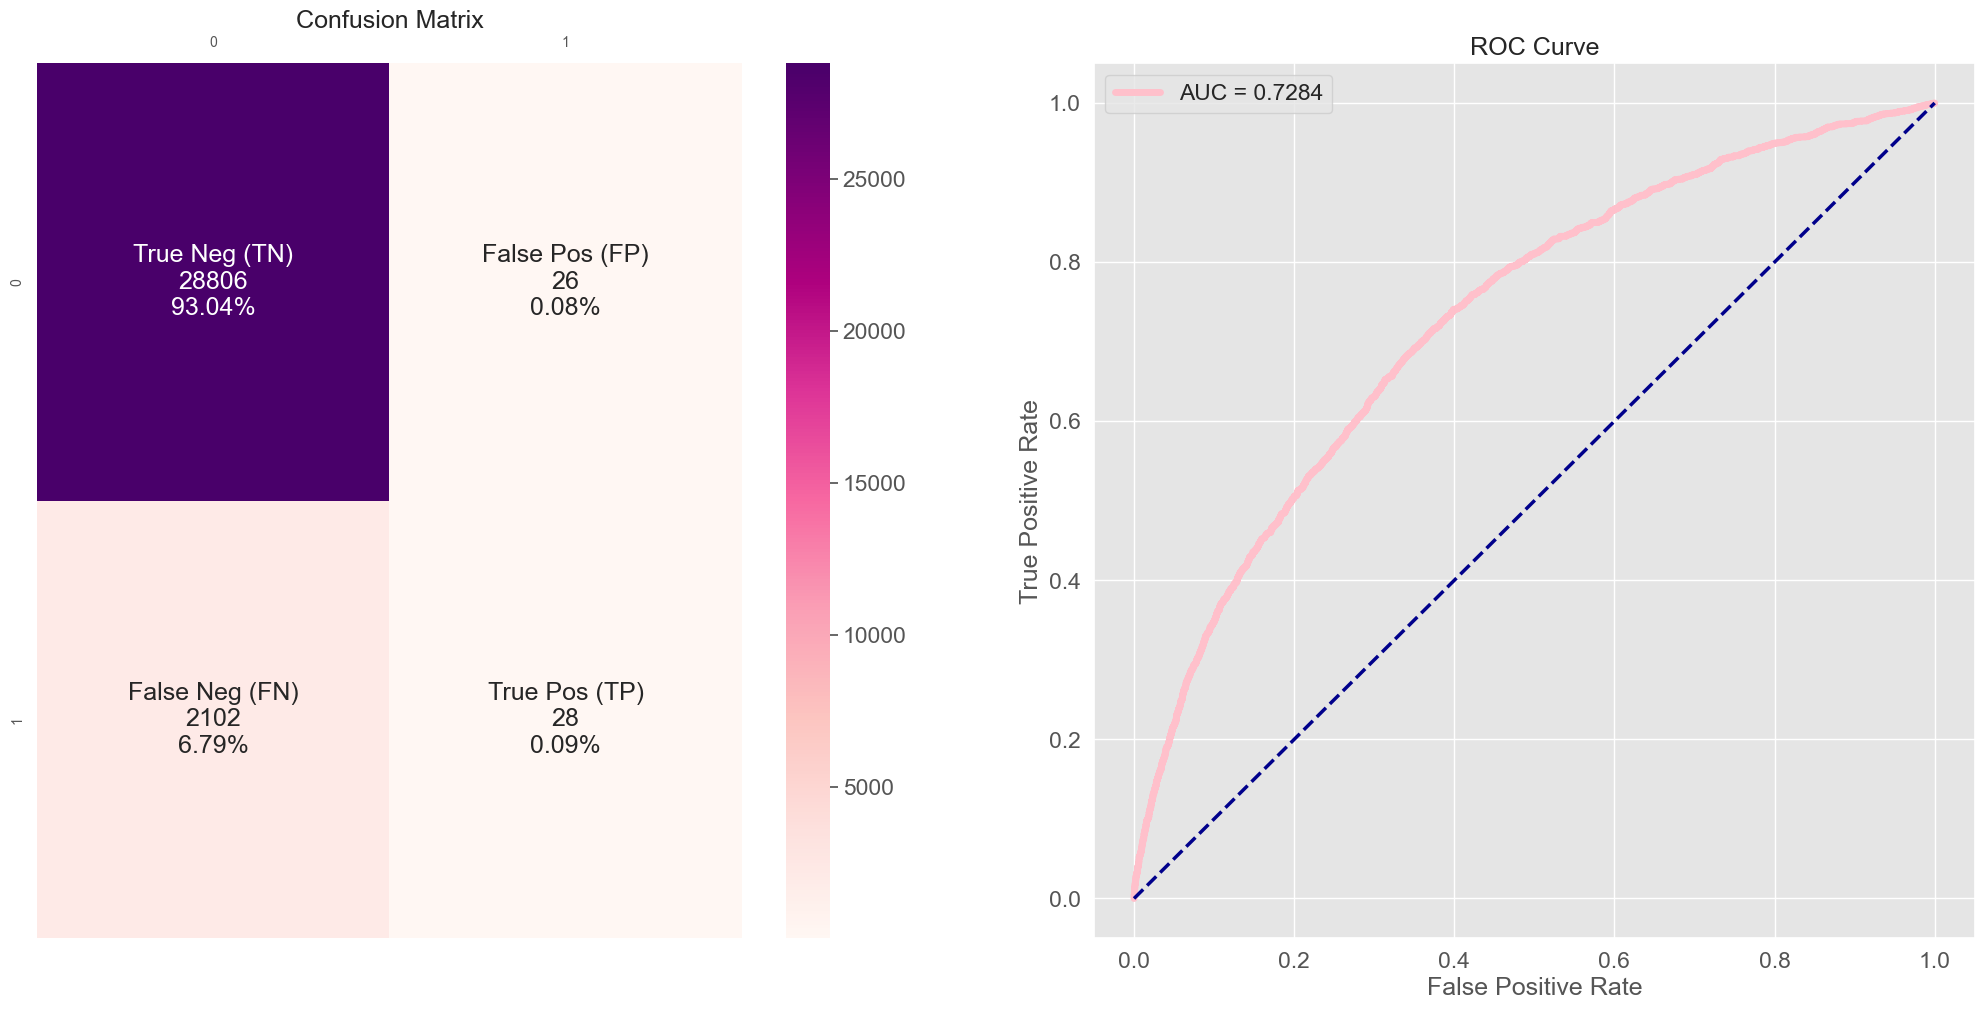

True negative =  28806
False positive =  26
False negative =  2102
True positive =  28
time: 1.03 s (started: 2023-07-05 09:37:05 +02:00)


In [244]:
# Appliquer la fonction "cf_matrix_roc_auc" pour calculer les valeurs des vrais négatifs (TN), faux positifs (FP), faux négatifs (FN) et vrais positifs (TP)
# Les paramètres passés à la fonction sont :
# - "y_test" : les vraies étiquettes de la classe cible
# - "prediction" : les étiquettes prédites par le modèle
# - "probability" : les probabilités de la classe positive prédites par le modèle
# - (25, 25) : la taille de la figure pour afficher la matrice de confusion et la courbe ROC
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (25, 25))


In [245]:
# Appel de la fonction "score_banq" pour calculer le score de gain
# Les paramètres passés à la fonction sont :
# - tn : le nombre de vrais négatifs (True Negatives)
# - fp : le nombre de faux positifs (False Positives)
# - fn : le nombre de faux négatifs (False Negatives)
# - tp : le nombre de vrais positifs (True Positives)
# - 10 : le gain pour un vrai positif (True Positive Gain)
# - -1 : le coût pour un faux positif (False Positive Cost)
# - -100 : le coût pour un faux négatif (False Negative Cost)
# - 0 : le coût pour un vrai négatif (True Negative Cost)
score_gain = score_banq(tn, fp, fn, tp, 10, -1, -100, 0)
score_gain

0.6029704688466704

time: 16 ms (started: 2023-07-05 09:37:09 +02:00)


In [246]:
# Ajout des métriques du modèle de régression logistique à la DataFrame
comparison_smote_rl = pd.DataFrame(
        {
            "Modele": "SMOTE - Regression Logistique",
            "Accuracy": accuracy,            # Précision globale du modèle (TP + TN) / (TP + TN + FP + FN)
            "AUC": AUC,                      # Aire sous la courbe ROC du modèle
            "Recall class 1": recall,        # Rappel (recall) de la classe 1 (défaut de paiement) du modèle
            "F1": f1,                        # Score F1, mesure harmonique entre la précision et le rappel
            "TP": tp,                        # Nombre de vrais positifs du modèle (prédictions correctes de la classe 1)
            "Precision": precision,          # Précision du modèle TP / (TP + FP)
            "FN": fn,                        # Nombre de faux négatifs du modèle (prédictions erronées de la classe 1)
            "score Gain": score_gain,        # Score Gain calculé à partir des coûts spécifiés
            "time": prediction_time          # Temps de prédiction pour le modèle
        },
        index=[8],                          # Utilisation de l'index 0 pour ajouter une seule ligne au DataFrame
    )

# Affichage du DataFrame contenant les métriques de performance du modèle de régression logistique
comparison_model = pd.concat([comparison_model, comparison_smote_rl])
comparison_model

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,score Gain,time
0,Baseline - Regression Logistique,0.931400,0.743208,0.008920,0.017576,19,0.593750,2111,0.601543,0.056971
1,Baseline - LGBMClassifier,0.931077,0.762079,0.008451,0.016590,18,0.450000,2112,0.601167,3.216664
2,Class Weight - Regression Logistique,0.688263,0.743127,0.669484,0.228087,1426,0.137459,704,0.681548,0.073802
3,Class Weight - LGBMClassifier,0.742426,0.760828,0.637559,0.254045,1358,0.158626,772,0.704928,2.328351
4,RandomUnderSampler - Regression Logistique,0.678477,0.739971,0.666197,0.221840,1419,0.133077,711,0.674086,0.086767
5,RandomUnderSampler - LGBMClassifier,0.690750,0.754818,0.682629,0.232957,1454,0.140442,676,0.687846,1.700519
6,RandomOverSampler - Regression Logistique,0.688586,0.742813,0.667136,0.227651,1421,0.137242,709,0.680916,0.065823
7,RandomOverSampler - LGBMClassifier,0.744299,0.758990,0.628169,0.252620,1338,0.158100,792,0.702774,2.714450
8,SMOTE - Regression Logistique,0.931271,0.728359,0.013146,0.025641,28,0.518519,2102,0.602970,0.089766


time: 32 ms (started: 2023-07-05 09:37:12 +02:00)


##### 7.4.3 LGBMClassifier

In [247]:
# Fixer les valeurs des hyperparamètres à tester
'''param_grid = {
        'n_estimators' : np.arange(500, 1500, 100),
        'learning_rate' : [1, 0.1, 0.01, 0.001]
        }

# Choisir un score à optimiser
score = 'roc_auc'


# define the model/ estimator
model = LGBMClassifier(objective='binary', random_state=42)

# define the grid search
lgbm= GridSearchCV(model, param_grid, scoring=score, cv=4, n_jobs=-1, verbose=2)  #cv : number of cross validation RandomizedSearchCV

# Optimiser ce régresseur sur le jeu d'entraînement
lgbm.fit(X_train_resampled, y_train_resampled, eval_metric='auc')

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :")
best_params = lgbm.best_params_
print(best_params)
print(' ')
print("Meilleur(s) score sur le jeu d'entraînement (roc_auc):")
print(lgbm.best_score_)'''

Fitting 4 folds for each of 40 candidates, totalling 160 fits
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :
{'learning_rate': 0.1, 'n_estimators': 800}
 
Meilleur(s) score sur le jeu d'entraînement (roc_auc):
0.9742854446562242
time: 1h 59min 2s (started: 2023-07-05 09:40:14 +02:00)


Best paramètre sauvegardés car trop lent sur le GridSherchCV

* Fitting 4 folds for each of 40 candidates, totalling 160 fits 
* Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :
{'learning_rate': 0.1, 'n_estimators': 800}
 
* Meilleur(s) score sur le jeu d'entraînement (roc_auc):   
0.9742854446562242
* time: 1h 59min 2s (started: 2023-07-05 09:40:14 +02:00)

In [248]:
# Définition des hyperparamètres optimaux pour le modèle LightGBM
best_params = LGBMClassifier(
    boosting_type='gbdt',  # Type d'algorithme de boosting à utiliser ('gbdt' est l'algorithme de boosting par défaut)
    num_leaves=31,  # Nombre maximal de feuilles dans un arbre (contrôle la complexité de l'arbre)
    max_depth=-1,  # Profondeur maximale des arbres (valeur négative indique aucune limite de profondeur)
    learning_rate=0.1,  # Taux d'apprentissage (contrôle l'ampleur des mises à jour des poids)
    n_estimators=800,  # Nombre d'arbres (estimateurs) à utiliser dans l'ensemble (boosting)
    subsample_for_bin=200000,  # Nombre d'échantillons à utiliser pour l'histogramme des bins
    objective='binary',  # Fonction objectif à optimiser ('binary' pour la classification binaire)
    class_weight=None,  # Poids des classes ajustés automatiquement pour l'équilibrage des classes
    min_split_gain=0.0,  # Gain minimal requis pour effectuer une séparation lors de la construction d'arbre
    min_child_weight=0.001,  # Poids minimal requis pour les feuilles des arbres
    min_child_samples=20,  # Nombre minimal d'échantillons requis pour une feuille dans un arbre
    subsample=1.0,  # Pourcentage d'échantillons à utiliser pour chaque arbre (1.0 signifie utiliser tous les échantillons)
    subsample_freq=0,  # Fréquence de sous-échantillonnage (0 signifie aucun sous-échantillonnage)
    colsample_bytree=1.0,  # Pourcentage de fonctionnalités à utiliser pour chaque arbre (1.0 signifie utiliser toutes les fonctionnalités)
    reg_alpha=0.0,  # Terme de régularisation L1 pour empêcher le surajustement
    reg_lambda=0.0,  # Terme de régularisation L2 pour empêcher le surajustement
    random_state=None,  # Graine aléatoire pour la reproductibilité des résultats
    n_jobs=-1,  # Nombre de cœurs de processeur à utiliser lors du calcul (-1 signifie utiliser tous les cœurs disponibles)
    silent=True,  # Contrôle la verbosité du modèle (True signifie aucune sortie affichée)
    importance_type='split'  # Méthode pour calculer l'importance des fonctionnalités ('split' utilise le nombre de splits)
)


time: 16 ms (started: 2023-07-05 11:41:20 +02:00)


In [249]:
# Appliquer la fonction "classification" avec les paramètres appropriés
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class= classification(best_params, X_train_resampled, y_train_resampled, X_test, y_test, "SMOTE - LGBMClassifier", file_name=None)

Exécution 
 
       SK_ID_CURR  positive_probability
0          316145              0.035388
1          399406              0.064350
2          168652              0.065554
3          317387              0.030249
4          371921              0.152292
...           ...                   ...
30957      268716              0.044210
30958      398091              0.016725
30959      228535              0.010905
30960      107632              0.029565
30961      343857              0.036427

[30962 rows x 2 columns]
Qualité de la classification 
 
 
L'accuracy score est de 0.9303985530650475 pour la méthode SMOTE - LGBMClassifier.
 
 
Le score de précision est de 0.422360248447205 pour la méthode SMOTE - LGBMClassifier.
 
 
Le score recall est de 0.03192488262910798 pour la méthode SMOTE - LGBMClassifier.
 
 
Le score f1 est de 0.059362723701440426 pour la méthode SMOTE - LGBMClassifier.
 
 
Le score AUC est de 0.7393699553964558 pour la méthode SMOTE - LGBMClassifier.
 
 


Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/07/05 11:42:45 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: CreditModels, version 21


time: 1min 21s (started: 2023-07-05 11:41:23 +02:00)


Created version '21' of model 'CreditModels'.


In [250]:
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
df_matrice_confusion = matrix_TN_FN(y_test, prediction)

# Affichage de la matrice de confusion
print("Matrice de confusion :")
df_matrice_confusion

Matrice de confusion :


,Predicted Negative (0),Predicted Positive (1)
Real Negative (0),28739 (TN),93 (FP)
Real Positive (1),2062 (FN),68 (TP)


time: 31 ms (started: 2023-07-05 11:42:45 +02:00)


In [251]:
# Calcul de l'aire sous la courbe ROC (ROC AUC) à partir des vraies étiquettes "y_test" et des probabilités de la classe positive "probability[:,1]"
# La fonction "roc_auc_score" prend en entrée les vraies étiquettes binaires (0 ou 1) et les probabilités de la classe positive
roc_auc = roc_auc_score(y_test, probability[:,1])

# Affichage de l'aire sous la courbe ROC (ROC AUC)
print('AUC : %0.4f' % roc_auc)

# Affichage du rapport de classification, qui contient différentes métriques pour évaluer les performances du modèle
# Le rapport de classification affiche la précision, le rappel, le score F1 et le support pour chaque classe du modèle (dans ce cas, classe 0 et classe 1)
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
print('Rapport de classification :')
print(classification_report(y_test, prediction))

AUC : 0.7394
Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     28832
         1.0       0.42      0.03      0.06      2130

    accuracy                           0.93     30962
   macro avg       0.68      0.51      0.51     30962
weighted avg       0.90      0.93      0.90     30962

time: 140 ms (started: 2023-07-05 11:42:45 +02:00)


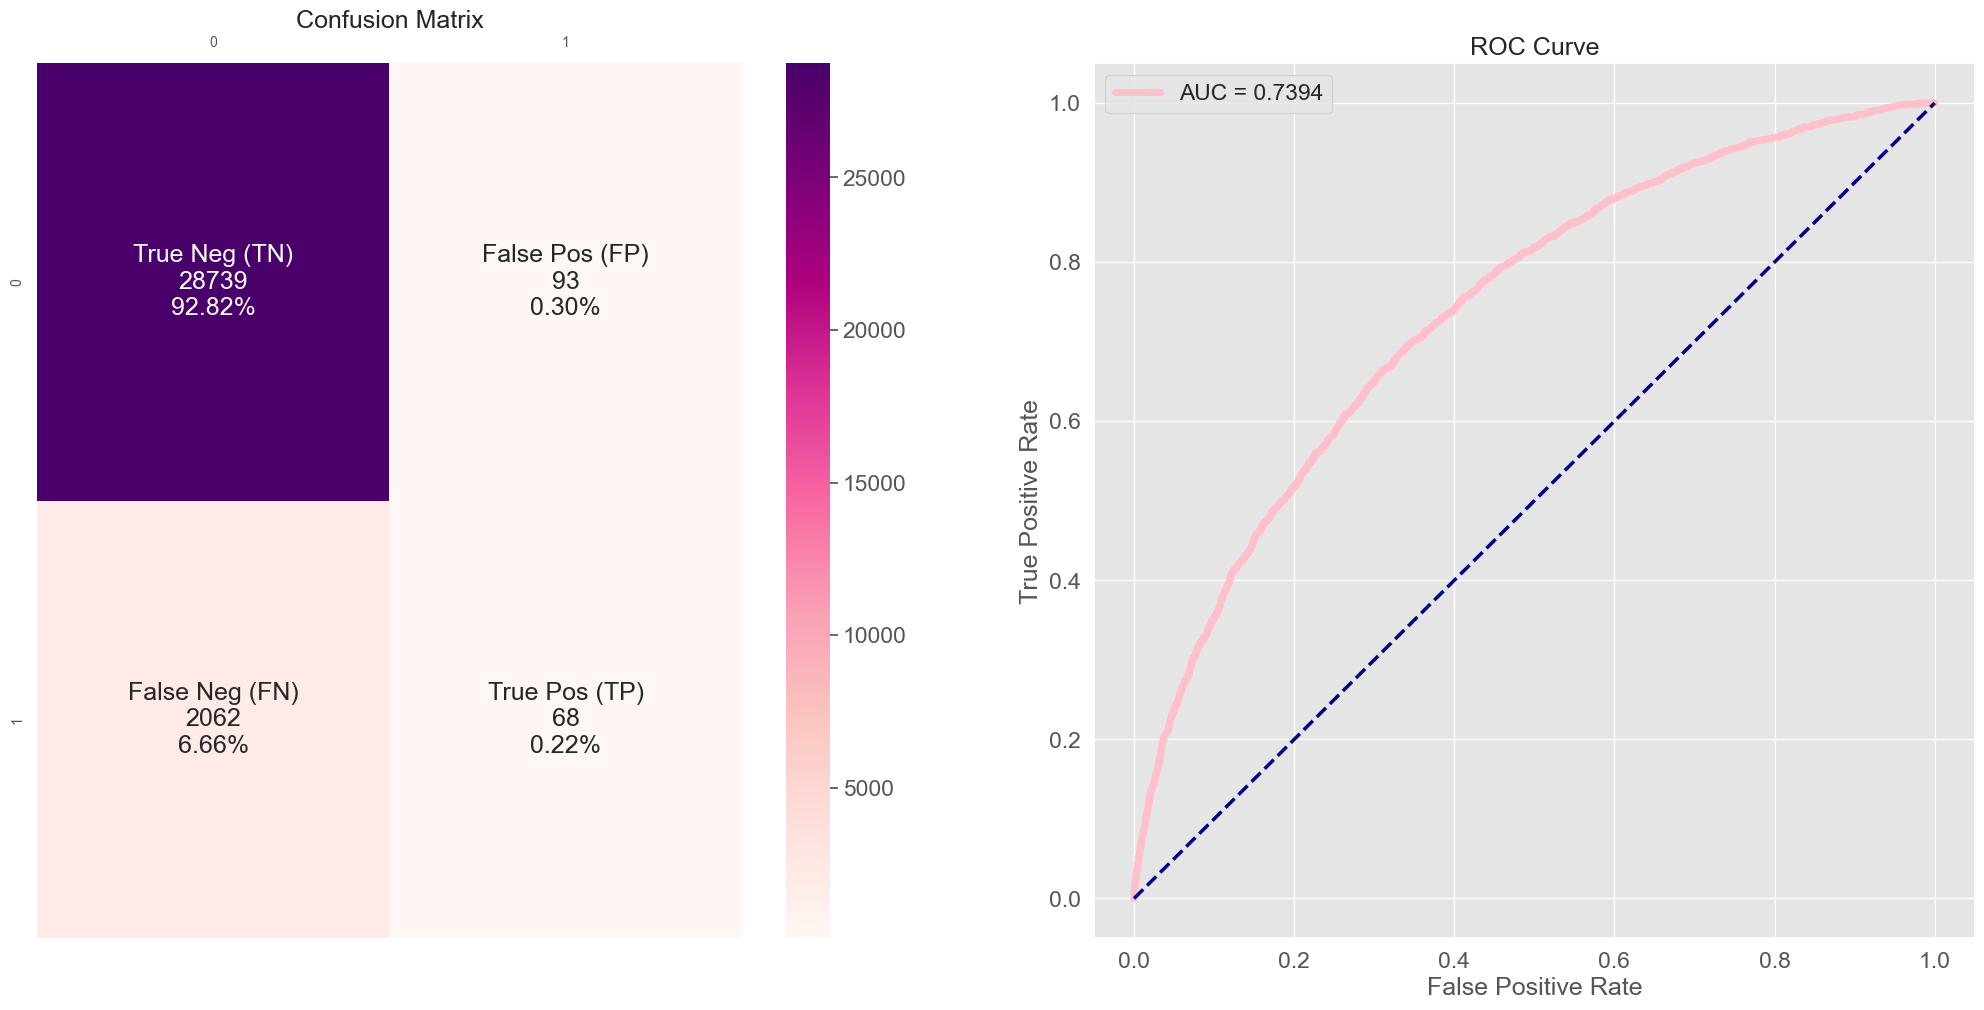

True negative =  28739
False positive =  93
False negative =  2062
True positive =  68
time: 1.12 s (started: 2023-07-05 11:43:52 +02:00)


In [252]:
# Appliquer la fonction "cf_matrix_roc_auc" pour calculer les valeurs des vrais négatifs (TN), faux positifs (FP), faux négatifs (FN) et vrais positifs (TP)
# Les paramètres passés à la fonction sont :
# - "y_test" : les vraies étiquettes de la classe cible
# - "prediction" : les étiquettes prédites par le modèle
# - "probability" : les probabilités de la classe positive prédites par le modèle
# - (25, 25) : la taille de la figure pour afficher la matrice de confusion et la courbe ROC
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (25, 25))


In [253]:
# Appel de la fonction "score_banq" pour calculer le score de gain
# Les paramètres passés à la fonction sont :
# - tn : le nombre de vrais négatifs (True Negatives)
# - fp : le nombre de faux positifs (False Positives)
# - fn : le nombre de faux négatifs (False Negatives)
# - tp : le nombre de vrais positifs (True Positives)
# - 10 : le gain pour un vrai positif (True Positive Gain)
# - -1 : le coût pour un faux positif (False Positive Cost)
# - -100 : le coût pour un faux négatif (False Negative Cost)
# - 0 : le coût pour un vrai négatif (True Negative Cost)
score_gain = score_banq(tn, fp, fn, tp, 10, -1, -100, 0)
score_gain

0.6091253074589928

time: 0 ns (started: 2023-07-05 11:43:57 +02:00)


In [254]:
# Ajout des métriques du modèle de régression logistique à la DataFrame
comparison_smote_lgbm = pd.DataFrame(
        {
            "Modele": "SMOTE - LGBMClassifier",
            "Accuracy": accuracy,            # Précision globale du modèle (TP + TN) / (TP + TN + FP + FN)
            "AUC": AUC,                      # Aire sous la courbe ROC du modèle
            "Recall class 1": recall,        # Rappel (recall) de la classe 1 (défaut de paiement) du modèle
            "F1": f1,                        # Score F1, mesure harmonique entre la précision et le rappel
            "TP": tp,                        # Nombre de vrais positifs du modèle (prédictions correctes de la classe 1)
            "Precision": precision,          # Précision du modèle TP / (TP + FP)
            "FN": fn,                        # Nombre de faux négatifs du modèle (prédictions erronées de la classe 1)
            "score Gain": score_gain,        # Score Gain calculé à partir des coûts spécifiés
            "time": prediction_time          # Temps de prédiction pour le modèle
        },
        index=[8],                          # Utilisation de l'index 0 pour ajouter une seule ligne au DataFrame
    )

# Affichage du DataFrame contenant les métriques de performance du modèle de régression logistique
comparison_model = pd.concat([comparison_model, comparison_smote_lgbm])
comparison_model

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,score Gain,time
0,Baseline - Regression Logistique,0.931400,0.743208,0.008920,0.017576,19,0.593750,2111,0.601543,0.056971
1,Baseline - LGBMClassifier,0.931077,0.762079,0.008451,0.016590,18,0.450000,2112,0.601167,3.216664
2,Class Weight - Regression Logistique,0.688263,0.743127,0.669484,0.228087,1426,0.137459,704,0.681548,0.073802
3,Class Weight - LGBMClassifier,0.742426,0.760828,0.637559,0.254045,1358,0.158626,772,0.704928,2.328351
4,RandomUnderSampler - Regression Logistique,0.678477,0.739971,0.666197,0.221840,1419,0.133077,711,0.674086,0.086767
5,RandomUnderSampler - LGBMClassifier,0.690750,0.754818,0.682629,0.232957,1454,0.140442,676,0.687846,1.700519
6,RandomOverSampler - Regression Logistique,0.688586,0.742813,0.667136,0.227651,1421,0.137242,709,0.680916,0.065823
7,RandomOverSampler - LGBMClassifier,0.744299,0.758990,0.628169,0.252620,1338,0.158100,792,0.702774,2.714450
8,SMOTE - Regression Logistique,0.931271,0.728359,0.013146,0.025641,28,0.518519,2102,0.602970,0.089766
8,SMOTE - LGBMClassifier,0.930399,0.739370,0.031925,0.059363,68,0.422360,2062,0.609125,1.734061


time: 47 ms (started: 2023-07-05 11:44:10 +02:00)


### 8 - Comparaison modèles

#### 8.1 Baseline
comparer les 2 modèles de base

In [259]:
# Filtrer le DataFrame sur la colonne "Modele" pour ne conserver que les lignes avec baseline
baseline = comparison_model[comparison_model["Modele"].str.contains("Baseline")]
baseline

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,score Gain,time
0,Baseline - Regression Logistique,0.931400,0.743208,0.008920,0.017576,19,0.59375,2111,0.601543,0.056971
1,Baseline - LGBMClassifier,0.931077,0.762079,0.008451,0.016590,18,0.45000,2112,0.601167,3.216664


time: 16 ms (started: 2023-07-05 11:46:45 +02:00)


In [260]:
baseline.to_csv("comparison_baseline.csv", index=False)

time: 62 ms (started: 2023-07-05 11:46:54 +02:00)


L'AUC est maximisé avec l'algorithme  LGBMClassifier en Baseline.

Le Recall pour la class 1 est maximisé avec l'algorithme  Regression Logistique en Baseline,on rate donc le moins de TP avec cet algorithme.

Le nombre de TP et FN est presque similaire pour les deux algprithmes.

Le F1_score est maximisé avec l'algorithme  Regression Logistique en Baseline.

La métrique personnelle créée permet de dire que c'est avec l'algorithme Regression Logistique en Baseline que la Banque peut maximiser ses gains lors de l'acceptation d'un prêt.

En Baseline le modèle optimal choisi est  Regression Logistique

#### 8.2 Class_weight 
comparer les 2 modèles avec Class_weight qui est à "balanced" intégré au modèle

In [263]:
# Filtrer le DataFrame sur la colonne "Modele" pour ne conserver que les lignes avec class weight
class_Weight = comparison_model[comparison_model["Modele"].str.contains("Class Weight")]
class_Weight

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,score Gain,time
2,Class Weight - Regression Logistique,0.688263,0.743127,0.669484,0.228087,1426,0.137459,704,0.681548,0.073802
3,Class Weight - LGBMClassifier,0.742426,0.760828,0.637559,0.254045,1358,0.158626,772,0.704928,2.328351


time: 31 ms (started: 2023-07-05 12:04:28 +02:00)


In [ ]:
class_Weight.to_csv("comparison_class_weight.csv", index=False)

L'AUC est maximisé avec l'algorithme LGBMClassifier.

Le Recall est maximisé avec l'algorithme Régression logistique, on rate donc le moins de TP avec cet algorithme.

Le nombre de TP (LE PRET N'EST PAS ACCORDE ET LE CLIENT NE PEUT PAS REMBOURSER LE PRET) est maximisé avec l'algorithme Régression logistique.

Le F1_score est maximisé avec l'algorithme LGBMClassifier.

Le nombre de FN ( LE PRET EST ACCORDE MAIS LE CLIENT NE PEUT PAS REMBOURSER LE PRET) est minimisé avec l'algorithme de Régression logistique.

La métrique personnelle créée permet de dire que c'est avec l'algorithme LGBMClassifier que la Banque peut maximiser ses gains lors de l'acceptation d'un prêt.

Avec la méthode Class_weight='balanced'et si on se base sur la métrique d'optimisation des coûts, il s'agit de l'algorithme LGBMClassifier qui maximise les gains.

#### 8.3 Undersampling 

In [265]:
# Filtrer le DataFrame sur la colonne "Modele" pour ne conserver que les lignes avec RandomUnderSampler
randomUnderSampler = comparison_model[comparison_model["Modele"].str.contains("RandomUnderSampler")]
randomUnderSampler

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,score Gain,time
4,RandomUnderSampler - Regression Logistique,0.678477,0.739971,0.666197,0.221840,1419,0.133077,711,0.674086,0.086767
5,RandomUnderSampler - LGBMClassifier,0.690750,0.754818,0.682629,0.232957,1454,0.140442,676,0.687846,1.700519


time: 31 ms (started: 2023-07-05 12:12:32 +02:00)


In [266]:
randomUnderSampler.to_csv("comparison_RandomUnderSampler.csv", index=False)

time: 0 ns (started: 2023-07-05 12:12:39 +02:00)


L'AUC est maximisé avec l'algorithme LGBMClassifier.

Le Recall est maximisé avec l'algorithme LGBMClassifier,on rate donc le moins de TP avec cet algorithme.

Le nombre de TP (LE PRET N'EST PAS ACCORDE ET LE CLIENT NE PEUT PAS REMBOURSER LE PRET) est maximisé avec l'algorithme LGBMClassifier.

Le F1_score est maximisé avec l'algorithme LGBMClassifier.

Le nombre de FN ( LE PRET EST ACCORDE MAIS LE CLIENT NE PEUT PAS REMBOURSER LE PRET) est minimisé avec l'algorithme LGBMClassifier.

La métrique personnelle créée permet de dire que c'est avec l'algorithme LGBMClassifier que la Banque peut maximiser ses gains lors de l'acceptation d'un prêt.

Ici, avec la méthode de undersampler, il est clair qu'il s'agit de l'algorithme LGBMClassifier qui est optimal pour notre problème.

#### 8.4 Oversampling

In [267]:
# Filtrer le DataFrame sur la colonne "Modele" pour ne conserver que les lignes avec RandomOverSampler
randomOverSampler = comparison_model[comparison_model["Modele"].str.contains("RandomOverSampler")]
randomOverSampler

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,score Gain,time
6,RandomOverSampler - Regression Logistique,0.688586,0.742813,0.667136,0.227651,1421,0.137242,709,0.680916,0.065823
7,RandomOverSampler - LGBMClassifier,0.744299,0.758990,0.628169,0.252620,1338,0.158100,792,0.702774,2.714450


time: 16 ms (started: 2023-07-05 12:19:04 +02:00)


In [268]:
randomOverSampler.to_csv("comparison_RandomOverSampler.csv", index=False)

time: 16 ms (started: 2023-07-05 12:19:11 +02:00)


L'AUC est maximisé avec l'algorithme LGBMClassifier.

Le Recall est maximisé avec l'algorithme Régression logistique , on rate donc le moins de TP avec cet algorithme.

Le nombre de TP (LE PRET N'EST PAS ACCORDE ET LE CLIENT NE PEUT PAS REMBOURSER LE PRET) est maximisé avec l'algorithme Régression logistique.

Le F1_score est maximisé avec l'algorithme LGBMClassifier.

Le nombre de FN ( LE PRET EST ACCORDE MAIS LE CLIENT NE PEUT PAS REMBOURSER LE PRET) est minimisé avec l'algorithme Régression logistique.

La métrique personnelle créée permet de dire que c'est avec l'algorithme LGBMClassifier que la Banque peut maximiser ses gains lors de l'acceptation d'un prêt.

Avec la méthode oversampler, et si on se base sur la métrique d'optimisation des coups, il s'agit de l'algorithme LGBMClassifier qui maximise les gains.

#### 8.5 Oversampling (SMOTE)

In [269]:
# Filtrer le DataFrame sur la colonne "Modele" pour ne conserver que les lignes avec SMOTE
smote = comparison_model[comparison_model["Modele"].str.contains("SMOTE")]
smote

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,score Gain,time
8,SMOTE - Regression Logistique,0.931271,0.728359,0.013146,0.025641,28,0.518519,2102,0.602970,0.089766
8,SMOTE - LGBMClassifier,0.930399,0.739370,0.031925,0.059363,68,0.422360,2062,0.609125,1.734061


time: 16 ms (started: 2023-07-05 12:22:25 +02:00)


In [270]:
smote.to_csv("comparison_smote.csv", index=False)

time: 16 ms (started: 2023-07-05 12:22:28 +02:00)


L'AUC est maximisé avec l'algorithme LGBMClassifier.

Le Recall est maximisé avec l'algorithme LGBMClassifier, on rate donc le moins de TP avec cet algorithme.

Le nombre de TP (LE PRET N'EST PAS ACCORDE ET LE CLIENT NE PEUT PAS REMBOURSER LE PRET) est maximisé avec l'algorithme LGBMClassifier.

Le F1_score est maximisé avec LGBMClassifier.

Le nombre de FN ( LE PRET EST ACCORDE MAIS LE CLIENT NE PEUT PAS REMBOURSER LE PRET) est minimisé avec l'algorithme LGBMClassifier.

La métrique personnelle créée permet de dire que c'est avec l'algorithme de LGBMClassifier que la Banque peut maximiser ses gains lors de l'acceptation d'un prêt.

Avec la méthode SMOTE, on peut dire que l'algorithme optimal est l'algorithme LGBMClassifier. 

Je peux donc dire que l'algorithme optimal après avoir utilisé SMOTE est LGBMClassifier.

#### 8.6 Best of the Best sur toute les approches 

In [271]:
comparison_model

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,score Gain,time
0,Baseline - Regression Logistique,0.931400,0.743208,0.008920,0.017576,19,0.593750,2111,0.601543,0.056971
1,Baseline - LGBMClassifier,0.931077,0.762079,0.008451,0.016590,18,0.450000,2112,0.601167,3.216664
2,Class Weight - Regression Logistique,0.688263,0.743127,0.669484,0.228087,1426,0.137459,704,0.681548,0.073802
3,Class Weight - LGBMClassifier,0.742426,0.760828,0.637559,0.254045,1358,0.158626,772,0.704928,2.328351
4,RandomUnderSampler - Regression Logistique,0.678477,0.739971,0.666197,0.221840,1419,0.133077,711,0.674086,0.086767
5,RandomUnderSampler - LGBMClassifier,0.690750,0.754818,0.682629,0.232957,1454,0.140442,676,0.687846,1.700519
6,RandomOverSampler - Regression Logistique,0.688586,0.742813,0.667136,0.227651,1421,0.137242,709,0.680916,0.065823
7,RandomOverSampler - LGBMClassifier,0.744299,0.758990,0.628169,0.252620,1338,0.158100,792,0.702774,2.714450
8,SMOTE - Regression Logistique,0.931271,0.728359,0.013146,0.025641,28,0.518519,2102,0.602970,0.089766
8,SMOTE - LGBMClassifier,0.930399,0.739370,0.031925,0.059363,68,0.422360,2062,0.609125,1.734061


time: 16 ms (started: 2023-07-05 12:43:09 +02:00)


In [272]:
comparison_model.to_csv("all_comparison_method.csv", index=False)

time: 0 ns (started: 2023-07-05 12:44:05 +02:00)


In [276]:
# Triez le DataFrame sur la colonne "AUC"  ordre décroissant
comparison_model_sorted = comparison_model.sort_values(by=["AUC"], ascending=False)
comparison_model_sorted

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,score Gain,time
1,Baseline - LGBMClassifier,0.931077,0.762079,0.008451,0.016590,18,0.450000,2112,0.601167,3.216664
3,Class Weight - LGBMClassifier,0.742426,0.760828,0.637559,0.254045,1358,0.158626,772,0.704928,2.328351
7,RandomOverSampler - LGBMClassifier,0.744299,0.758990,0.628169,0.252620,1338,0.158100,792,0.702774,2.714450
5,RandomUnderSampler - LGBMClassifier,0.690750,0.754818,0.682629,0.232957,1454,0.140442,676,0.687846,1.700519
0,Baseline - Regression Logistique,0.931400,0.743208,0.008920,0.017576,19,0.593750,2111,0.601543,0.056971
2,Class Weight - Regression Logistique,0.688263,0.743127,0.669484,0.228087,1426,0.137459,704,0.681548,0.073802
6,RandomOverSampler - Regression Logistique,0.688586,0.742813,0.667136,0.227651,1421,0.137242,709,0.680916,0.065823
4,RandomUnderSampler - Regression Logistique,0.678477,0.739971,0.666197,0.221840,1419,0.133077,711,0.674086,0.086767
8,SMOTE - LGBMClassifier,0.930399,0.739370,0.031925,0.059363,68,0.422360,2062,0.609125,1.734061
8,SMOTE - Regression Logistique,0.931271,0.728359,0.013146,0.025641,28,0.518519,2102,0.602970,0.089766


time: 31 ms (started: 2023-07-05 12:51:26 +02:00)


Nous sélectionnons les meilleurs  modèles par chaque approche

* Regression Logistique en Baseline
* LGBMClassifier en Class Weight
* LGBMClassifier en RandomUnderSampler
* LGBMClassifier en RandomOverSampler
* LGBMClassifier en smote 

In [280]:
# Liste des modèles à conserver
best_model = ['Baseline - Regression Logistique', 'Class Weight - LGBMClassifier', 'RandomUnderSampler - LGBMClassifier',
              'RandomOverSampler - LGBMClassifier','SMOTE - LGBMClassifier']

# Filtrer le dataset en utilisant
comparison_best_model = comparison_model.loc[comparison_model['Modele'].isin(best_model)]

comparison_best_model.sort_values()

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,score Gain,time
0,Baseline - Regression Logistique,0.931400,0.743208,0.008920,0.017576,19,0.593750,2111,0.601543,0.056971
3,Class Weight - LGBMClassifier,0.742426,0.760828,0.637559,0.254045,1358,0.158626,772,0.704928,2.328351
5,RandomUnderSampler - LGBMClassifier,0.690750,0.754818,0.682629,0.232957,1454,0.140442,676,0.687846,1.700519
7,RandomOverSampler - LGBMClassifier,0.744299,0.758990,0.628169,0.252620,1338,0.158100,792,0.702774,2.714450
8,SMOTE - LGBMClassifier,0.930399,0.739370,0.031925,0.059363,68,0.422360,2062,0.609125,1.734061


time: 31 ms (started: 2023-07-05 13:12:25 +02:00)


In [285]:
comparison_best_model.sort_values(by=["TP"], ascending=False)

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,score Gain,time
5,RandomUnderSampler - LGBMClassifier,0.690750,0.754818,0.682629,0.232957,1454,0.140442,676,0.687846,1.700519
3,Class Weight - LGBMClassifier,0.742426,0.760828,0.637559,0.254045,1358,0.158626,772,0.704928,2.328351
7,RandomOverSampler - LGBMClassifier,0.744299,0.758990,0.628169,0.252620,1338,0.158100,792,0.702774,2.714450
8,SMOTE - LGBMClassifier,0.930399,0.739370,0.031925,0.059363,68,0.422360,2062,0.609125,1.734061
0,Baseline - Regression Logistique,0.931400,0.743208,0.008920,0.017576,19,0.593750,2111,0.601543,0.056971


time: 16 ms (started: 2023-07-05 13:16:30 +02:00)


In [298]:
# Classement des modèles en fonctions des métrique

# Métriques à considérer pour le classement
metrics = ["Accuracy", "AUC", "Recall class 1", "F1", "TP", "Precision","score Gain"]

# Dictionnaire pour stocker les informations des meilleurs modèles pour chaque métrique
best_models = {}

# Classement des modèles pour chaque métrique
for metric in metrics:
    # Trouver l'indice du modèle ayant la valeur maximale pour la métrique donnée
    best_model_index = comparison_best_model[metric].idxmax()

    # Obtenir le nom du meilleur modèle à l'aide de l'indice et la colonne "Modele"
    best_model_name = comparison_best_model.loc[best_model_index, "Modele"]

    # Stocker le nom du meilleur modèle dans le dictionnaire
    best_models[metric] = best_model_name
    
for metric, model_name in best_models.items():
    print(f"Meilleur modèle pour la métrique '{metric}': {model_name}")
    print("---------------------")

Meilleur modèle pour la métrique 'Accuracy': Baseline - Regression Logistique
---------------------
Meilleur modèle pour la métrique 'AUC': Class Weight - LGBMClassifier
---------------------
Meilleur modèle pour la métrique 'Recall class 1': RandomUnderSampler - LGBMClassifier
---------------------
Meilleur modèle pour la métrique 'F1': Class Weight - LGBMClassifier
---------------------
Meilleur modèle pour la métrique 'TP': RandomUnderSampler - LGBMClassifier
---------------------
Meilleur modèle pour la métrique 'Precision': Baseline - Regression Logistique
---------------------
Meilleur modèle pour la métrique 'score Gain': Class Weight - LGBMClassifier
---------------------
time: 16 ms (started: 2023-07-05 13:46:48 +02:00)


In [299]:
# Classement des modèles en fonctions des métrique

# Métriques à considérer pour le classement
metrics = ["FN","time"]

# Dictionnaire pour stocker les informations des meilleurs modèles pour chaque métrique
best_models = {}

# Classement des modèles pour chaque métrique
for metric in metrics:
    # Trouver l'indice du modèle ayant la valeur minimale pour la métrique donnée
    best_model_index = comparison_best_model[metric].idxmin()

    # Obtenir le nom du meilleur modèle à l'aide de l'indice et la colonne "Modele"
    best_model_name = comparison_best_model.loc[best_model_index, "Modele"]

    # Stocker le nom du meilleur modèle dans le dictionnaire
    best_models[metric] = best_model_name
    
for metric, model_name in best_models.items():
    print(f"Meilleur modèle pour la métrique '{metric}': {model_name}")
    print("---------------------")

Meilleur modèle pour la métrique 'FN': RandomUnderSampler - LGBMClassifier
---------------------
Meilleur modèle pour la métrique 'time': Baseline - Regression Logistique
---------------------
time: 15 ms (started: 2023-07-05 13:46:58 +02:00)


In [281]:
comparison_best_model.to_csv("comparison_finale.csv", index=False)

time: 16 ms (started: 2023-07-05 13:13:09 +02:00)


L'AUC est maximisé avec l'algorithme Class Weight - LGBMClassifier.

Le Recall est maximisé avec l'algorithme RandomUnderSampler - LGBMClassifier.

Le F1_score est maximisé avec l'algorithme Class Weight - LGBMClassifier.

Le nombre de TP (LE PRET N'EST PAS ACCORDE ET LE CLIENT NE PEUT PAS REMBOURSER LE PRET) est maximisé avec l'algorithme RandomUnderSampler - LGBMClassifier.

Le nombre de FN ( LE PRET EST ACCORDE MAIS LE CLIENT NE PEUT PAS REMBOURSER LE PRET) est minimisé avec l'algorithme RandomUnderSampler - LGBMClassifier.

La métrique personnelle créée permet de dire que c'est avec l'algorithme RandomOverSampler - LGBMClassifier que la Banque peut maximiser ses gains lors de l'acceptation d'un prêt.

Au vue des comparaisons précédentes, RandomUnderSampler - LGBMClassifier et Class Weight - LGBMClassifier sont les modèles optimums pour notre problème mais je décide de garder pour la suite l'RandomUnderSampler - LGBMClassifier qui a le meilleur recall ce qui évitera d'accorder des prêts à des personnes qui ne peuvent pas rembourser(le but est d'avoir un recall important pour la prédiction des 1) tout en ayant un gain d'argent important pour la banque (score gain important).

### 9 - Analyse avec le meilleur modèle retenu 

#### 9.1 Exécution au seuil 0.5 (de base dans sklearn)

In [332]:
print(f"Label 1, Avant d'utiliser RandomUnderSampler: {sum(y_train==1)} ")
print(f"Label 0, Avant d'utiliser RandomUnderSampler: {sum(y_train==0)} ")

Label 1, Avant d'utiliser RandomUnderSampler: 8654 
Label 0, Avant d'utiliser RandomUnderSampler: 115191 
time: 31 ms (started: 2023-07-05 15:55:39 +02:00)


In [333]:
# Création d'une instance de RandomUnderSampler avec un random_state fixé à 0 pour la reproductibilité
rus = RandomUnderSampler(random_state=0)

# Application du suréchantillonnage aléatoire aux données d'entraînement X_train et y_train
# Les données suréchantillonnage équilibrées sont stockées dans X_train_undersampled et y_train_undersampled
X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train, y_train)

# Conversion des données suréchantillonnage en DataFrame pandas
# Cela permet de garder les noms de colonnes de X_train pour faciliter l'utilisation ultérieure
X_train_undersampled = pd.DataFrame(X_train_undersampled, columns=X_train.columns)


time: 484 ms (started: 2023-07-05 15:55:39 +02:00)


In [334]:
print(f"Label 1, Après avoir utilisé RandomUnderSampler: {sum(y_train_undersampled==1)}")
print(f"Label 0, Après avoir utilisé RandomUnderSampler: {sum(y_train_undersampled==0)}")

Label 1, Après avoir utilisé RandomUnderSampler: 8654
Label 0, Après avoir utilisé RandomUnderSampler: 8654
time: 16 ms (started: 2023-07-05 15:55:39 +02:00)


In [335]:
# Définition des hyperparamètres optimaux pour le modèle LightGBM
best_model = LGBMClassifier(
    boosting_type='gbdt',  # Type d'algorithme de boosting à utiliser ('gbdt' est l'algorithme de boosting par défaut)
    num_leaves=31,  # Nombre maximal de feuilles dans un arbre (contrôle la complexité de l'arbre)
    max_depth=-1,  # Profondeur maximale des arbres (valeur négative indique aucune limite de profondeur)
    learning_rate=0.01,  # Taux d'apprentissage (contrôle l'ampleur des mises à jour des poids)
    n_estimators=700,  # Nombre d'arbres (estimateurs) à utiliser dans l'ensemble (boosting)
    subsample_for_bin=200000,  # Nombre d'échantillons à utiliser pour l'histogramme des bins
    objective='binary',  # Fonction objectif à optimiser ('binary' pour la classification binaire)
    class_weight=None,  # Poids des classes ajustés automatiquement pour l'équilibrage des classes
    min_split_gain=0.0,  # Gain minimal requis pour effectuer une séparation lors de la construction d'arbre
    min_child_weight=0.001,  # Poids minimal requis pour les feuilles des arbres
    min_child_samples=20,  # Nombre minimal d'échantillons requis pour une feuille dans un arbre
    subsample=1.0,  # Pourcentage d'échantillons à utiliser pour chaque arbre (1.0 signifie utiliser tous les échantillons)
    subsample_freq=0,  # Fréquence de sous-échantillonnage (0 signifie aucun sous-échantillonnage)
    colsample_bytree=1.0,  # Pourcentage de fonctionnalités à utiliser pour chaque arbre (1.0 signifie utiliser toutes les fonctionnalités)
    reg_alpha=0.0,  # Terme de régularisation L1 pour empêcher le surajustement
    reg_lambda=0.0,  # Terme de régularisation L2 pour empêcher le surajustement
    random_state=None,  # Graine aléatoire pour la reproductibilité des résultats
    n_jobs=-1,  # Nombre de cœurs de processeur à utiliser lors du calcul (-1 signifie utiliser tous les cœurs disponibles)
    silent=True,  # Contrôle la verbosité du modèle (True signifie aucune sortie affichée)
    importance_type='split'  # Méthode pour calculer l'importance des fonctionnalités ('split' utilise le nombre de splits)
)


time: 16 ms (started: 2023-07-05 15:55:39 +02:00)


In [336]:
# Entrainer le modèle avec les données undersampled
model_fitted = best_model.fit(X_train_undersampled, y_train_undersampled)

time: 9.45 s (started: 2023-07-05 15:55:39 +02:00)


In [337]:
# enregistrer (sérialiser  le modèle entraîné et le conserver pour une utilisation ultérieure
# 'wb' indique l'ouverture du fichier en mode écriture binaire
pickle.dump(model_fitted, open('best_final_prediction.pickle', 'wb'))

time: 203 ms (started: 2023-07-05 15:55:49 +02:00)


In [338]:
# Faire des prédictions de probabilité pour chaque classe sur l'ensemble de test (X_test)
probability = best_model.predict_proba(X_test)

# Extraire les probabilités associées à la classe 1 (probabilité d'être en défaut de paiement)
# Les probabilités de chaque classe sont stockées dans un tableau 2D, où la première colonne
# représente la probabilité d'appartenir à la classe 0 et la deuxième colonne représente la
# probabilité d'appartenir à la classe 1.

probability_default_payment = probability[:, 1]
# Le tableau probability_default_payment contient maintenant les probabilités d'être en
# défaut de paiement pour chaque échantillon de l'ensemble de test X_test.

probability_default_payment

array([0.32231968, 0.32729202, 0.49389514, ..., 0.30862389, 0.37784379,
       0.56461015])

time: 1.95 s (started: 2023-07-05 15:55:49 +02:00)


In [339]:
# Prédire les classes pour l'ensemble de test (X_test) à l'aide du modèle best_model
prediction = best_model.predict(X_test)

# Le tableau 'prediction' contient maintenant les classes prédites pour chaque échantillon de l'ensemble de test.
# Chaque valeur dans le tableau est une prédiction binaire :
#   - 0 : correspond à la classe "non défaut de paiement"
#   - 1 : correspond à la classe "défaut de paiement"
prediction

array([0., 0., 0., ..., 0., 0., 1.])

time: 2.14 s (started: 2023-07-05 15:55:51 +02:00)


In [340]:
# Crée un nouveau DataFrame pour stocker les prédictions du modèle.
# Les colonnes 'SK_ID_CURR' et 'probability_default_payment' au DataFrame.
predictive_class_50 = pd.DataFrame({
    'SK_ID_CURR': X_test.index,  # La première colonne 'SK_ID_CURR' contiendra les identifiants uniques des emprunteurs dans l'ensemble de test.
    'probability_default_payment': prediction  # La deuxième colonne 'probability_default_payment' contiendra les probabilités de défaut de paiement prédites par le modèle pour chaque emprunteur dans X_test.
})


time: 0 ns (started: 2023-07-05 15:55:53 +02:00)


In [341]:
predictive_class_50.head()

,SK_ID_CURR,probability_default_payment
0,316145,0.0
1,399406,0.0
2,168652,0.0
3,317387,0.0
4,371921,1.0


time: 15 ms (started: 2023-07-05 15:55:53 +02:00)


In [342]:
# Calcul de l'accuracy score en comparant les vraies étiquettes 'y_test' avec les prédictions 'prediction'.
accuracy = accuracy_score(y_test, prediction)

# Affichage du résultat de l'accuracy score 
# Le score est inséré dans le message en utilisant la méthode 'format' pour remplacer le {} par la valeur de 'accuracy'.
print(colored(f'L\'accuracy score est de {accuracy}', 'blue'))


L'accuracy score est de 0.6907499515535173
time: 16 ms (started: 2023-07-05 15:55:53 +02:00)


Le modèle a une accuracy de 69% ce qui nous permet de dire que 69% des individus sont bien classés avec ce modèle et que le modèle a une bonne justesse de prédiction.

In [343]:
# Calcul du score de précision en comparant les vraies étiquettes 'y_test' avec les prédictions 'prediction'.
# L'argument 'average' est réglé sur 'binary' car nous avons une tâche de classification binaire.
precision = precision_score(y_test, prediction, average='binary')

# Affichage du résultat du score de précision.
print(colored(f'Le score de précision est de {precision}', 'blue'))


Le score de précision est de 0.14044238385009175
time: 31 ms (started: 2023-07-05 15:55:53 +02:00)


Le modèle a une précision de 14% ce qui montre qu'une proportion de 86% de classification positive (individus en défaut de paiement) était correcte donc il y a 14% de vrai positif pour 86% de faux positif. Moins il y a de faux positif plus la précision se rapproche de 1,0. 

In [344]:
# Calcul du score de recall (rappel) en comparant les vraies étiquettes 'y_test' avec les prédictions 'prediction'.
# L'argument 'average' est réglé sur 'binary' car nous avons une tâche de classification binaire.
recall = recall_score(y_test, prediction, average='binary')

# Affichage du résultat du score de recall 
print(colored(f'Le score recall est de {recall}', 'blue'))


Le score recall est de 0.6826291079812207
time: 31 ms (started: 2023-07-05 15:55:53 +02:00)


Cette métrique montre la proportion de résultats positifs réels correctement identifiée. Un modèle ne produisant pas de faux négatif à un rappel de 1. 

Notre modèle a un rappel de 0,68. En d'autres termes, il identifie correctement 68 % des individus défaillants pour le paiement.



In [345]:
# Calcul du score F1 en comparant les vraies étiquettes 'y_test' avec les prédictions 'prediction'.
# L'argument 'average' est réglé sur 'binary' car nous avons une tâche de classification binaire.
f1 = f1_score(y_test, prediction, average='binary')

# Affichage du résultat du score F1 
print(colored(f'Le score f1 est de {f1}', 'blue'))


Le score f1 est de 0.2329568212769366
time: 31 ms (started: 2023-07-05 15:55:53 +02:00)


Le score F1 est la moyenne harmonique de la précision et du recall qui est une mesure de la performance de la capacité de classification du modèle car il prend en compte le nombre de faux positifs et négatifs. Plus ce terme est grand, plus le modèle est performant. 

In [346]:
# Calcul de l'AUC (Area Under the Curve) en utilisant les étiquettes réelles 'y_test' et les probabilités de classe positive 'probability_default_payment'.
AUC = roc_auc_score(y_test, probability_default_payment)

# Affichage du résultat de l'AUC 
print(colored(f'Le score AUC est de {AUC}', 'blue'))


Le score AUC est de 0.7548178406361216
time: 31 ms (started: 2023-07-05 15:55:53 +02:00)


L'AUC correspond à l'aire sous la courbe ROC Plus l’AUC est grande, meilleur est le modèle.

In [347]:
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
df_matrice_confusion = matrix_TN_FN(y_test, prediction)

# Affichage de la matrice de confusion
print("Matrice de confusion :")
df_matrice_confusion

Matrice de confusion :


,Predicted Negative (0),Predicted Positive (1)
Real Negative (0),19933 (TN),8899 (FP)
Real Positive (1),676 (FN),1454 (TP)


time: 31 ms (started: 2023-07-05 15:55:53 +02:00)


In [348]:
X_test.shape

(30962, 209)

time: 15 ms (started: 2023-07-05 15:55:53 +02:00)


In [349]:
X_train_undersampled.shape

(17308, 209)

time: 0 ns (started: 2023-07-05 15:55:53 +02:00)


In [350]:
# Calcul de l'AUC (Area Under the Curve) en utilisant les étiquettes réelles 'y_test' et les probabilités de classe positive 'probability_default_payment'.
roc_auc = roc_auc_score(y_test, probability_default_payment)

# Affichage du résultat de l'AUC 
print('AUC : %0.4f' % roc_auc)

# Calcul du rapport de classification en comparant les étiquettes réelles 'y_test' et les prédictions 'prediction'.
# La fonction 'classification_report' produit un rapport complet incluant les métriques de précision, rappel, F1-score et le support pour chaque classe.
report = classification_report(y_test, prediction)

# Affichage du rapport de classification.
print(report)


AUC : 0.7548
              precision    recall  f1-score   support

         0.0       0.97      0.69      0.81     28832
         1.0       0.14      0.68      0.23      2130

    accuracy                           0.69     30962
   macro avg       0.55      0.69      0.52     30962
weighted avg       0.91      0.69      0.77     30962

time: 125 ms (started: 2023-07-05 15:55:53 +02:00)


Ce modèle est intéressant car pour la détection des défauts de paiement (1), le recall est de 0,68 ce qui évitera d'accorder des prêts à des personnes qui ne peuvent pas rembourser( le but est d'avoir un recall impoortant pour la prédiction des 1).

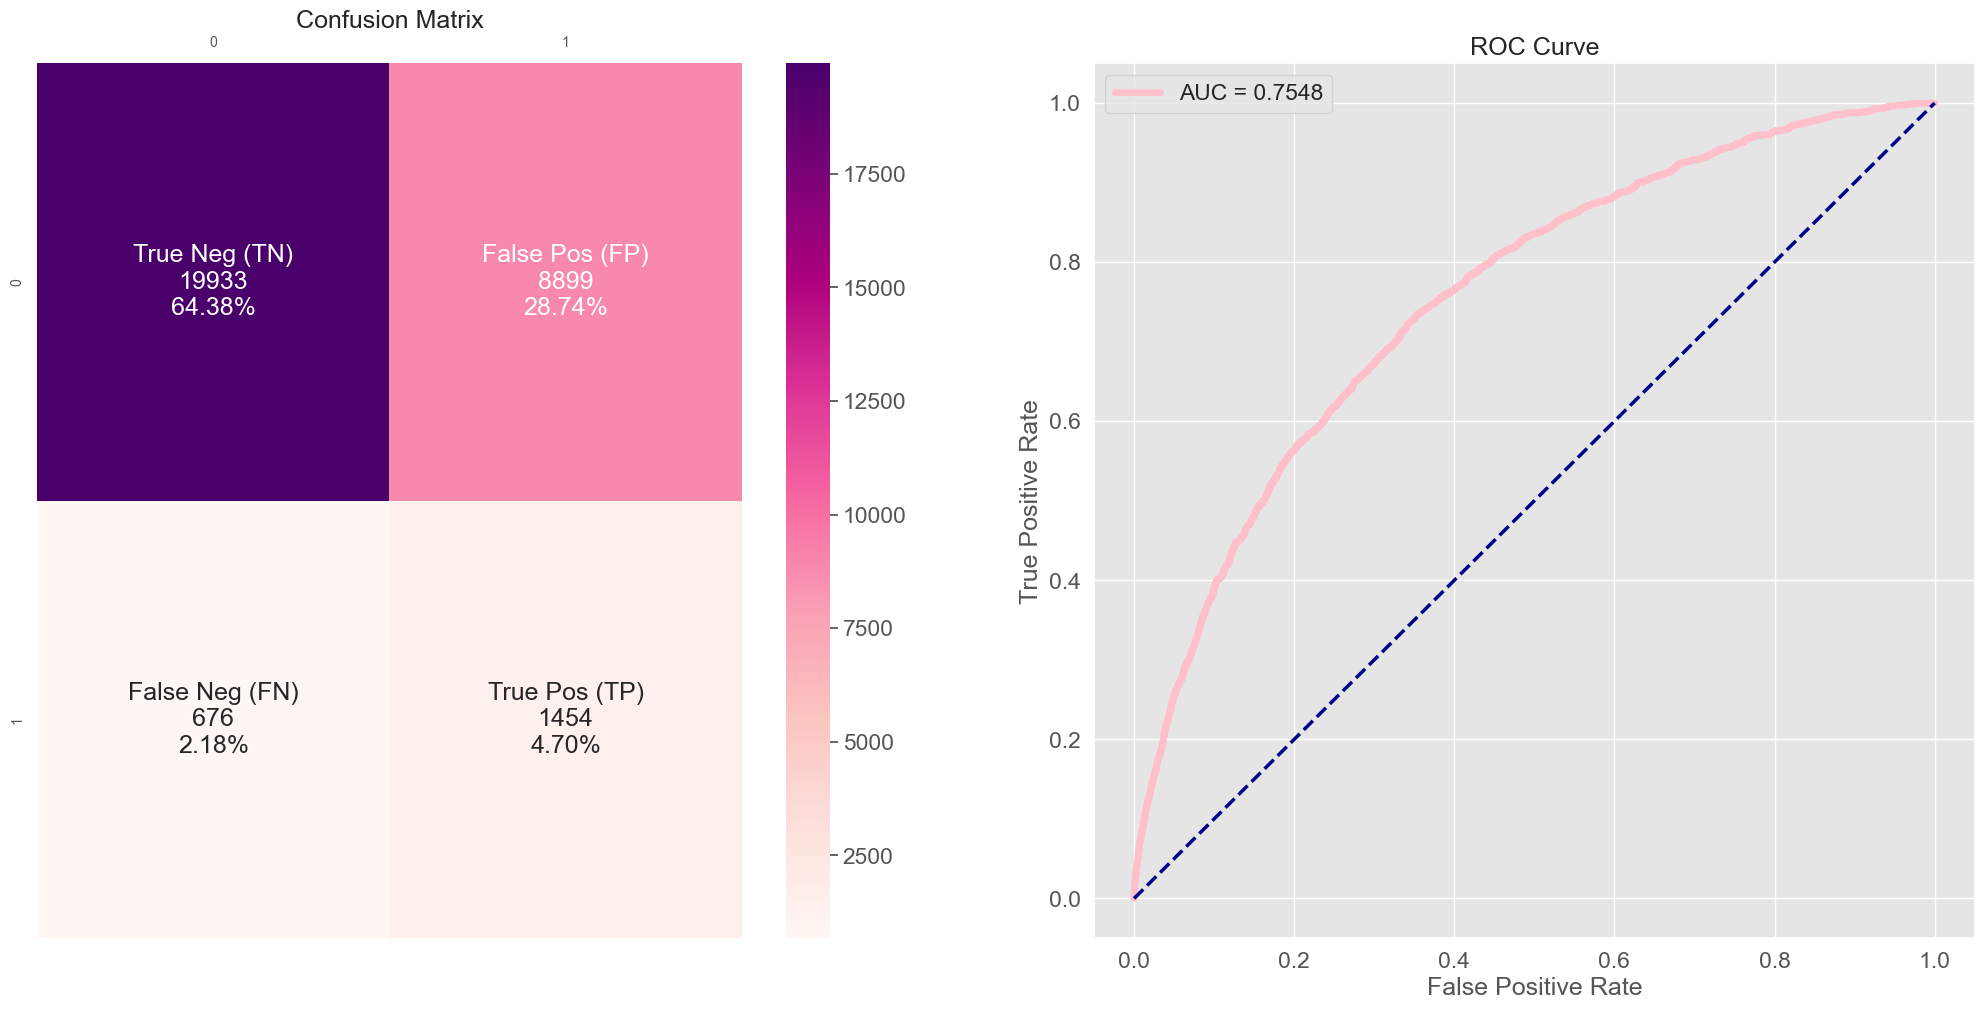

True negative =  19933
False positive =  8899
False negative =  676
True positive =  1454
time: 1.3 s (started: 2023-07-05 15:55:54 +02:00)


In [351]:
# Appliquer la fonction "cf_matrix_roc_auc" pour calculer les valeurs des vrais négatifs (TN), faux positifs (FP), faux négatifs (FN) et vrais positifs (TP)
# Les paramètres passés à la fonction sont :
# - "y_test" : les vraies étiquettes de la classe cible
# - "prediction" : les étiquettes prédites par le modèle
# - "probability" : les probabilités de la classe positive prédites par le modèle
# - (25, 25) : la taille de la figure pour afficher la matrice de confusion et la courbe ROC
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (25, 25))


In [352]:
# Appel de la fonction "score_banq" pour calculer le score de gain
# Les paramètres passés à la fonction sont :
# - tn : le nombre de vrais négatifs (True Negatives)
# - fp : le nombre de faux positifs (False Positives)
# - fn : le nombre de faux négatifs (False Negatives)
# - tp : le nombre de vrais positifs (True Positives)
# - 10 : le gain pour un vrai positif (True Positive Gain)
# - -1 : le coût pour un faux positif (False Positive Cost)
# - -100 : le coût pour un faux négatif (False Negative Cost)
# - 0 : le coût pour un vrai négatif (True Negative Cost)
score_gain = score_banq(tn, fp, fn, tp, 10, -1, -100, 0)
score_gain

0.6878461271484404

time: 0 ns (started: 2023-07-05 15:55:55 +02:00)


In [353]:
# Ajout des métriques du modèle 
comparison_thresh = pd.DataFrame(
        {
            "Modele": "Avant de déterminer le seuil optimal (0,50)",
            "Accuracy": accuracy,            # Précision globale du modèle (TP + TN) / (TP + TN + FP + FN)
            "AUC": AUC,                      # Aire sous la courbe ROC du modèle
            "Recall class 1": recall,        # Rappel (recall) de la classe 1 (défaut de paiement) du modèle
            "F1": f1,                        # Score F1, mesure harmonique entre la précision et le rappel
            "TP": tp,                        # Nombre de vrais positifs du modèle (prédictions correctes de la classe 1)
            "Precision": precision,          # Précision du modèle TP / (TP + FP)
            "FN": fn,                        # Nombre de faux négatifs du modèle (prédictions erronées de la classe 1)
            "score Gain": score_gain,        # Score Gain calculé à partir des coûts spécifiés
            "time": prediction_time          # Temps de prédiction pour le modèle
        },
        index=[0],                          # Utilisation de l'index 0 pour ajouter une seule ligne au DataFrame
    )

# Affichage du DataFrame contenant les métriques de performance du modèle 
comparison_thresh 

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,score Gain,time
0,"Avant de déterminer le seuil optimal (0,50)",0.69075,0.754818,0.682629,0.232957,1454,0.140442,676,0.687846,1.734061


time: 16 ms (started: 2023-07-05 15:55:55 +02:00)


#### 9.2 Ordre de grandeur optimal pour les coefficients de la fonction coût 

Des coefficients arbitraires ont précédemment été définis mais ceux-ci ne sont peut-être pas optimums. Le coefficient de FN est celui qui a la plus grande importance dans notre métrique mais le coefficient a-t-il le bon ordre de grandeur. Pour vérifier cela, le score gain a été recalculé avec le modèle optimal pour différents seuils de probabilité en variant l'ordre de grandeur du coefficient FN

In [358]:
# Création d'une séquence d'intervalles de seuils allant de 0 à 1 avec un pas de 0.01.
int_seuil = np.arange(0.0, 1.01, 0.01)

# Coefficients utilisés pour calculer le score en fonction des valeurs de faux positifs et faux négatifs.
coeff_fn = [-1000, -100, -10]

# Initialisation de listes pour stocker les scores en fonction des seuils pour chaque coefficient.
scor_int_1000 = []
scor_int_100 = []
scor_int_10 = []

# Regroupement des listes de scores dans une liste de listes.
scor_int = [scor_int_1000, scor_int_100, scor_int_10]

# Boucle pour calculer les scores en fonction des seuils et des coefficients.
for idx, lis in enumerate(scor_int):
    for s in int_seuil:
        # Initialisation d'une liste pour stocker les étiquettes de classe en fonction du seuil 's'.
        y_seuil = []
        # Conversion des probabilités de classe en étiquettes binaires (0 ou 1) en fonction du seuil 's'.
        for i in probability_default_payment:
            if i >= s:
                y_seuil.append(1)
            elif i < s:
                y_seuil.append(0)
        
        # Calcul de la matrice de confusion en comparant les étiquettes réelles 'y_test' avec les étiquettes binaires 'y_seuil'.
        tn, fp, fn, tp = confusion_matrix(y_test, y_seuil, labels=[0, 1]).ravel()

        # Calcul du score en utilisant la fonction 'score_banq' avec les valeurs de faux positifs, faux négatifs et les coefficients spécifiés.
        score = score_banq(tn, fp, fn, tp, 10, -1, coeff_fn[idx], 0)
        
        # Ajout du score calculé à la liste appropriée dans 'scor_int'.
        scor_int[idx].append(score)


time: 11.5 s (started: 2023-07-05 16:03:57 +02:00)


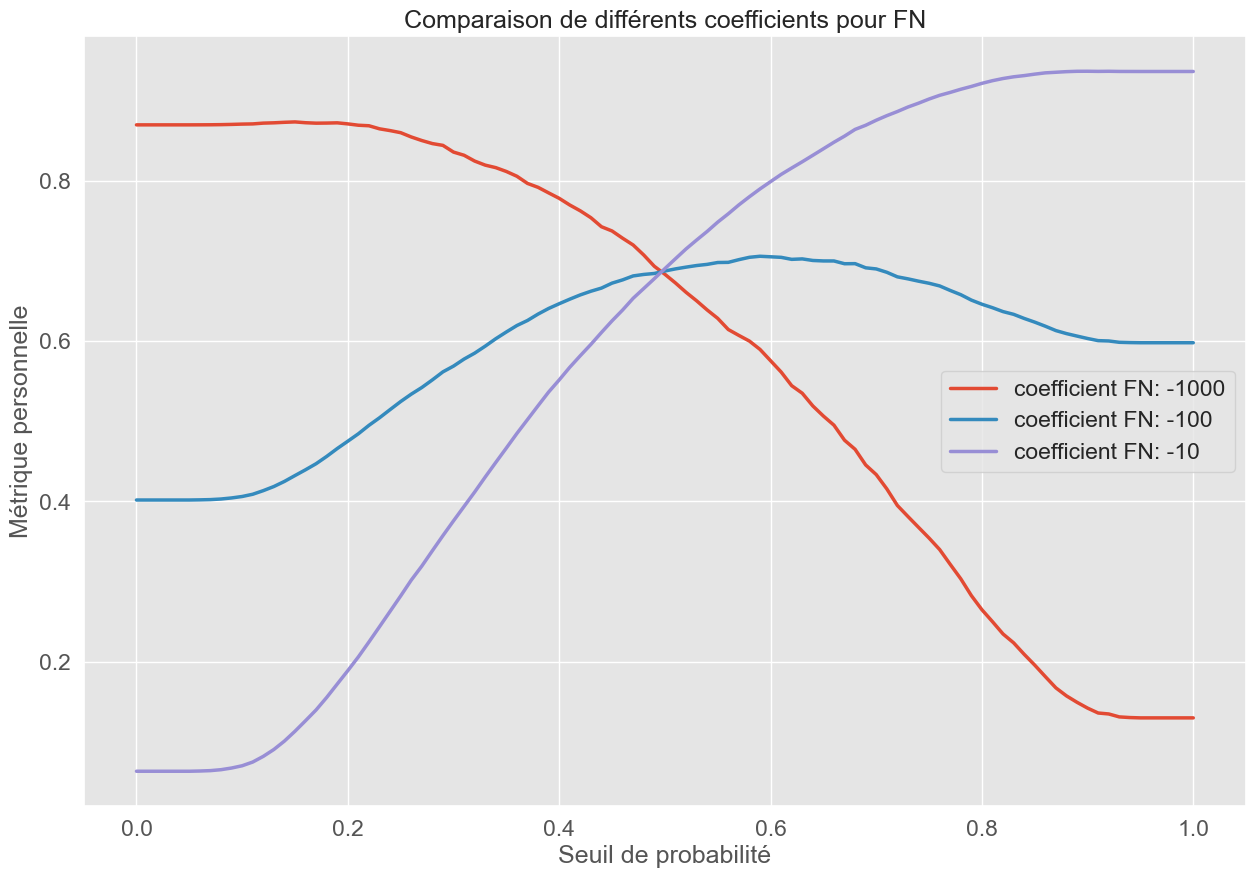

time: 578 ms (started: 2023-07-05 16:06:44 +02:00)


In [362]:
# Affichage du gain en fonction du seuil de solvabilité   

# Définition de la taille de la figure du graphique.
plt.figure(figsize=(15, 10))

# Tracé des courbes pour les scores en fonction des seuils pour chaque coefficient FN.
plt.plot(int_seuil, scor_int_1000, label="coefficient FN: -1000")
plt.plot(int_seuil, scor_int_100, label="coefficient FN: -100")
plt.plot(int_seuil, scor_int_10, label="coefficient FN: -10")

# Ajout d'étiquettes pour les axes x et y.
plt.xlabel("Seuil de probabilité")
plt.ylabel("Métrique personnelle")

# Titre du graphique.
plt.title('Comparaison de différents coefficients pour FN')

# Ajout de la légende pour identifier chaque courbe.
plt.legend()

# Affichage du graphique.
plt.show()


Ces courbes montrent que la métrique personnelle est pertinente pour notre problématique. 
Lorque l'on donne un coefficient de -1000 pour les FN, le seuil optimal pour que la banque ait le maximum de gain d'argent se situe aux alentours d'une probabilité de 0,2 à partir de laquelle on peut voir que la courbe des gains décroit rapidement. Ce coefficient est trop strict car seules les personnes avec une probabilité de défaut de paiement < 0,2% se voient accepter leur prêt ce qui correspond à peu de personnes.


Au contraire, lorsque l'on donne un coefficient de -10 pour les FN, on peut dire que la banque est trop laxiste dans le choix des clients pour l'accord d'un prêt car le seuil optimal pour que la banque ait le maximum de gain d'argent se situe aux alentours d'une probabilité de 0,9 et toutes les personnes avec une probabilité de défaut de paiement < 0,9% se verraient accepter leur prêt ce qui correspond à peu de personnes.

Un coefficient de - 100 est mieux adapté car le seuil optimal se situerait aux alentours de 0,55 ce qui est correct pour déterminer si oui ou non le prêt est accepté. 

#### 9.3 Seuil optimal pour maximiser les gains de la banque

La métrique personnelle gain doit être maximisée pour que la banque gagne le plus d'argent et ainsi permettre de déterminer à partir de quel seuil de probabilité un client est considéré comme solvable ou non. Généralement le seuil de probabilité choisi par les modèles pour classer les individus est de 0,5 mais au vu de la courbe du score gain, il ne s'agit pas du seuil optimal pour que la banque maximise ses gains.

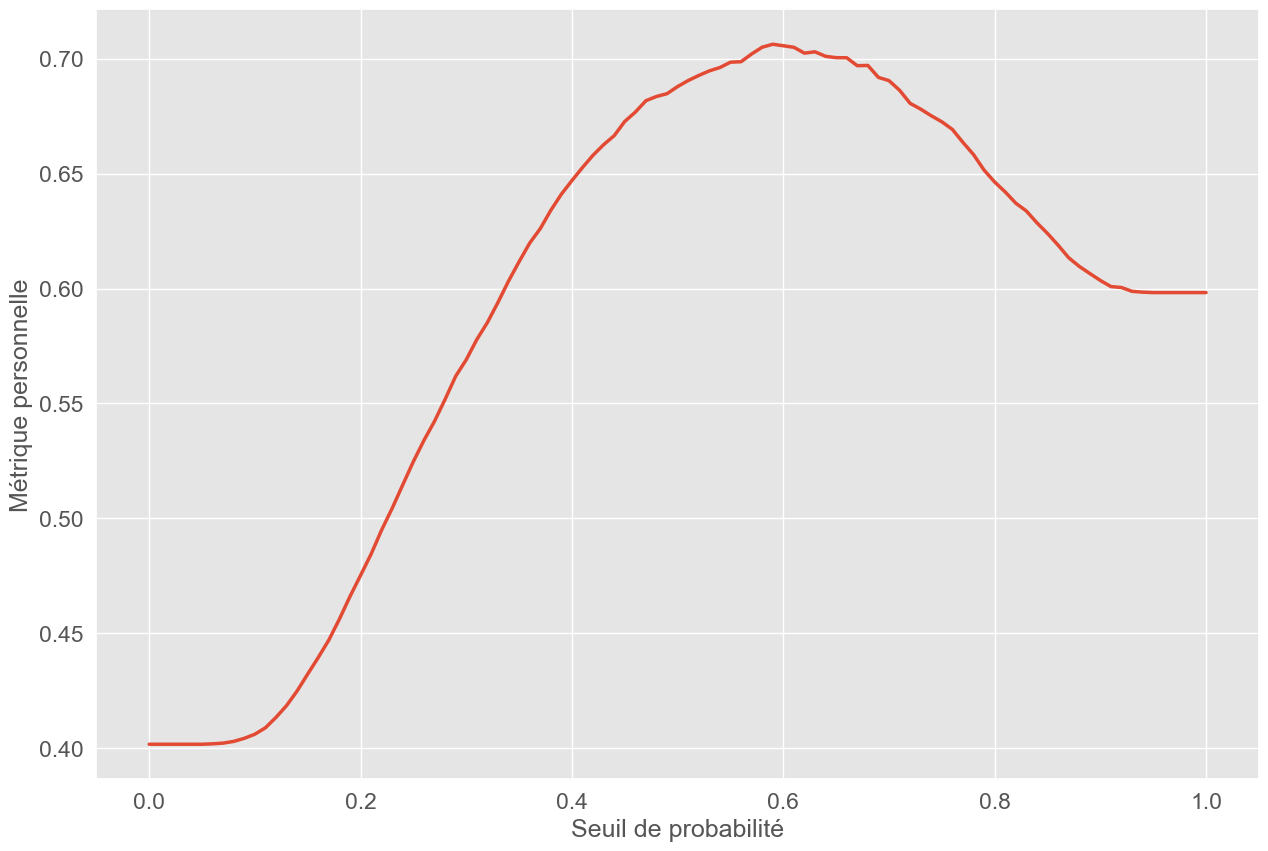

time: 3.45 s (started: 2023-07-05 16:13:39 +02:00)


In [363]:
# Initialisation d'une liste vide pour stocker les scores pour la métrique personnalisée.
scor_int = []

# Création d'une liste de seuils de probabilité de 0.0 à 1.0 avec un pas de 0.01.
int_seuil = np.arange(0.0, 1.01, 0.01)

# Boucle pour calculer les scores pour chaque seuil de probabilité.
for s in int_seuil:
    # Initialisation d'une liste pour stocker les valeurs prédites en fonction du seuil.
    y_seuil = []

    # Boucle pour prédire les valeurs en fonction des probabilités et du seuil.
    for i in probability_default_payment:
        if i >= s:
            y_seuil.append(1)
        elif i < s:
            y_seuil.append(0)

    # Calcul de la matrice de confusion à partir des valeurs prédites et réelles.
    tn, fp, fn, tp = confusion_matrix(y_test, y_seuil, labels=[0, 1]).ravel()

    # Calcul du score pour la métrique personnalisée à l'aide de la fonction score_banq().
    scor_int.append(score_banq(tn, fp, fn, tp, 10, -1, -100, 0))

# Tracé du graphique pour visualiser les scores en fonction des seuils de probabilité.
plt.figure(figsize=(15, 10))
plt.plot(int_seuil, scor_int)
plt.xlabel("Seuil de probabilité")
plt.ylabel("Métrique personnelle")
plt.show()


Nous pouvons voir sur ce graphique qu'il y a un pic maximum ce qui correspond au seuil optimal que devrait choisir la banque lors de l'accord ou non d'un prêt pour avoir le maximum de gain.

In [364]:
# Création d'un DataFrame vide avec les colonnes "int_seuil" et "scor_int".
seuil = pd.DataFrame(columns=['int_seuil', 'scor_int'])

# Attribution des valeurs des seuils de probabilité à la colonne "int_seuil".
seuil['int_seuil'] = int_seuil

# Attribution des valeurs des scores de la métrique personnalisée à la colonne "scor_int".
seuil['scor_int'] = scor_int


time: 0 ns (started: 2023-07-05 16:15:42 +02:00)


In [368]:
# Création d'un nouveau DataFrame "max" en sélectionnant les lignes de "seuil" où la colonne "scor_int" est égale à la valeur maximale de "scor_int".
max = pd.DataFrame(seuil[seuil['scor_int'] == seuil['scor_int'].max()])
max

,int_seuil,scor_int
59,0.59,0.706247


time: 16 ms (started: 2023-07-05 16:17:17 +02:00)


In [370]:
# Récupération de la valeur du seuil de probabilité qui a donné le score de la métrique personnalisée le plus élevé.
seuil = max.iloc[0]['int_seuil']
seuil

0.59

time: 0 ns (started: 2023-07-05 16:18:07 +02:00)


Le seuil optimal pour que la banque fasse le maximum de gain est de 0.6

#### 9.4 Exécution seuil optimal pour la banque

In [371]:
# prédire la classe de chaque échantillon en fonction du seuil de probabilité optimal déterminé précédemment
prediction = []

# Parcours de chaque probabilité de défaut de paiement
for i in probability_default_payment:
    if i >= seuil:
        prediction.append(1)  # Si la probabilité est supérieure ou égale au seuil, prédiction de la classe 1 (défaut de paiement)
    elif i < seuil:
        prediction.append(0)  # Si la probabilité est inférieure au seuil, prédiction de la classe 0 (pas de défaut de paiement)


time: 16 ms (started: 2023-07-05 16:21:18 +02:00)


In [373]:
def test_train_col_category(dataframe_train, dataframe_test, col, size, seuil):
    '''la fonction prend en entrée deux DataFrames,
    le nom d'une colonne, une taille pour la figure et un seuil.
    La fonction calcule ensuite les valeurs 
    et les étiquettes de la colonne dans les ensembles d'entraînement 
    et de test, puis crée deux graphiques en camembert 
    pour comparer visuellement la distribution des valeurs de la colonne
    entre les deux ensembles, en tenant compte du seuil spécifié 
    pour le deuxième graphique.
    '''

    # Calculer les valeurs et les étiquettes de la colonne pour l'ensemble d'entraînement
    values_train = dataframe_train[col].value_counts()
    labels_train = dataframe_train[col].value_counts().index

    # Calculer les valeurs et les étiquettes de la colonne pour l'ensemble de test
    values_test = dataframe_test[col].value_counts()
    labels_test = dataframe_test[col].value_counts().index
    
    # Créer une nouvelle figure avec une taille spécifiée
    plt.figure(figsize=size)

    # Première sous-figure (1ère colonne de 2x2)
    plt.subplot(2, 2, 1)
    # Titre du graphique
    plt.title("Distribution of clients at threshold 0.50", fontsize=20)
    # Créer un graphique en camembert (pie chart) pour représenter la distribution des valeurs dans l'ensemble d'entraînement
    plt.pie(values_train, labels=labels_train, autopct='%.1f%%', shadow=True, textprops={'fontsize': 20})
    
    # Deuxième sous-figure (2ème colonne de 2x2)
    plt.subplot(2, 2, 2)
    # Titre du graphique
    plt.title("Distribution of clients at threshold {}".format(seuil), fontsize=20)
    # Créer un graphique en camembert (pie chart) pour représenter la distribution des valeurs dans l'ensemble de test avec le seuil spécifié
    plt.pie(values_test, labels=labels_test, autopct='%.1f%%', shadow=True, textprops={'fontsize': 20})
    # Ajuster l'aspect du graphique pour qu'il soit circulaire
    plt.axis('equal')
    plt.tight_layout()
    # Afficher la légende pour identifier les différentes catégories
    plt.legend()
    # Afficher les graphiques
    plt.show()


time: 0 ns (started: 2023-07-05 16:24:35 +02:00)


In [375]:
# Crée un DataFrame avec deux colonnes : "SK_ID_CURR" pour les identifiants des clients du jeu de test (X_test)
# et "probability_default_payment" pour stocker les prédictions binaires (0 ou 1) pour le défaut de paiement
predictive_class_54 = pd.DataFrame({
    'SK_ID_CURR': X_test.index, # La première colonne 'SK_ID_CURR' contiendra les identifiants uniques des emprunteurs dans l'ensemble de test.
    'probability_default_payment': prediction # La deuxième colonne 'probability_default_payment' contiendra les probabilités de défaut de paiement prédites par le modèle pour chaque emprunteur dans X_test.
    })

time: 31 ms (started: 2023-07-05 16:31:18 +02:00)


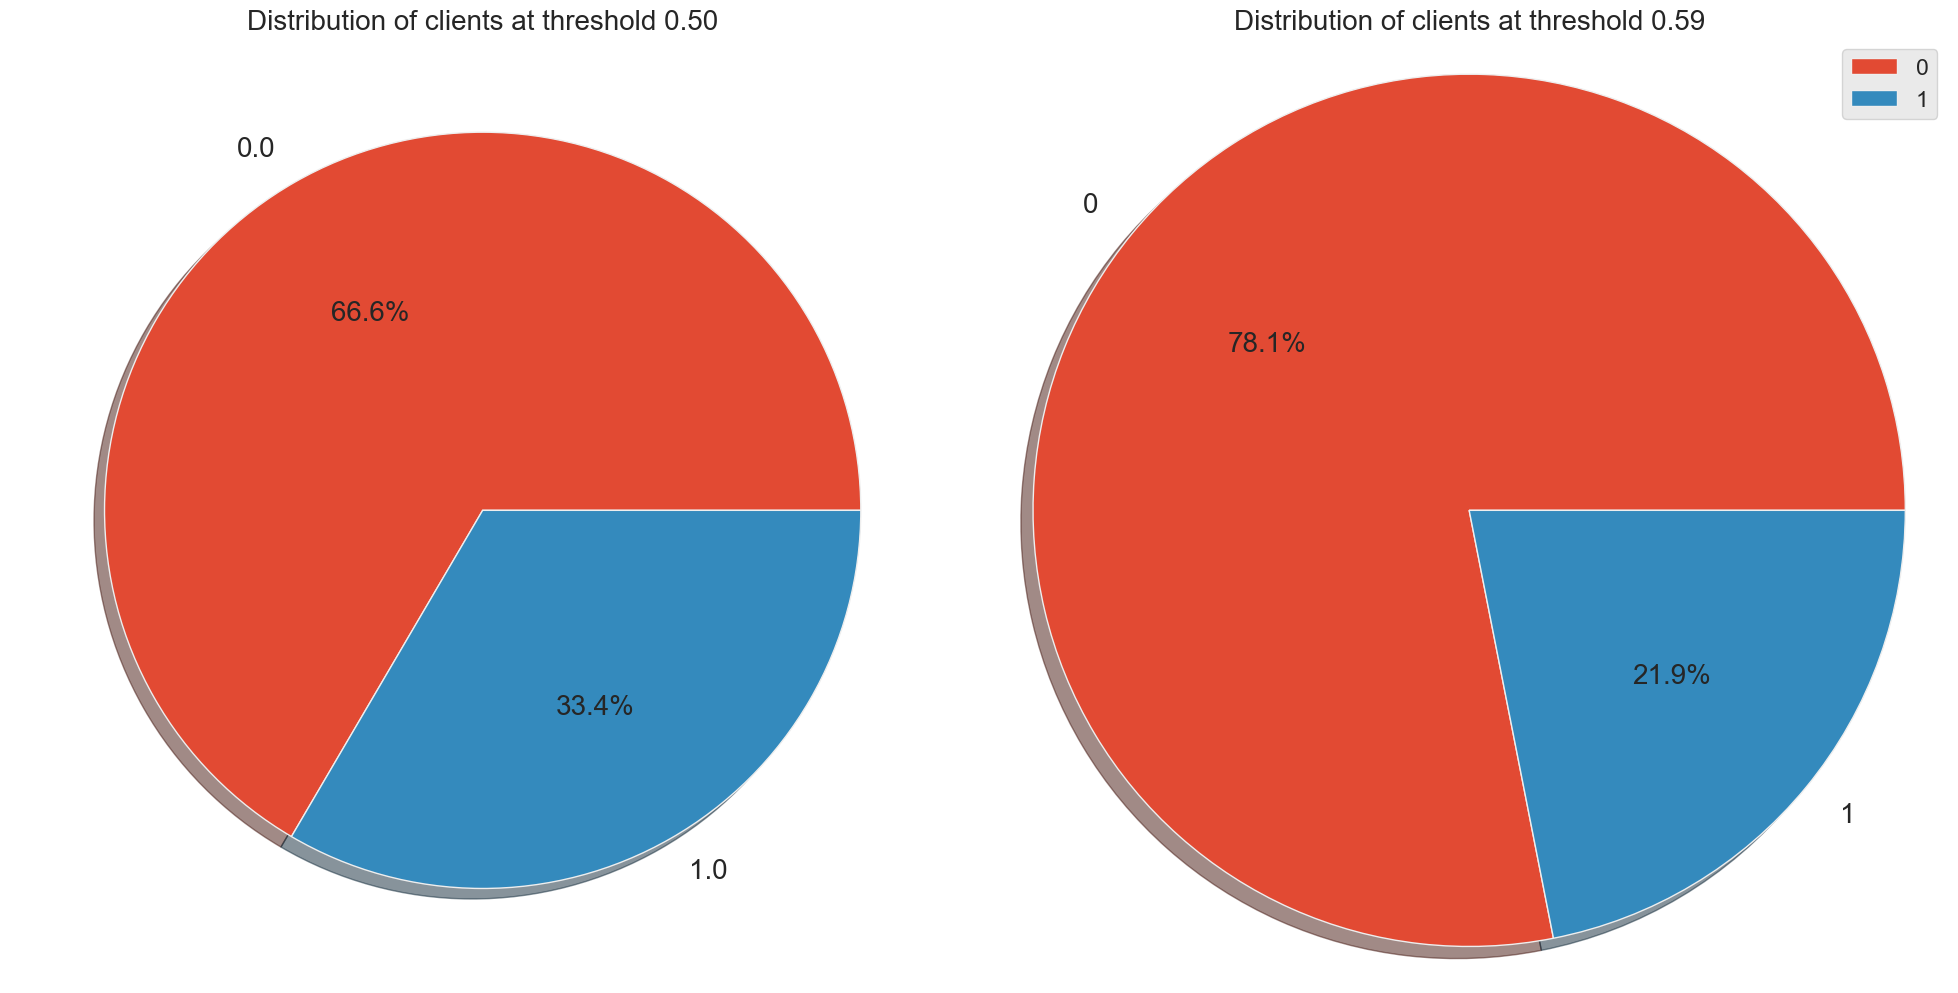

time: 782 ms (started: 2023-07-05 16:37:16 +02:00)


In [378]:
test_train_col_category(predictive_class_50, predictive_class_54, 'probability_default_payment', (20,20), seuil)

In [383]:
# Calcul de l'accuracy entre les vraies étiquettes (y_test) et les prédictions binaires du modèle (prediction)
accuracy = accuracy_score(y_test, prediction)
print(colored(f'L\'accuracy score est de {accuracy}\n', 'blue'))

# Calcul du score de précision entre les vraies étiquettes (y_test) et les prédictions binaires du modèle (prediction)
precision = precision_score(y_test, prediction, average='binary')
print(colored(f'Le score de précision est de {precision}\n', 'blue'))

# Calcul du score recall entre les vraies étiquettes (y_test) et les prédictions binaires du modèle (prediction)
recall = recall_score(y_test, prediction, average='binary')
print(colored(f'Le score recall est de {recall}\n', 'blue'))

# Calcul de l'AUC (Area Under the Curve) entre les vraies étiquettes (y_test) et les probabilités de défaut de paiement (probability_default_payment)
AUC = roc_auc_score(y_test, probability_default_payment)       
print(colored(f'Le score AUC est de {AUC} \n', 'blue'))

# Calcul du score f1 entre les vraies étiquettes (y_test) et les prédictions binaires du modèle (prediction)
f1 = f1_score(y_test, prediction, average='binary')
print(colored(f'Le score f1 est de {f1}\n', 'blue'))


L'accuracy score est de 0.7889025256766359

Le score de précision est de 0.17516956649955764

Le score recall est de 0.5577464788732395

Le score AUC est de 0.7548178406361216 

Le score f1 est de 0.2666068222621185

time: 281 ms (started: 2023-07-05 16:42:42 +02:00)


In [384]:
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
df_matrice_confusion = matrix_TN_FN(y_test, prediction)

# Affichage de la matrice de confusion
print("Matrice de confusion :")
df_matrice_confusion

Matrice de confusion :


,Predicted Negative (0),Predicted Positive (1)
Real Negative (0),23238 (TN),5594 (FP)
Real Positive (1),942 (FN),1188 (TP)


time: 46 ms (started: 2023-07-05 16:43:26 +02:00)


In [385]:
# Calcul de l'AUC (Area Under the Curve) en utilisant les étiquettes réelles 'y_test' et les probabilités de classe positive 'probability_default_payment'.
roc_auc = roc_auc_score(y_test, probability_default_payment)

# Affichage du résultat de l'AUC 
print('AUC : %0.4f' % roc_auc)

# Calcul du rapport de classification en comparant les étiquettes réelles 'y_test' et les prédictions 'prediction'.
# La fonction 'classification_report' produit un rapport complet incluant les métriques de précision, rappel, F1-score et le support pour chaque classe.
report = classification_report(y_test, prediction)

# Affichage du rapport de classification.
print(report)

AUC : 0.7548
              precision    recall  f1-score   support

         0.0       0.96      0.81      0.88     28832
         1.0       0.18      0.56      0.27      2130

    accuracy                           0.79     30962
   macro avg       0.57      0.68      0.57     30962
weighted avg       0.91      0.79      0.83     30962

time: 141 ms (started: 2023-07-05 16:44:15 +02:00)


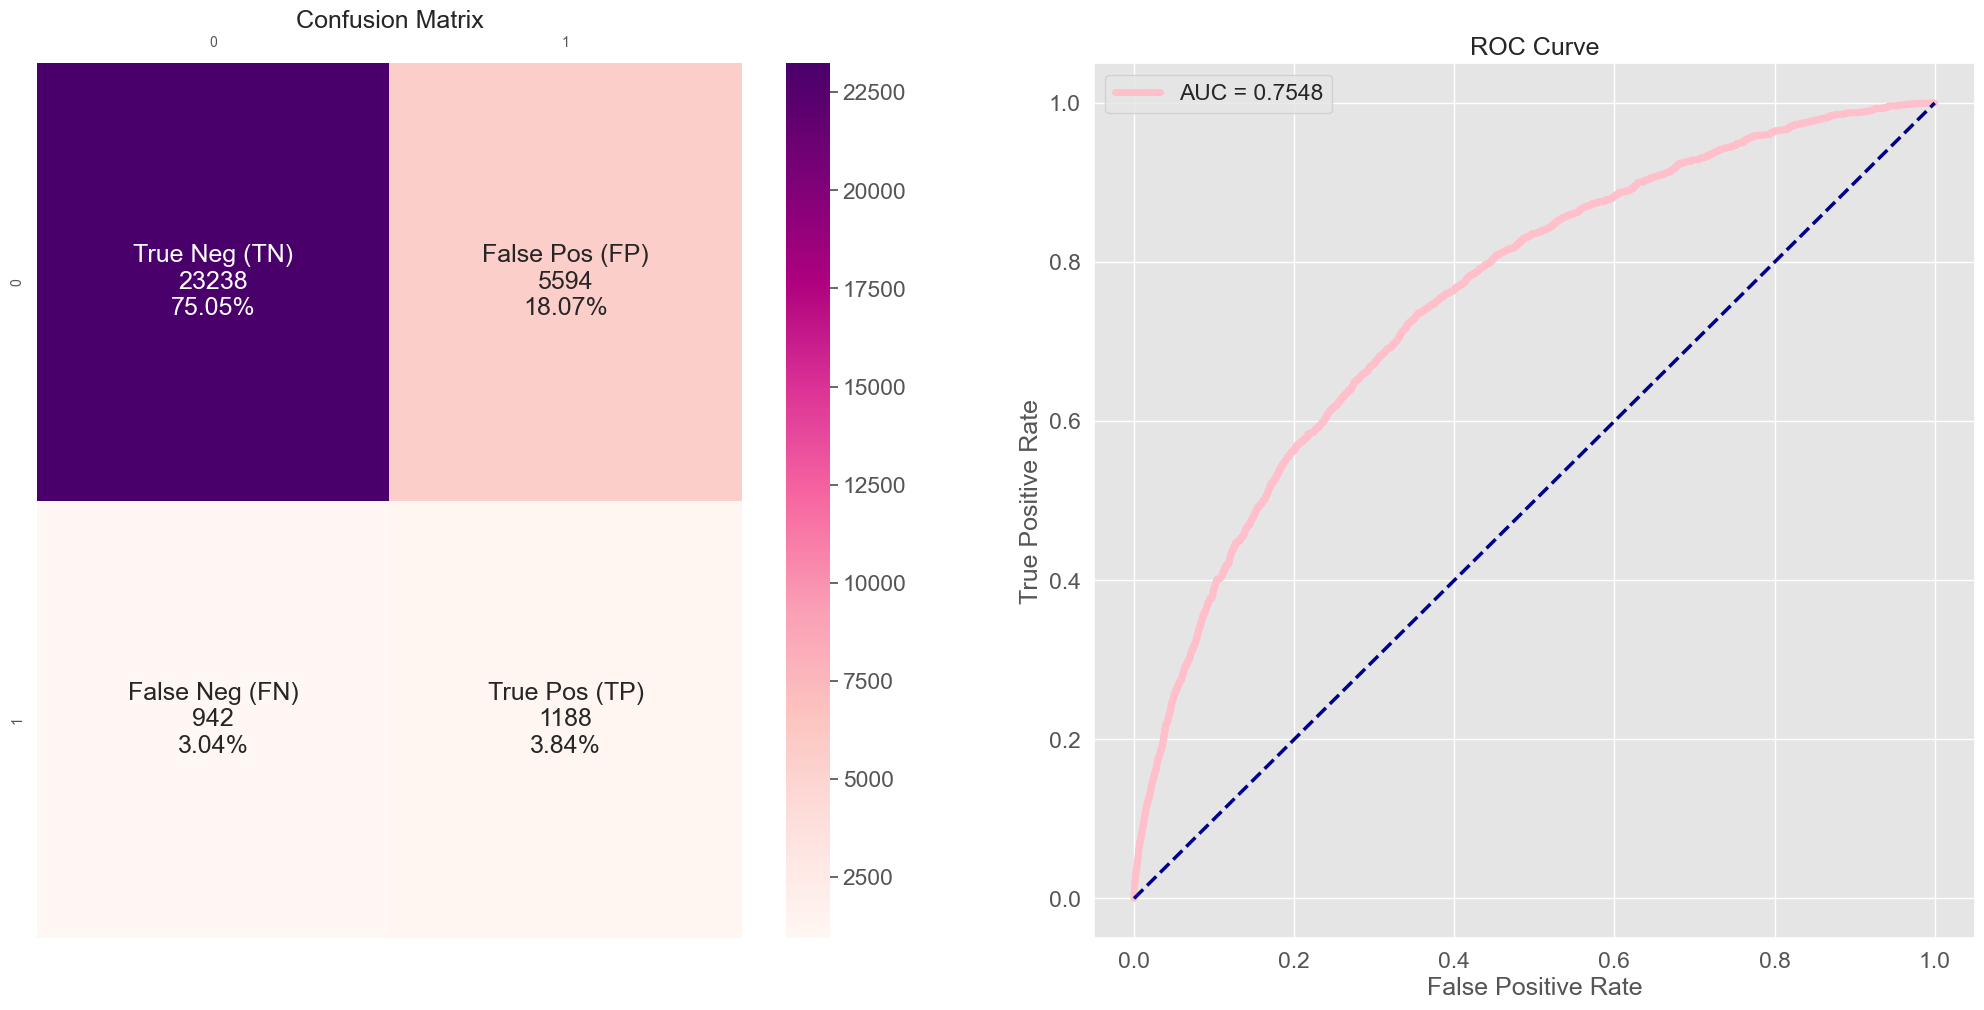

True negative =  23238
False positive =  5594
False negative =  942
True positive =  1188
time: 1.05 s (started: 2023-07-05 16:45:24 +02:00)


In [386]:
# Appliquer la fonction "cf_matrix_roc_auc" pour calculer les valeurs des vrais négatifs (TN), faux positifs (FP), faux négatifs (FN) et vrais positifs (TP)
# Les paramètres passés à la fonction sont :
# - "y_test" : les vraies étiquettes de la classe cible
# - "prediction" : les étiquettes prédites par le modèle
# - "probability" : les probabilités de la classe positive prédites par le modèle
# - (25, 25) : la taille de la figure pour afficher la matrice de confusion et la courbe ROC
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (25, 25))


In [387]:
# Appel de la fonction "score_banq" pour calculer le score de gain
# Les paramètres passés à la fonction sont :
# - tn : le nombre de vrais négatifs (True Negatives)
# - fp : le nombre de faux positifs (False Positives)
# - fn : le nombre de faux négatifs (False Negatives)
# - tp : le nombre de vrais positifs (True Positives)
# - 10 : le gain pour un vrai positif (True Positive Gain)
# - -1 : le coût pour un faux positif (False Positive Cost)
# - -100 : le coût pour un faux négatif (False Negative Cost)
# - 0 : le coût pour un vrai négatif (True Negative Cost)
score_gain = score_banq(tn, fp, fn, tp, 10, -1, -100, 0)
score_gain

0.7062465104347433

time: 0 ns (started: 2023-07-05 16:45:33 +02:00)


In [388]:
# Ajout des métriques du modèle 
comparison_thresh_59 = pd.DataFrame(
        {
            "Modele": "Après détermination du seuil optimal (0,59)",
            "Accuracy": accuracy,            # Précision globale du modèle (TP + TN) / (TP + TN + FP + FN)
            "AUC": AUC,                      # Aire sous la courbe ROC du modèle
            "Recall class 1": recall,        # Rappel (recall) de la classe 1 (défaut de paiement) du modèle
            "F1": f1,                        # Score F1, mesure harmonique entre la précision et le rappel
            "TP": tp,                        # Nombre de vrais positifs du modèle (prédictions correctes de la classe 1)
            "Precision": precision,          # Précision du modèle TP / (TP + FP)
            "FN": fn,                        # Nombre de faux négatifs du modèle (prédictions erronées de la classe 1)
            "score Gain": score_gain,        # Score Gain calculé à partir des coûts spécifiés
            "time": prediction_time          # Temps de prédiction pour le modèle
        },
        index=[1],                          # Utilisation de l'index 0 pour ajouter une seule ligne au DataFrame
    )

# Affichage du DataFrame contenant les métriques de performance du modèle 
comparison_thresh = pd.concat([comparison_thresh,comparison_thresh_59])
comparison_thresh

,Modele,Accuracy,AUC,Recall class 1,F1,TP,Precision,FN,score Gain,time
0,"Avant de déterminer le seuil optimal (0,50)",0.690750,0.754818,0.682629,0.232957,1454,0.140442,676,0.687846,1.734061
1,"Après détermination du seuil optimal (0,59)",0.788903,0.754818,0.557746,0.266607,1188,0.175170,942,0.706247,1.734061


time: 31 ms (started: 2023-07-05 16:50:23 +02:00)


In [389]:
# Création d'un nouveau DataFrame en concaténant X_test et y_test le long de l'axe des colonnes (axis=1).
comparison_percentage = pd.concat([X_test, y_test], axis=1)

# Ajout d'une colonne appelée 'PREDICTION' au DataFrame "comparison_percentage" pour y stocker les prédictions du modèle "prediction".
comparison_percentage['PREDICTION'] = prediction


time: 47 ms (started: 2023-07-05 16:52:51 +02:00)


In [390]:
comparison_percentage

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,EMERGENCYSTATE_MODE,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,...,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business_Entity_Type_1,ORGANIZATION_TYPE_Business_Entity_Type_2,ORGANIZATION_TYPE_Business_Entity_Type_3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry_type_1,ORGANIZATION_TYPE_Industry_type_10,ORGANIZATION_TYPE_Industry_type_11,ORGANIZATION_TYPE_Industry_type_12,ORGANIZATION_TYPE_Industry_type_13,ORGANIZATION_TYPE_Industry_type_2,ORGANIZATION_TYPE_Industry_type_3,ORGANIZATION_TYPE_Industry_type_4,ORGANIZATION_TYPE_Industry_type_5,ORGANIZATION_TYPE_Industry_type_6,ORGANIZATION_TYPE_Industry_type_7,ORGANIZATION_TYPE_Industry_type_9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal_Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security_Ministries,ORGANIZATION_TYPE_Selfemployed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade_type_1,ORGANIZATION_TYPE_Trade_type_2,ORGANIZATION_TYPE_Trade_type_3,ORGANIZATION_TYPE_Trade_type_4,ORGANIZATION_TYPE_Trade_type_5,ORGANIZATION_TYPE_Trade_type_6,ORGANIZATION_TYPE_Trade_type_7,ORGANIZATION_TYPE_Transport_type_1,ORGANIZATION_TYPE_Transport_type_2,ORGANIZATION_TYPE_Transport_type_3,ORGANIZATION_TYPE_Transport_type_4,ORGANIZATION_TYPE_University,HOUSETYPE_MODE_block_of_flats,HOUSETYPE_MODE_specific_housing,HOUSETYPE_MODE_terraced_house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,WALLSMATERIAL_MODE_Stone_brick,WALLSMATERIAL_MODE_Wooden,MOST_CREDIT_TYPE_Another_type_of_loan,MOST_CREDIT_TYPE_Car_loan,MOST_CREDIT_TYPE_Consumer_credit,MOST_CREDIT_TYPE_Credit_card,MOST_CREDIT_TYPE_Loan_for_business_development,MOST_CREDIT_TYPE_Loan_for_working_capital_replenishment,MOST_CREDIT_TYPE_Microloan,MOST_CREDIT_TYPE_Mortgage,TARGET,PREDICTION
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
316145,0,0,0,1,0,-0.573222,0.140349,-0.271295,-0.365874,-0.276938,0.181777,1.228470,0.620128,-1.477886,-0.799974,0.002542,-2.182687,-0.46321,0.047807,-0.671139,-0.267116,-0.108965,0.032789,0.100683,-0.090535,-0.110786,-0.220085,-

time: 484 ms (started: 2023-07-05 16:52:58 +02:00)


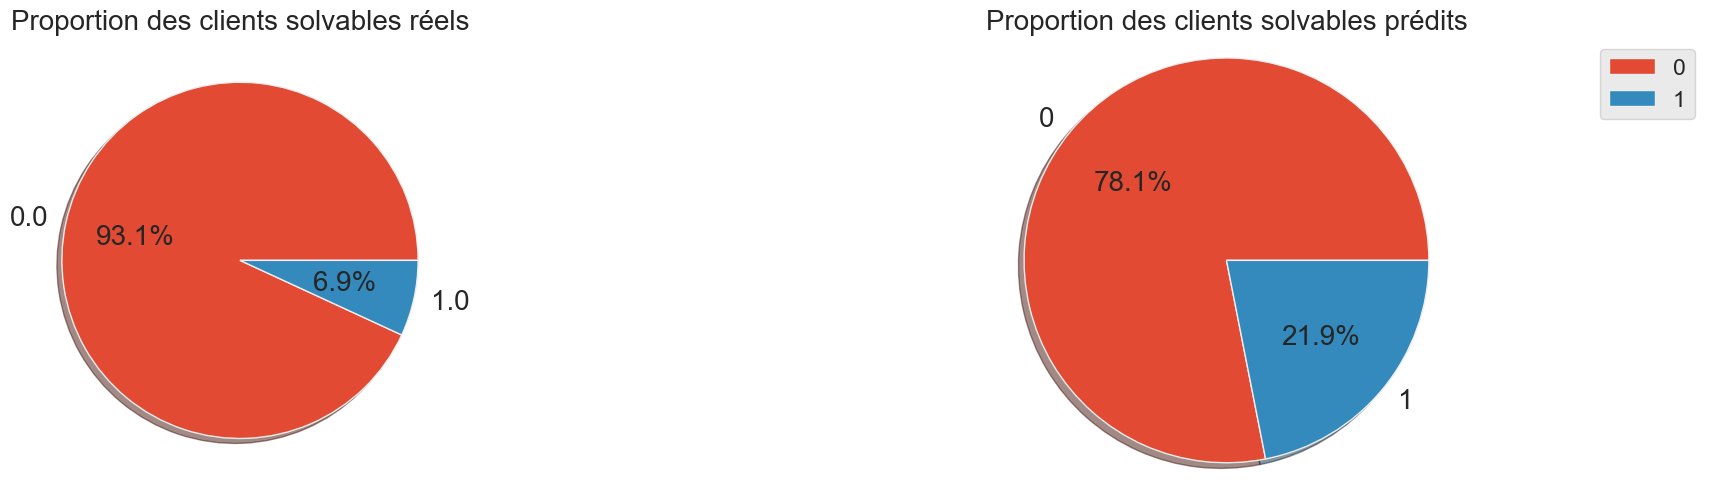

time: 578 ms (started: 2023-07-05 16:58:21 +02:00)


In [394]:
# Compter le nombre de clients solvables (0) et de clients insolvable (1) dans les données réelles (y_test) et stocker les valeurs et les étiquettes.
values_train = comparison_percentage["TARGET"].value_counts()
labels_train = comparison_percentage["TARGET"].value_counts().index

# Compter le nombre de clients solvables (0) et de clients insolvable (1) dans les prédictions du modèle (prediction) et stocker les valeurs et les étiquettes.
values_test = comparison_percentage["PREDICTION"].value_counts()
labels_test = comparison_percentage["PREDICTION"].value_counts().index
    
# Créer une figure de taille (20, 10) pour afficher les deux graphiques côte à côte.
plt.figure(figsize=(20,10))
    
# Sous-plot 1: Afficher un graphique circulaire (pie chart) de la proportion des clients solvables dans les données réelles.
plt.subplot(2, 2, 1)
plt.title("Proportion des clients solvables réels", fontsize=20)
plt.pie(values_train, labels=labels_train, autopct='%.1f%%', shadow=True, textprops={'fontsize': 20})
    
# Sous-plot 2: Afficher un graphique circulaire (pie chart) de la proportion des clients solvables prédits par le modèle.
plt.subplot(2, 2, 2)
plt.title("Proportion des clients solvables prédits", fontsize=20)
plt.pie(values_test, labels=labels_test, autopct='%.1f%%', shadow=True, textprops={'fontsize': 20})
plt.axis('equal')  # Pour que le graphique soit un cercle complet (un aspect équilibré).
plt.tight_layout()  # Pour éviter que les labels se chevauchent.
plt.legend()  # Ajouter une légende pour indiquer la signification des couleurs.
plt.show()  # Afficher les deux graphiques.


il y a plus de personnes catégorisées comme personnes ne pouvant pas payer leur prêt comparé à la réalité. Le fait qu'il y ait plus de personnes prédites comme des non payeur n'est pas grave car la banque ne perd pas d'argent.

#### 9.5 Importance des features 

##### 9.5.1 Features importance simple

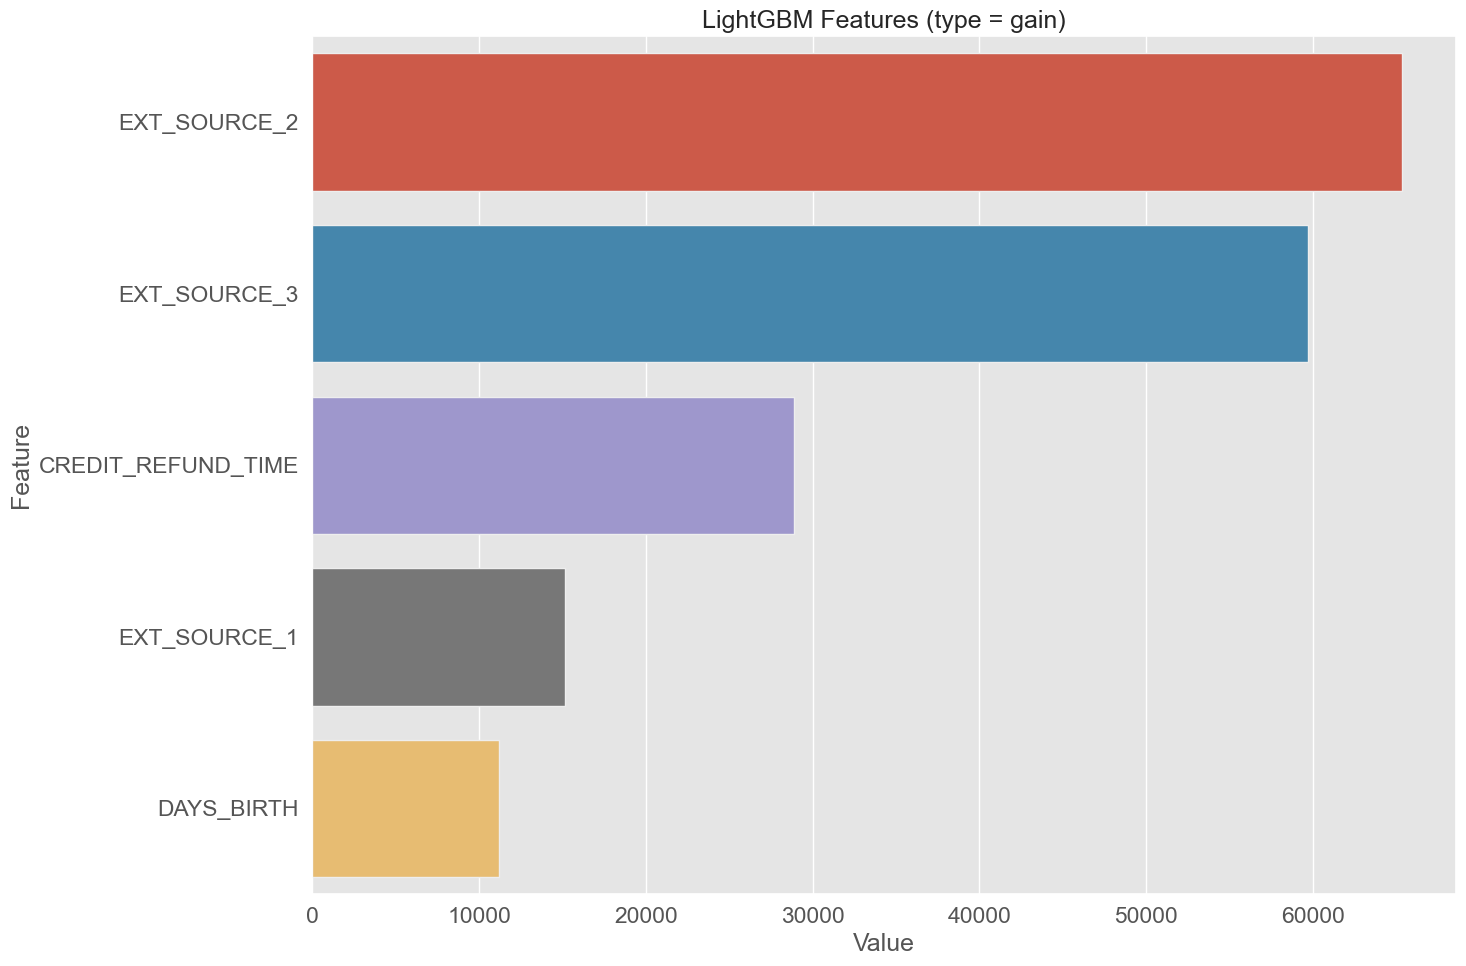

time: 515 ms (started: 2023-07-05 17:02:51 +02:00)


In [395]:
# Calculer l'importance des fonctionnalités en utilisant les gains (type='gain') du modèle LightGBM.
feature_imp = pd.DataFrame(sorted(zip(best_model.booster_.feature_importance(importance_type='gain'), X_train_undersampled.columns)), columns=['Value', 'Feature'])

# Créer une figure pour afficher le graphique des fonctionnalités les plus importantes.
plt.figure(figsize=(15, 10))

# Tracer un graphique à barres (barplot) pour afficher les 5 fonctionnalités les plus importantes.
# Les fonctionnalités sont triées par ordre décroissant en fonction de leurs valeurs d'importance (gains).
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(5))

# Ajouter un titre au graphique.
plt.title('LightGBM Features (type = gain)')

# Ajuster la disposition du graphique pour qu'il soit bien affiché.
plt.tight_layout()

# Afficher le graphique des fonctionnalités les plus importantes.
plt.show()


Avec cette représentation, on peut dire que les features les plus importantes pour la prédiction d'accord d'un prêt sont les sources extérieures 2 et 3 qui sont les scores normalisés créés à partir d'une source de données externe. Ces scores pourraient regrouper différentes caractéristiques sur le paiement d'un crédit tel que le retard de paiement par exemple. Plus ces scores sont élevés et plus le client risque de ne pas voir sa demande de prêt accepté.
Puis on trouve la durée que met un client à rembourser un prêt. Plus le temps de remboursement des crédits est grand plus il y a de chance que le prêt ne lui soit pas accordé. Puis il y a la source externe 1. 
Le nombre de jours depuis la naissance des clients donc leur âge joue un rôle important dans l'acceptation d'un crédit. Comme nous l'avons vu lors du préprocessing, les clients jeunes ont plus de mal à rembourser leur prêt. 

##### 9.5.2 Features importance SHAP

Les valeurs de Shapley calculent l’importance d’une variable en comparant la sortie qu’un modèle peut prédire avec et sans cette variable. Cependant, étant donné que l’ordre dans lequel un modèle voit les variables peut affecter ses prédictions, cela se fait dans tous les ordres possibles, afin que les fonctionnalités soient comparées équitablement. Cette approche est inspirée de la théorie des jeux.

SHAP s’utilise pour expliquer un modèle existant. Prenant un cas de classification binaire construite avec un modèle sklearn. On entraine
et teste notre modèle. Ensuite on peut utiliser nos données et le modèle pour créer un modèle supplémentaire de SHAP qui explique notre modèle de classification.

Les valeurs Shap sont des tableaux d'une longueur correspondant au nombre de classes dans la cible. Ici, le problème est la classification binaire, et donc les valeurs Shap ont deux tableaux correspondant à l'une ou l'autre classe.

Les valeurs Shap sont des nombres à virgule flottante correspondant aux données de chaque ligne correspondant à chaque caractéristique. La valeur Shap représente la contribution de ce point de données particulier dans la prédiction des sorties. Si la valeur shap est très proche de zéro, on peut dire que le point de données contribue très peu aux prédictions. Si la valeur shap est une valeur fortement positive ou fortement négative, nous pouvons dire que le point de données contribue grandement à la prédiction de la classe positive ou négative.



In [396]:
import shap
# Calculer les valeurs SHAP pour les prédictions du modèle LightGBM.
# On utilise le TreeExplainer de SHAP en lui passant le modèle LightGBM (best_model.booster_) pour expliquer les prédictions.
# X_test.iloc[:10000,:] : Sous-ensemble des données de test pour lesquelles nous voulons calculer les valeurs SHAP.
shap_values = shap.TreeExplainer(best_model.booster_).shap_values(X_test.iloc[:10000, :])


time: 1min 2s (started: 2023-07-05 17:17:29 +02:00)


In [397]:
# Calculer l'importance globale des features à partir des valeurs SHAP.
# np.abs(shap_values) prend la valeur absolue des SHAP values pour chaque feature et chaque prédiction.
# .mean(0) calcule la moyenne des SHAP values pour chaque feature sur l'ensemble des prédictions.
# [:-1] est utilisé pour exclure la dernière colonne qui correspond à la colonne de biais ou d'intercept du modèle (non une feature réelle).
global_importances = np.abs(shap_values).mean(0)[:-1]


time: 47 ms (started: 2023-07-05 17:20:25 +02:00)


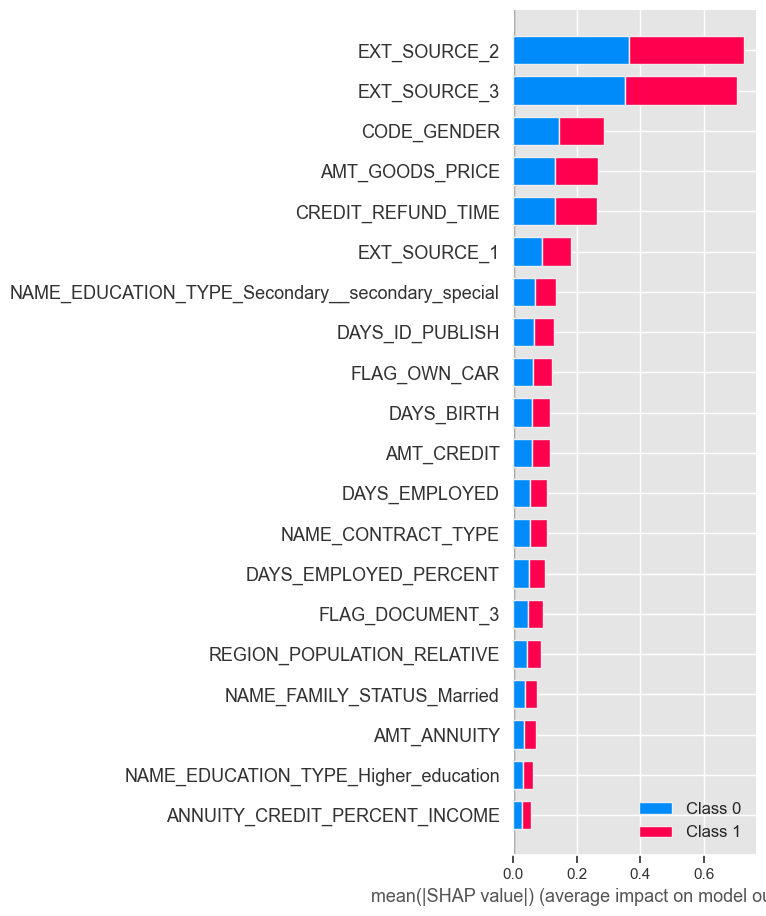

time: 766 ms (started: 2023-07-05 17:26:46 +02:00)


In [398]:
# shap.summary_plot(shap_values, X_test.iloc[:10000,:]) génère un graphique de résumé.
# shap_values est la matrice des valeurs SHAP calculées précédemment pour les prédictions du modèle sur les 10 000 premières lignes de X_test.
# X_test.iloc[:10000,:] sélectionne les 10 000 premières lignes du DataFrame X_test pour lesquelles nous voulons afficher les explications.
# Le graphique de résumé affiche une barre horizontale pour chaque feature, indiquant son impact sur les prédictions.
# Les features sont triées par importance globale, de la plus à la moins importante.
# La couleur des barres représente la valeur de la feature pour chaque prédiction, où le bleu indique des valeurs basses et le rouge des valeurs élevées.
# Le graphique permet de visualiser comment chaque feature contribue aux prédictions du modèle et dans quelle mesure.
shap.summary_plot(shap_values, X_test.iloc[:10000,:])

Avec ce graphique, nous pouvons voir que nous retrouvons les EXT_SOURCES 1, 2 et 3 ainsi que CREDIT_REFUND_TIME. Un peu plus bas nous retrouvons DAYS_BIRTHS même si il semble jouer un rôle moins important pour le fait qu'une personne soit non solvable. Dans cette nouvelle représentation, le Genre du client est important dans la prédiction mais nous ne le prendrons pas en compte car cette information ferait de notre modèle un modèle discriminant. Nous trouvons également un rôle important pour la variable AMT_GOODS_PRICE qui correspond au montant du prix des biens pour lesquels le prêt est accordé pour les prêts de consommation qui ne sera pas pris en compte car le choix peut être biaisé et le crédit ne pourrait pas être accordé si le biens est trop cher.

Nous prendrons donc en comte les features EXT_SOURCES 1, 2, 3 ainsi que CREDIT_REFUND_TIME et l'âge.

Voyons plus en détail l'influence de chacune de ces variables sur la prédiction de non solvabilité.

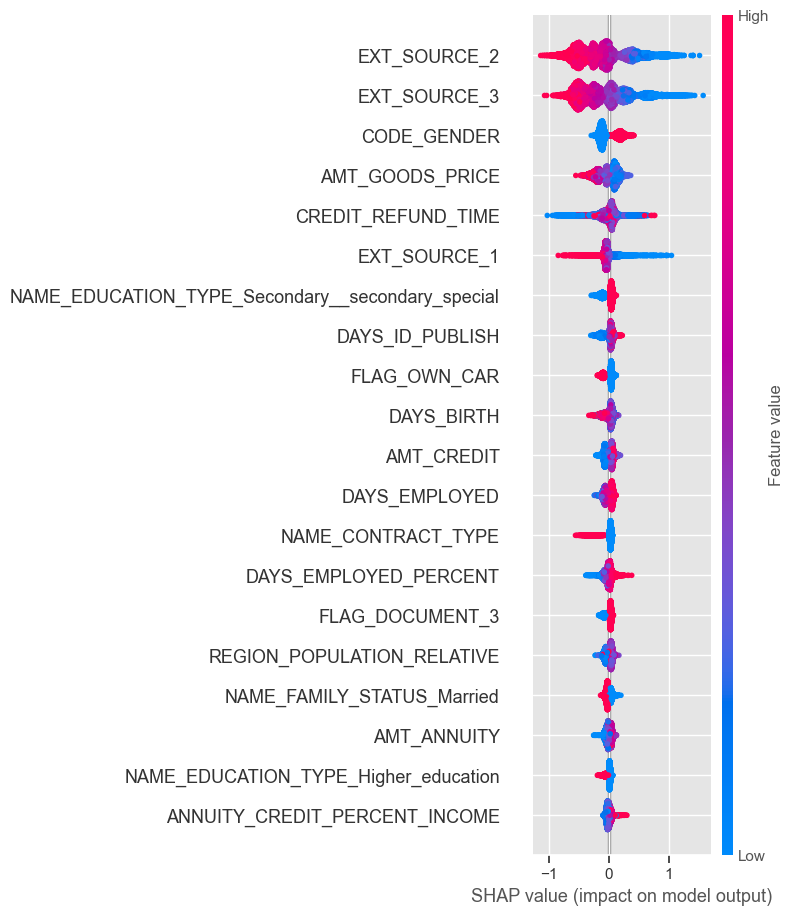

time: 3.86 s (started: 2023-07-05 17:30:55 +02:00)


In [399]:
# shap.summary_plot(shap_values[1], X_test.astype("float").iloc[:10000,:]) génère un graphique de résumé spécifique à la classe "1".
# shap_values[1] correspond aux valeurs SHAP calculées précédemment pour les prédictions de la classe "1" du modèle sur les 10 000 premières lignes de X_test.
# X_test.astype("float").iloc[:10000,:] sélectionne les 10 000 premières lignes du DataFrame X_test et les convertit en type "float".
# Le graphique de résumé spécifique à la classe "1" affiche une barre horizontale pour chaque feature, indiquant son impact sur les prédictions de la classe "1".
# Les features sont triées par importance globale, de la plus à la moins importante, pour la classe "1".
# La couleur des barres représente la valeur de la feature pour chaque prédiction de la classe "1", où le bleu indique des valeurs basses et le rouge des valeurs élevées.
# Le graphique permet de visualiser comment chaque feature contribue spécifiquement aux prédictions de la classe "1" du modèle et dans quelle mesure.
shap.summary_plot(shap_values[1], X_test.astype("float").iloc[:10000,:])

Nous traçons les valeurs SHAP de chaque caractéristique pour chaque échantillon sur l'axe des x, puis nous les laissons s'accumuler. Si nous colorons ensuite chaque point selon sa valeur, nous pouvons voir comment une valeur faible ou élevée affecte la sortie du modèle. 

Pour EXT_SOURCE_2, EXT_SOURCE_3, EXT_SOURCE_1 on peut voir que de faibles valeurs augmentent de manière significative la sortie de probabilité du modèle et donc le fait d'être non solvable.

Au contraire, pour CREDIT_REFUND_TIME, plus le temps de remboursement des crédits est grand plus il a de chance que le prêt ne lui soit pas accordé.